In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#WEEK 2 START
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [5]:
#create pandas DataFrame for financial anomaly data
financial_df = pd.read_csv("~/Analytics-Practicum/data/financial_anomaly_data2.csv")

In [6]:
#print first 5 columns of DataFrame
financial_df.head(5)

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,1/1/2023 8:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,1/1/2023 8:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,1/1/2023 8:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,1/1/2023 8:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,1/1/2023 8:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [7]:
#print class, RangeIndex, columns, non-null count, data type, and memory usage information
financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216960 entries, 0 to 216959
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Timestamp        216960 non-null  object 
 1   TransactionID    216960 non-null  object 
 2   AccountID        216960 non-null  object 
 3   Amount           216960 non-null  float64
 4   Merchant         216960 non-null  object 
 5   TransactionType  216960 non-null  object 
 6   Location         216960 non-null  object 
dtypes: float64(1), object(6)
memory usage: 11.6+ MB


In [8]:
#print shape of DataFrame
financial_df.shape

(216960, 7)

In [9]:
#print sum of null occurrences of each variable in DataFrame
print(financial_df.isnull().sum())

Timestamp          0
TransactionID      0
AccountID          0
Amount             0
Merchant           0
TransactionType    0
Location           0
dtype: int64


In [10]:
#create a new DataFrame excluding null occurrences
new_financial_df = financial_df.dropna()

In [11]:
#print shape of new DataFrame
new_financial_df.shape

(216960, 7)

In [12]:
#verify that null occurrences were handled properly
print(new_financial_df.isnull().sum())

Timestamp          0
TransactionID      0
AccountID          0
Amount             0
Merchant           0
TransactionType    0
Location           0
dtype: int64


In [13]:
#print number of unique occurrences of each variable in DataFrame
print(f"Number of unique Timestamp: {new_financial_df['Timestamp'].nunique()}")
print(f"Number of unique TransactionID: {new_financial_df['TransactionID'].nunique()}")
print(f"Number of unique AccountID: {new_financial_df['AccountID'].nunique()}")
print(f"Number of unique Amount: {new_financial_df['Amount'].nunique()}")
print(f"Number of unique Merchant: {new_financial_df['Merchant'].nunique()}")
print(f"Number of unique TransactionType: {new_financial_df['TransactionType'].nunique()}")
print(f"Number of unique Location: {new_financial_df['Location'].nunique()}")

Number of unique Timestamp: 216960
Number of unique TransactionID: 1999
Number of unique AccountID: 15
Number of unique Amount: 214687
Number of unique Merchant: 10
Number of unique TransactionType: 3
Number of unique Location: 5


In [14]:
#introduce new variables to DataFrame for analysis of certain variables' interactions
new_financial_df['AccountID/Merchant'] = new_financial_df['AccountID'].astype(str) + '_' + new_financial_df['Merchant']
new_financial_df['AccountID/TransactionID'] = new_financial_df['AccountID'].astype(str) + '_' + new_financial_df['TransactionID']
new_financial_df['AccountID/Merchant/TransactionID'] = new_financial_df['AccountID'].astype(str) + '_' + new_financial_df['Merchant'] + '_' + new_financial_df['TransactionID']
new_financial_df['TransactionType/Merchant'] = new_financial_df['TransactionType'].astype(str) + '_' + new_financial_df['Merchant']
new_financial_df['Location/TransactionType'] = new_financial_df['Location'].astype(str) + '_' + new_financial_df['TransactionType']
new_financial_df['Merchant/Location'] = new_financial_df['Merchant'].astype(str) + '_' + new_financial_df['Location']

In [15]:
#verify that new variables have been created successfully
new_financial_df.head(5)

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,AccountID/Merchant,AccountID/TransactionID,AccountID/Merchant/TransactionID,TransactionType/Merchant,Location/TransactionType,Merchant/Location
0,1/1/2023 8:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,ACC4_MerchantH,ACC4_TXN1127,ACC4_MerchantH_TXN1127,Purchase_MerchantH,Tokyo_Purchase,MerchantH_Tokyo
1,1/1/2023 8:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,ACC10_MerchantH,ACC10_TXN1639,ACC10_MerchantH_TXN1639,Purchase_MerchantH,London_Purchase,MerchantH_London
2,1/1/2023 8:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,ACC8_MerchantE,ACC8_TXN872,ACC8_MerchantE_TXN872,Withdrawal_MerchantE,London_Withdrawal,MerchantE_London
3,1/1/2023 8:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London,ACC6_MerchantE,ACC6_TXN1438,ACC6_MerchantE_TXN1438,Purchase_MerchantE,London_Purchase,MerchantE_London
4,1/1/2023 8:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,ACC6_MerchantI,ACC6_TXN1338,ACC6_MerchantI_TXN1338,Purchase_MerchantI,Los Angeles_Purchase,MerchantI_Los Angeles


In [16]:
#convert Timestamp variable to a DateTime object
new_financial_df['Timestamp'] = pd.to_datetime(new_financial_df['Timestamp'], format='%d/%m/%Y %H:%M')

In [17]:
#create distinct features for minute/hour of the day, day of the week, and month
new_financial_df['Minute'] = new_financial_df['Timestamp'].dt.minute
new_financial_df['Hour'] = new_financial_df['Timestamp'].dt.hour
new_financial_df['Day'] = new_financial_df['Timestamp'].dt.dayofweek
new_financial_df['Month'] = new_financial_df['Timestamp'].dt.month

In [18]:
#verify again that new variables have been created successfully
new_financial_df.head(5)

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,AccountID/Merchant,AccountID/TransactionID,AccountID/Merchant/TransactionID,TransactionType/Merchant,Location/TransactionType,Merchant/Location,Minute,Hour,Day,Month
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,ACC4_MerchantH,ACC4_TXN1127,ACC4_MerchantH_TXN1127,Purchase_MerchantH,Tokyo_Purchase,MerchantH_Tokyo,0,8,6,1
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,ACC10_MerchantH,ACC10_TXN1639,ACC10_MerchantH_TXN1639,Purchase_MerchantH,London_Purchase,MerchantH_London,1,8,6,1
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,ACC8_MerchantE,ACC8_TXN872,ACC8_MerchantE_TXN872,Withdrawal_MerchantE,London_Withdrawal,MerchantE_London,2,8,6,1
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,ACC6_MerchantE,ACC6_TXN1438,ACC6_MerchantE_TXN1438,Purchase_MerchantE,London_Purchase,MerchantE_London,3,8,6,1
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,ACC6_MerchantI,ACC6_TXN1338,ACC6_MerchantI_TXN1338,Purchase_MerchantI,Los Angeles_Purchase,MerchantI_Los Angeles,4,8,6,1


In [19]:
#Divide amount variable into appropriately-sized partitions
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
labels = ['0-10000', '10001-20000', '20001-30000', '30001-40000', '40001-50000', '50001-60000', '60001-70000', '70001-80000', '80001-90000', '90001-100000', '100001+']
new_financial_df['Amount_Partitions'] = pd.cut(new_financial_df['Amount'], bins=bins, labels=labels)

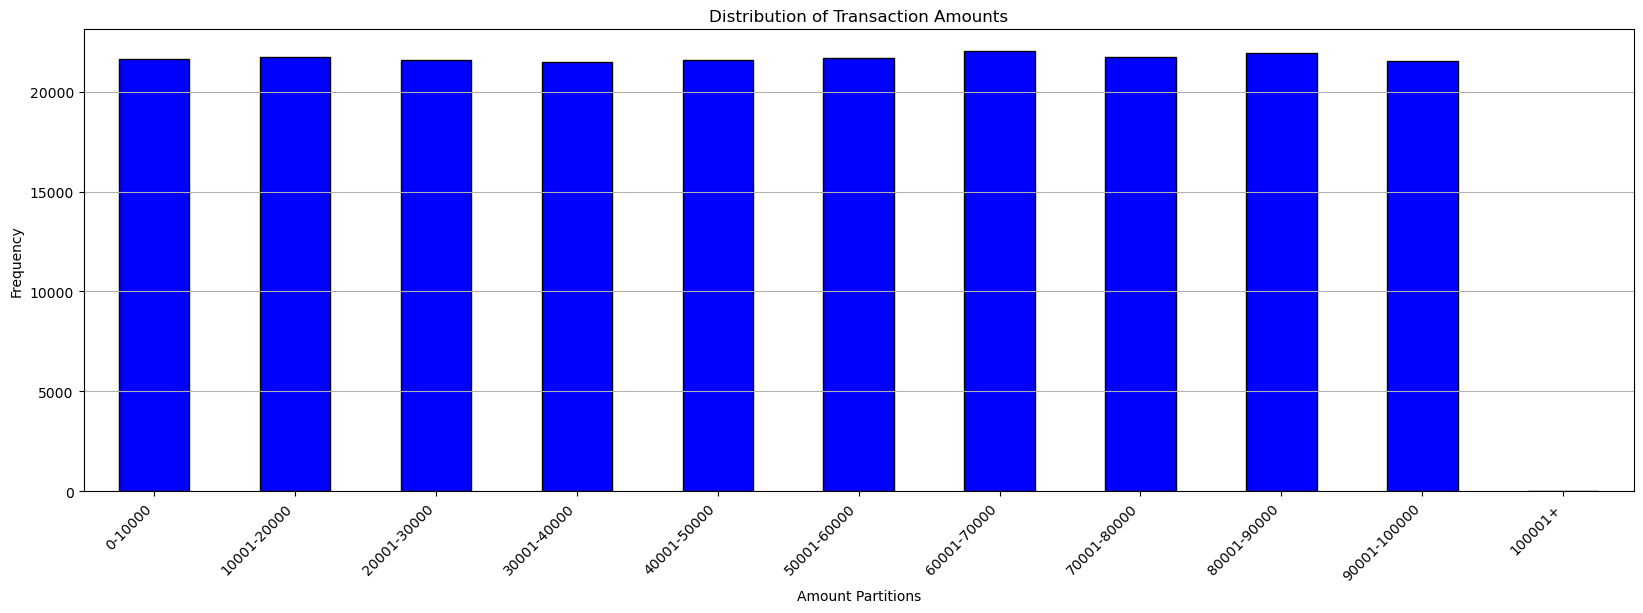

In [20]:
#Construct Bar Graph for distribution of transaction in each amount partition
partition_counts = new_financial_df['Amount_Partitions'].value_counts().reindex(labels)

plt.figure(figsize=(20, 6))
partition_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount Partitions')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

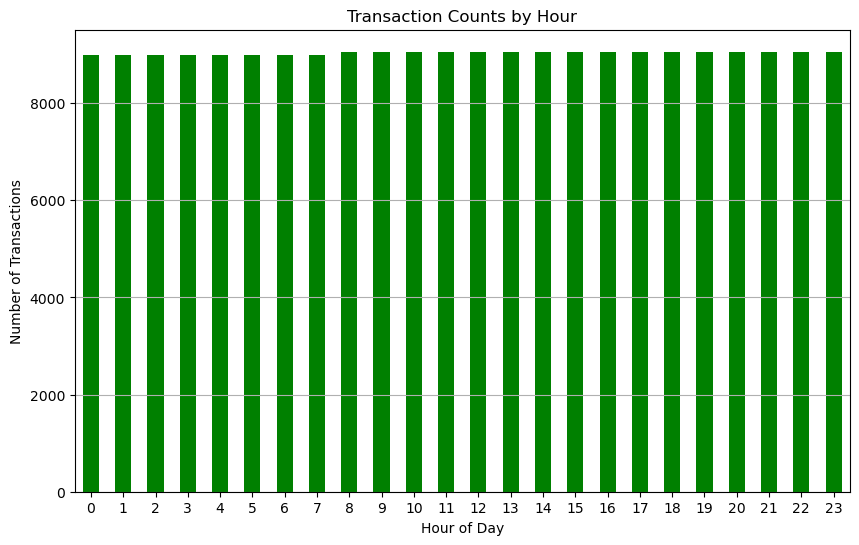

In [21]:
#Construct bar graph for total number of transactions per hour
hour_counts = new_financial_df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
hour_counts.plot(kind='bar', color='green')
plt.title('Transaction Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

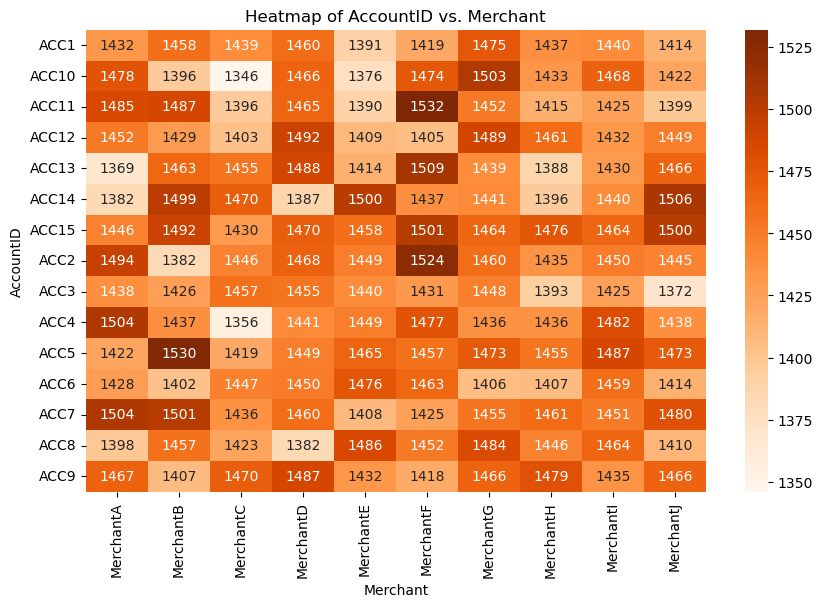

In [22]:
#Construct heat map to visualize total amounts of each combination of AccountID and Merchant (150 combinations)
pivot_table = pd.crosstab(new_financial_df['AccountID'], new_financial_df['Merchant'])

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='Oranges', fmt='d')
plt.title('Heatmap of AccountID vs. Merchant')
plt.xlabel('Merchant')
plt.ylabel('AccountID')
plt.show()

In [23]:
#print a sample of the first 10 values of the cleaned dataset with new variables added
new_financial_df.head(10)

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,AccountID/Merchant,AccountID/TransactionID,AccountID/Merchant/TransactionID,TransactionType/Merchant,Location/TransactionType,Merchant/Location,Minute,Hour,Day,Month,Amount_Partitions
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,ACC4_MerchantH,ACC4_TXN1127,ACC4_MerchantH_TXN1127,Purchase_MerchantH,Tokyo_Purchase,MerchantH_Tokyo,0,8,6,1,90001-100000
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,ACC10_MerchantH,ACC10_TXN1639,ACC10_MerchantH_TXN1639,Purchase_MerchantH,London_Purchase,MerchantH_London,1,8,6,1,10001-20000
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,ACC8_MerchantE,ACC8_TXN872,ACC8_MerchantE_TXN872,Withdrawal_MerchantE,London_Withdrawal,MerchantE_London,2,8,6,1,60001-70000
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,ACC6_MerchantE,ACC6_TXN1438,ACC6_MerchantE_TXN1438,Purchase_MerchantE,London_Purchase,MerchantE_London,3,8,6,1,0-10000
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,ACC6_MerchantI,ACC6_TXN1338,ACC6_MerchantI_TXN1338,Purchase_MerchantI,Los Angeles_Purchase,MerchantI_Los Angeles,4,8,6,1,0-10000
5,2023-01-01 08:05:00,TXN1083,ACC15,13957.99,MerchantC,Transfer,London,ACC15_MerchantC,ACC15_TXN1083,ACC15_MerchantC_TXN1083,Transfer_MerchantC,London_Transfer,MerchantC_London,5,8,6,1,10001-20000
6,2023-01-01 08:06:00,TXN832,ACC9,4654.58,MerchantC,Transfer,Tokyo,ACC9_MerchantC,ACC9_TXN832,ACC9_MerchantC_TXN832,Transfer_MerchantC,Tokyo_Transfer,MerchantC_Tokyo,6,8,6,1,0-10000
7,2023-01-01 08:07:00,TXN841,ACC7,1336.36,MerchantI,Withdrawal,San Francisco,ACC7_MerchantI,ACC7_TXN841,ACC7_MerchantI_TXN841,Withdrawal_MerchantI,San Francisco_Withdrawal,MerchantI_San Francisco,7,8,6,1,0-10000
8,2023-01-01 08:08:00,TXN777,ACC10,9776.23,MerchantD,Transfer,London,ACC10_MerchantD,ACC10_TXN777,ACC10_MerchantD_TXN777,Transfer_MerchantD,London_Transfer,MerchantD_London,8,8,6,1,0-10000
9,2023-01-01 08:09:00,TXN1479,ACC12,49522.74,MerchantC,Withdrawal,New York,ACC12_MerchantC,ACC12_TXN1479,ACC12_MerchantC_TXN1479,Withdrawal_MerchantC,New York_Withdrawal,MerchantC_New York,9,8,6,1,40001-50000


In [24]:
#print class, RangeIndex, columns, non-null count, data type, and memory usage information for the updated DataFrame
new_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216960 entries, 0 to 216959
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Timestamp                         216960 non-null  datetime64[ns]
 1   TransactionID                     216960 non-null  object        
 2   AccountID                         216960 non-null  object        
 3   Amount                            216960 non-null  float64       
 4   Merchant                          216960 non-null  object        
 5   TransactionType                   216960 non-null  object        
 6   Location                          216960 non-null  object        
 7   AccountID/Merchant                216960 non-null  object        
 8   AccountID/TransactionID           216960 non-null  object        
 9   AccountID/Merchant/TransactionID  216960 non-null  object        
 10  TransactionType/Merchant        

In [25]:
#print number of unique occurrences of newly created variables
print(f"Number of unique AccountID/Merchant: {new_financial_df['AccountID/Merchant'].nunique()}")
print(f"Number of unique AccountID/TransactionID: {new_financial_df['AccountID/TransactionID'].nunique()}")
print(f"Number of unique AccountID/Merchant/TransactionID: {new_financial_df['AccountID/Merchant/TransactionID'].nunique()}")
print(f"Number of unique TransactionType/Merchant: {new_financial_df['TransactionType/Merchant'].nunique()}")
print(f"Number of unique Location/TransactionType: {new_financial_df['Location/TransactionType'].nunique()}")
print(f"Number of unique Merchant/Location: {new_financial_df['Merchant/Location'].nunique()}")
print(f"Number of unique Minute: {new_financial_df['Minute'].nunique()}")
print(f"Number of unique Hour: {new_financial_df['Hour'].nunique()}")
print(f"Number of unique Day: {new_financial_df['Day'].nunique()}")
print(f"Number of unique Month: {new_financial_df['Month'].nunique()}")
print(f"Number of unique Amount_Partitions: {new_financial_df['Amount_Partitions'].nunique()}")

Number of unique AccountID/Merchant: 150
Number of unique AccountID/TransactionID: 29967
Number of unique AccountID/Merchant/TransactionID: 154226
Number of unique TransactionType/Merchant: 30
Number of unique Location/TransactionType: 15
Number of unique Merchant/Location: 50
Number of unique Minute: 60
Number of unique Hour: 24
Number of unique Day: 7
Number of unique Month: 5
Number of unique Amount_Partitions: 11


In [26]:
new_financial_df.to_csv('Week_2_Data.csv', index=False)

In [27]:
#WEEK 2 END

In [28]:
#WEEK 3 START

In [29]:
#describe numerical data to better understand these columns
new_financial_df.describe()

,Timestamp,Amount,Minute,Hour,Day,Month
count,216960,216960.000000,216960.000000,216960.000000,216960.000000,216960.000000
mean,2023-03-17 15:59:30,50090.025108,29.500000,11.517699,2.973451,3.017699
min,2023-01-01 08:00:00,10.510000,0.000000,0.000000,0.000000,1.000000
25%,2023-02-07 23:59:45,25061.242500,14.750000,6.000000,1.000000,2.000000
50%,2023-03-17 15:59:30,50183.980000,29.500000,12.000000,3.000000,3.000000
75%,2023-04-24 07:59:15,75080.460000,44.250000,18.000000,5.000000,4.000000
max,2023-05-31 23:59:00,978942.260000,59.000000,23.000000,6.000000,5.000000
std,NaN,29097.905016,17.318142,6.918770,2.008659,1.421907


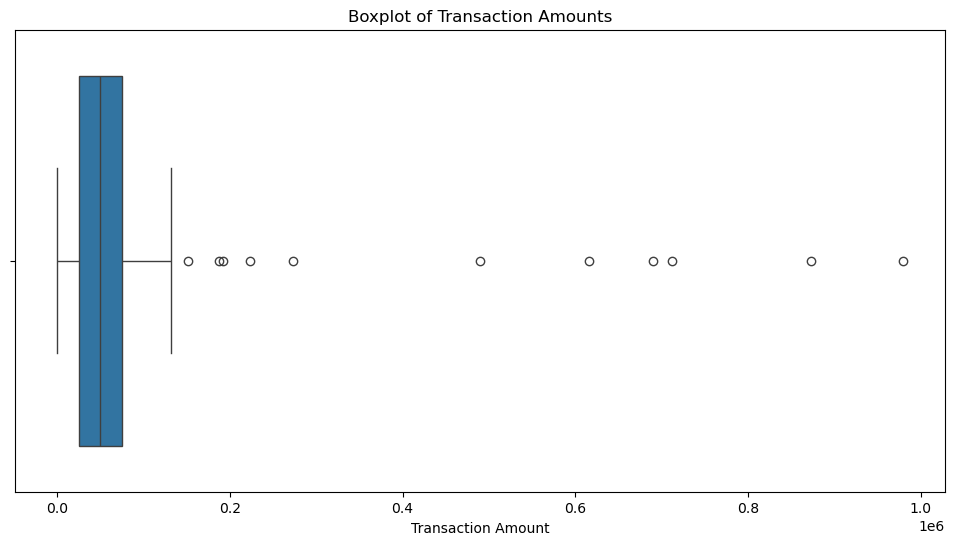

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Amount', data=new_financial_df)
plt.title('Boxplot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

In [31]:
#print counts of each unique value in each column of the DataFrame
for column in new_financial_df.columns:
    column_count = new_financial_df[column].value_counts()
    print(column_count)

Timestamp
2023-01-01 08:00:00    1
2023-04-11 18:57:00    1
2023-04-11 18:33:00    1
2023-04-11 18:34:00    1
2023-04-11 18:35:00    1
                      ..
2023-02-20 13:23:00    1
2023-02-20 13:24:00    1
2023-02-20 13:25:00    1
2023-02-20 13:26:00    1
2023-05-31 23:59:00    1
Name: count, Length: 216960, dtype: int64
TransactionID
TXN838     139
TXN1768    139
TXN1658    139
TXN1389    138
TXN340     137
          ... 
TXN60       79
TXN891      78
TXN605      78
TXN201      73
TXN799      70
Name: count, Length: 1999, dtype: int64
AccountID
ACC15    14701
ACC5     14630
ACC7     14581
ACC2     14553
ACC9     14527
ACC14    14458
ACC4     14456
ACC11    14446
ACC12    14421
ACC13    14421
ACC8     14402
ACC1     14365
ACC10    14362
ACC6     14352
ACC3     14285
Name: count, dtype: int64
Amount
18010.00    3
34588.69    3
74109.74    3
86099.64    3
7309.50     3
           ..
56652.57    1
36336.36    1
49174.76    1
71557.91    1
65004.99    1
Name: count, Length: 214687, dty

In [32]:
#list variables to be one-hot encoded

one_hot_encoding = [
    'AccountID/Merchant',
    'TransactionType',
    'Location',
    'Amount_Partitions'
]

# Apply one-hot encoding
new_financial_df_encoded = pd.get_dummies(new_financial_df, columns=one_hot_encoding)

# Display the first few rows of the encoded DataFrame
print(new_financial_df_encoded.head())


            Timestamp TransactionID AccountID    Amount   Merchant  \
0 2023-01-01 08:00:00       TXN1127      ACC4  95071.92  MerchantH   
1 2023-01-01 08:01:00       TXN1639     ACC10  15607.89  MerchantH   
2 2023-01-01 08:02:00        TXN872      ACC8  65092.34  MerchantE   
3 2023-01-01 08:03:00       TXN1438      ACC6     87.87  MerchantE   
4 2023-01-01 08:04:00       TXN1338      ACC6    716.56  MerchantI   

  AccountID/TransactionID AccountID/Merchant/TransactionID  \
0            ACC4_TXN1127           ACC4_MerchantH_TXN1127   
1           ACC10_TXN1639          ACC10_MerchantH_TXN1639   
2             ACC8_TXN872            ACC8_MerchantE_TXN872   
3            ACC6_TXN1438           ACC6_MerchantE_TXN1438   
4            ACC6_TXN1338           ACC6_MerchantI_TXN1338   

  TransactionType/Merchant Location/TransactionType      Merchant/Location  \
0       Purchase_MerchantH           Tokyo_Purchase        MerchantH_Tokyo   
1       Purchase_MerchantH          London_Purchas

In [33]:
#print DataFrame info to maintain understanding of DataFrame properties
new_financial_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216960 entries, 0 to 216959
Columns: 183 entries, Timestamp to Amount_Partitions_100001+
dtypes: bool(169), datetime64[ns](1), float64(1), int32(4), object(8)
memory usage: 54.8+ MB


In [34]:
#Retrieve one-hot encoded columns
'''
I originally included this correlation analysis although I removed it due to its difficult to read output that took up a significant portion of the project's output (over 200 pages of correlation output)
account_merchant_columns = [col for col in new_financial_df_encoded.columns if 'AccountID/Merchant_' in col]
transaction_type_columns = [col for col in new_financial_df_encoded.columns if 'TransactionType_' in col]
location_columns = [col for col in new_financial_df_encoded.columns if 'Location_' in col]
amount_partitions_columns = [col for col in new_financial_df_encoded.columns if 'Amount_Partitions_' in col]

# Create a dictionary to store correlations
correlation_results = {}

# Iterate through each pair of one-hot encoded columns to compute correlations
for account_merchant in account_merchant_columns:
    for transaction_type in transaction_type_columns:
        correlation1 = new_financial_df_encoded[account_merchant].corr(new_financial_df_encoded[transaction_type])
        correlation_results[(account_merchant, transaction_type)] = correlation1

for account_merchant in account_merchant_columns:
    for location in location_columns:
        correlation2 = new_financial_df_encoded[account_merchant].corr(new_financial_df_encoded[location])
        correlation_results[(account_merchant, location)] = correlation2

for account_merchant in account_merchant_columns:
    for amount_partitions in amount_partitions_columns:
        correlation3 = new_financial_df_encoded[account_merchant].corr(new_financial_df_encoded[amount_partitions])
        correlation_results[(account_merchant, amount_partitions)] = correlation3

for transaction_type in transaction_type_columns:
    for location in location_columns:
        correlation4 = new_financial_df_encoded[transaction_type].corr(new_financial_df_encoded[location])
        correlation_results[(transaction_type, location)] = correlation4

for transaction_type in transaction_type_columns:
    for amount_partitions in amount_partitions_columns:
        correlation5 = new_financial_df_encoded[transaction_type].corr(new_financial_df_encoded[amount_partitions])
        correlation_results[(transaction_type, amount_partitions)] = correlation5

for location in location_columns:
    for amount_partitions in amount_partitions_columns:
        correlation6 = new_financial_df_encoded[location].corr(new_financial_df_encoded[amount_partitions])
        correlation_results[(location, amount_partitions)] = correlation6
        
# Display the results
for (account_merchant, transaction_type), correlation1 in correlation_results.items():
    print(f'Correlation between {account_merchant} and {transaction_type}: {correlation1}')
    
for (account_merchant, location), correlation2 in correlation_results.items():
    print(f'Correlation between {account_merchant} and {location}: {correlation2}')
    
for (accout_merchant, amount_partitions), correlation3 in correlation_results.items():
    print(f'Correlation between {account_merchant} and {amount_partitions}: {correlation3}')
    
for (transaction_type, location), correlation4 in correlation_results.items():
    print(f'Correlation between {transaction_type} and {location}: {correlation4}')
    
for (transaction_type, amount_partitions), correlation5 in correlation_results.items():
    print(f'Correlation between {transaction_type} and {amount_partitions}: {correlation5}')
    
for (location, amount_partitions), correlation6 in correlation_results.items():
    print(f'Correlation between {location} and {amount_partitions}: {correlation6}')
    '''

"\nI originally included this correlation analysis although I removed it due to its difficult to read output that took up a significant portion of the project's output (over 200 pages of correlation output)\naccount_merchant_columns = [col for col in new_financial_df_encoded.columns if 'AccountID/Merchant_' in col]\ntransaction_type_columns = [col for col in new_financial_df_encoded.columns if 'TransactionType_' in col]\nlocation_columns = [col for col in new_financial_df_encoded.columns if 'Location_' in col]\namount_partitions_columns = [col for col in new_financial_df_encoded.columns if 'Amount_Partitions_' in col]\n\n# Create a dictionary to store correlations\ncorrelation_results = {}\n\n# Iterate through each pair of one-hot encoded columns to compute correlations\nfor account_merchant in account_merchant_columns:\n    for transaction_type in transaction_type_columns:\n        correlation1 = new_financial_df_encoded[account_merchant].corr(new_financial_df_encoded[transaction_type

In [35]:
'''
correlation_matrix = new_financial_df_encoded[account_merchant_columns + transaction_type_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap between AccountID/Merchant and TransactionType')
plt.show()
'''

'\ncorrelation_matrix = new_financial_df_encoded[account_merchant_columns + transaction_type_columns].corr()\n\n# Create a heatmap\nplt.figure(figsize=(12, 8))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', square=True)\nplt.title(\'Correlation Heatmap between AccountID/Merchant and TransactionType\')\nplt.show()\n'

In [36]:
'''
correlation_matrix = new_financial_df_encoded[transaction_type_columns + location_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap between TransactionType and Location')
plt.show()
'''

'\ncorrelation_matrix = new_financial_df_encoded[transaction_type_columns + location_columns].corr()\n\n# Create a heatmap\nplt.figure(figsize=(12, 8))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', square=True)\nplt.title(\'Correlation Heatmap between TransactionType and Location\')\nplt.show()\n'

In [37]:
'''
correlation_matrix = new_financial_df_encoded[transaction_type_columns + amount_partitions_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap between TransactionType and Amount_Partitions')
plt.show()
'''

'\ncorrelation_matrix = new_financial_df_encoded[transaction_type_columns + amount_partitions_columns].corr()\n\n# Create a heatmap\nplt.figure(figsize=(12, 8))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', square=True)\nplt.title(\'Correlation Heatmap between TransactionType and Amount_Partitions\')\nplt.show()\n'

In [38]:
#create train set (70%) and temporary other set (30%)
train_df, temp_df = train_test_split(new_financial_df, test_size=0.30, random_state=1)

#split the leftover temp set into validation and test sets (50% of 30% each- 15% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

#verify shape of train, validation, and test DataFrames
print(f'Training set shape: {train_df.shape}')
print(f'Validation set shape: {validation_df.shape}')
print(f'Test set shape: {test_df.shape}')

Training set shape: (151872, 18)
Validation set shape: (32544, 18)
Test set shape: (32544, 18)


In [39]:
'''
# Save the train set
train_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [40]:
#END WEEK 3

In [41]:
#START WEEK 4

In [42]:
#Apply log transformation to Amount variable
train_df['Amount'] = np.log1p(train_df['Amount'])

In [43]:
#identify trends in volume of transactions per day per account
train_df['Date'] = train_df['Timestamp'].dt.date
account_activity = train_df.groupby(['Date', 'AccountID']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
).reset_index()

print(account_activity)

            Date AccountID  total_transactions  total_amount  average_amount  \
0     2023-01-01      ACC1                  45    465.643415       10.347631   
1     2023-01-01     ACC10                  39    401.756535       10.301450   
2     2023-01-01     ACC11                  45    466.881311       10.375140   
3     2023-01-01     ACC12                  48    494.428680       10.300598   
4     2023-01-01     ACC13                  51    537.094450       10.531264   
...          ...       ...                 ...           ...             ...   
2260  2023-05-31      ACC5                  79    829.043252       10.494218   
2261  2023-05-31      ACC6                  55    572.603696       10.410976   
2262  2023-05-31      ACC7                  61    652.687543       10.699796   
2263  2023-05-31      ACC8                  61    636.764154       10.438757   
2264  2023-05-31      ACC9                  76    804.576583       10.586534   

      max_transaction  min_transaction 

In [44]:
#identify trends in volume of transactions per day per merchant
merchant_activity = train_df.groupby(['Date', 'Merchant']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
).reset_index()

print(merchant_activity)

            Date   Merchant  total_transactions  total_amount  average_amount  \
0     2023-01-01  MerchantA                  65    693.193900       10.664522   
1     2023-01-01  MerchantB                  71    738.537511       10.401937   
2     2023-01-01  MerchantC                  83    862.766604       10.394778   
3     2023-01-01  MerchantD                  77    807.919846       10.492466   
4     2023-01-01  MerchantE                  51    529.932174       10.390827   
...          ...        ...                 ...           ...             ...   
1505  2023-05-31  MerchantF                  98   1044.751467       10.660729   
1506  2023-05-31  MerchantG                 104   1091.297405       10.493244   
1507  2023-05-31  MerchantH                 100   1052.697256       10.526973   
1508  2023-05-31  MerchantI                  98   1024.712858       10.456254   
1509  2023-05-31  MerchantJ                  94   1000.775385       10.646547   

      max_transaction  min_

In [45]:
#identify trends in volume of transactions per day by location
location_activity = train_df.groupby(['Date', 'Location']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
   
).reset_index()

print(location_activity)

           Date       Location  total_transactions  total_amount  \
0    2023-01-01         London                 146   1530.237727   
1    2023-01-01    Los Angeles                 139   1454.136479   
2    2023-01-01       New York                 135   1402.617642   
3    2023-01-01  San Francisco                 138   1445.854505   
4    2023-01-01          Tokyo                 133   1410.359817   
..          ...            ...                 ...           ...   
750  2023-05-31         London                 205   2186.373655   
751  2023-05-31    Los Angeles                 191   2004.248091   
752  2023-05-31       New York                 213   2215.559017   
753  2023-05-31  San Francisco                 187   1982.163977   
754  2023-05-31          Tokyo                 197   2080.626500   

     average_amount  max_transaction  min_transaction  
0         10.481080        11.502063         5.491950  
1         10.461414        11.504645         3.548180  
2         10.38

In [46]:
train_df.head(5)

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,AccountID/Merchant,AccountID/TransactionID,AccountID/Merchant/TransactionID,TransactionType/Merchant,Location/TransactionType,Merchant/Location,Minute,Hour,Day,Month,Amount_Partitions,Date
9230,2023-01-07 17:50:00,TXN1858,ACC12,9.064231,MerchantB,Withdrawal,London,ACC12_MerchantB,ACC12_TXN1858,ACC12_MerchantB_TXN1858,Withdrawal_MerchantB,London_Withdrawal,MerchantB_London,50,17,5,1,0-10000,2023-01-07
41764,2023-01-30 08:04:00,TXN76,ACC9,10.757187,MerchantJ,Transfer,London,ACC9_MerchantJ,ACC9_TXN76,ACC9_MerchantJ_TXN76,Transfer_MerchantJ,London_Transfer,MerchantJ_London,4,8,0,1,40001-50000,2023-01-30
136513,2023-04-06 03:13:00,TXN847,ACC11,10.996651,MerchantD,Transfer,New York,ACC11_MerchantD,ACC11_TXN847,ACC11_MerchantD_TXN847,Transfer_MerchantD,New York_Transfer,MerchantD_New York,13,3,3,4,50001-60000,2023-04-06
158548,2023-04-21 10:28:00,TXN852,ACC12,11.204528,MerchantI,Withdrawal,Los Angeles,ACC12_MerchantI,ACC12_TXN852,ACC12_MerchantI_TXN852,Withdrawal_MerchantI,Los Angeles_Withdrawal,MerchantI_Los Angeles,28,10,4,4,70001-80000,2023-04-21
9929,2023-01-08 05:29:00,TXN1822,ACC1,9.295688,MerchantF,Withdrawal,London,ACC1_MerchantF,ACC1_TXN1822,ACC1_MerchantF_TXN1822,Withdrawal_MerchantF,London_Withdrawal,MerchantF_London,29,5,6,1,10001-20000,2023-01-08


In [47]:
#drop columns with too many unique values to analyze efficiently
train_df.drop(columns=['TransactionID', 'AccountID/TransactionID', 'AccountID/Merchant/TransactionID', 'AccountID/Merchant', 'TransactionType/Merchant', 'Location/TransactionType', 'Merchant/Location'], inplace=True)

In [48]:
train_df.head(5)

,Timestamp,AccountID,Amount,Merchant,TransactionType,Location,Minute,Hour,Day,Month,Amount_Partitions,Date
9230,2023-01-07 17:50:00,ACC12,9.064231,MerchantB,Withdrawal,London,50,17,5,1,0-10000,2023-01-07
41764,2023-01-30 08:04:00,ACC9,10.757187,MerchantJ,Transfer,London,4,8,0,1,40001-50000,2023-01-30
136513,2023-04-06 03:13:00,ACC11,10.996651,MerchantD,Transfer,New York,13,3,3,4,50001-60000,2023-04-06
158548,2023-04-21 10:28:00,ACC12,11.204528,MerchantI,Withdrawal,Los Angeles,28,10,4,4,70001-80000,2023-04-21
9929,2023-01-08 05:29:00,ACC1,9.295688,MerchantF,Withdrawal,London,29,5,6,1,10001-20000,2023-01-08


In [49]:
#One hot encode categorical variables
train_encoded_df = pd.get_dummies(train_df, columns=['AccountID', 'Merchant', 'TransactionType', 'Location', 'Amount_Partitions', 'Day'])

In [50]:
train_encoded_df.head()

,Timestamp,Amount,Minute,Hour,Month,Date,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,...,Amount_Partitions_80001-90000,Amount_Partitions_90001-100000,Amount_Partitions_100001+,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
9230,2023-01-07 17:50:00,9.064231,50,17,1,2023-01-07,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
41764,2023-01-30 08:04:00,10.757187,4,8,1,2023-01-30,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
136513,2023-04-06 03:13:00,10.996651,13,3,4,2023-04-06,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
158548,2023-04-21 10:28:00,11.204528,28,10,4,2023-04-21,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
9929,2023-01-08 05:29:00,9.295688,29,5,1,2023-01-08,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


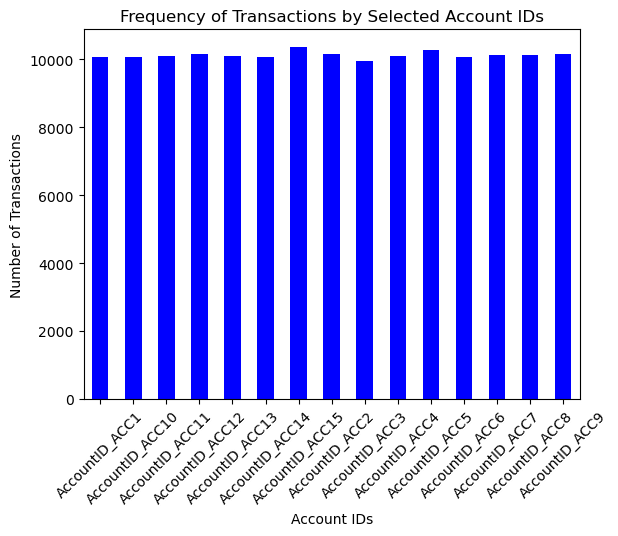

In [51]:
#Visualize encoded AccountID Data
account_columns = [col for col in train_encoded_df.columns if col.startswith('AccountID_')]
account_counts = train_encoded_df[account_columns].sum()
account_counts.plot(kind='bar', color='blue')
plt.title('Frequency of Transactions by Selected Account IDs')
plt.xlabel('Account IDs')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

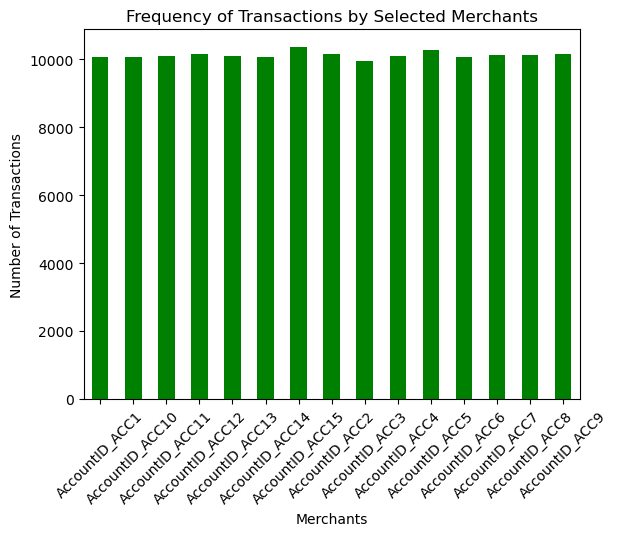

In [52]:
#Visualize encoded AccountID Data
merchant_columns = [col for col in train_encoded_df.columns if col.startswith('Merchant_')]
merchant_counts = train_encoded_df[account_columns].sum()
merchant_counts.plot(kind='bar', color='green')
plt.title('Frequency of Transactions by Selected Merchants')
plt.xlabel('Merchants')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

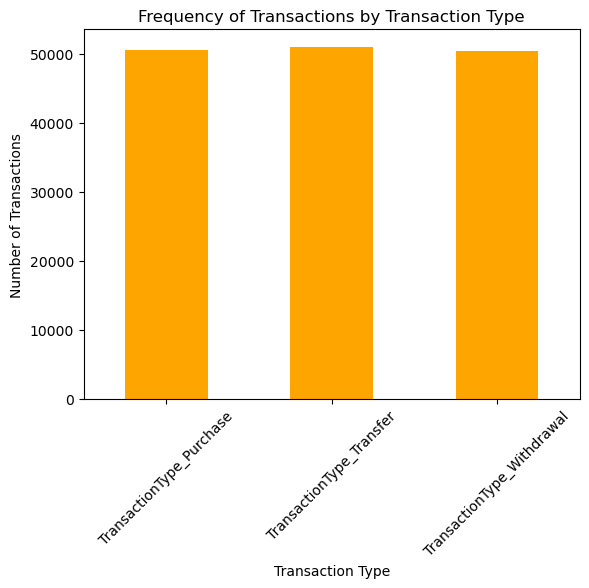

In [53]:
#Visualize encoded AccountID Data
TransactionType_columns = [col for col in train_encoded_df.columns if col.startswith('TransactionType_')]
TransactionType_counts = train_encoded_df[TransactionType_columns].sum()
TransactionType_counts.plot(kind='bar', color='orange')
plt.title('Frequency of Transactions by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

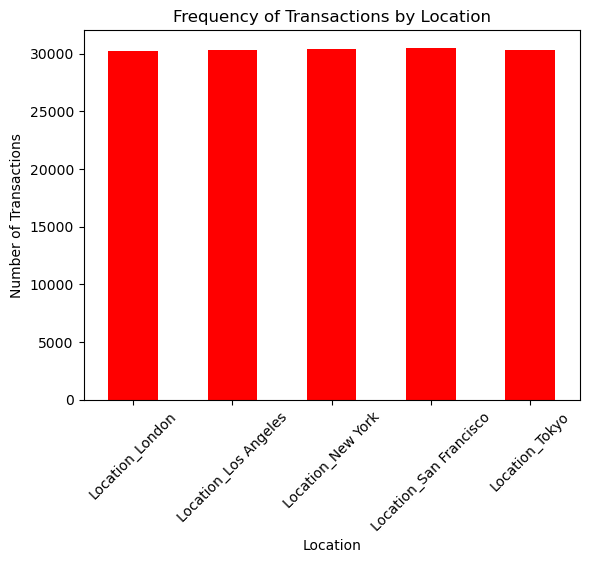

In [54]:
#Visualize encoded AccountID Data
location_columns = [col for col in train_encoded_df.columns if col.startswith('Location_')]
location_counts = train_encoded_df[location_columns].sum()
location_counts.plot(kind='bar', color='red')
plt.title('Frequency of Transactions by Location')
plt.xlabel('Location')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

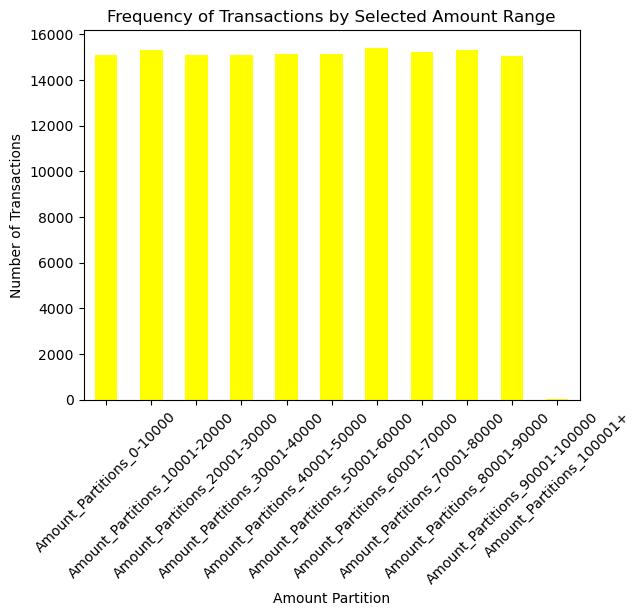

In [55]:
#Visualize encoded AccountID Data
amount_partitions_columns = [col for col in train_encoded_df.columns if col.startswith('Amount_Partitions_')]
amount_partitions_counts = train_encoded_df[amount_partitions_columns].sum()
amount_partitions_counts.plot(kind='bar', color='yellow')
plt.title('Frequency of Transactions by Selected Amount Range')
plt.xlabel('Amount Partition')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

In [56]:
#Perform same preprocessing steps on both Validation and Test Sets
#Apply log transformation to Amount variable
validation_df['Amount'] = np.log1p(validation_df['Amount'])
test_df['Amount'] = np.log1p(test_df['Amount'])

In [57]:
#identify trends in volume of transactions per day per account (not printing results to reduce potential for bias)
validation_df['Date'] = validation_df['Timestamp'].dt.date
val_account_activity = validation_df.groupby(['Date', 'AccountID']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
).reset_index()

In [58]:
#identify trends in volume of transactions per day per account
test_df['Date'] = test_df['Timestamp'].dt.date
test_account_activity = test_df.groupby(['Date', 'AccountID']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
).reset_index()

In [59]:
#identify trends in volume of transactions per day per merchant
val_merchant_activity = validation_df.groupby(['Date', 'Merchant']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
).reset_index()

In [60]:
#identify trends in volume of transactions per day per merchant
test_merchant_activity = test_df.groupby(['Date', 'Merchant']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
).reset_index()

In [61]:
#identify trends in volume of transactions per day by location
val_location_activity = validation_df.groupby(['Date', 'Location']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
   
).reset_index()

In [62]:
#identify trends in volume of transactions per day by location
test_location_activity = test_df.groupby(['Date', 'Location']).agg(
    total_transactions=('Amount', 'count'),
    total_amount=('Amount', 'sum'),
    average_amount=('Amount', 'mean'),
    max_transaction=('Amount', 'max'),
    min_transaction=('Amount', 'min'),
   
).reset_index()

In [63]:
#drop columns with too many unique values to analyze efficiently
validation_df.drop(columns=['TransactionID', 'AccountID/TransactionID', 'AccountID/Merchant/TransactionID', 'AccountID/Merchant', 'TransactionType/Merchant', 'Location/TransactionType', 'Merchant/Location'], inplace=True)
#drop columns with too many unique values to analyze efficiently
test_df.drop(columns=['TransactionID', 'AccountID/TransactionID', 'AccountID/Merchant/TransactionID', 'AccountID/Merchant', 'TransactionType/Merchant', 'Location/TransactionType', 'Merchant/Location'], inplace=True)

In [64]:
#One hot encode categorical variables
validation_encoded_df = pd.get_dummies(validation_df, columns=['AccountID', 'Merchant', 'TransactionType', 'Location', 'Amount_Partitions', 'Day'])
test_encoded_df = pd.get_dummies(test_df, columns=['AccountID', 'Merchant', 'TransactionType', 'Location', 'Amount_Partitions', 'Day'])

In [65]:
'''
# Save the train set
train_encoded_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_encoded_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_encoded_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_encoded_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_encoded_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_encoded_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [66]:
#END WEEK 4

In [67]:
#START WEEK 5

In [68]:
# Define bins and labels for groups of hours of the day
bins = [0, 5, 11, 17, 23]
labels = ['0-5', '6-11', '12-17', '18-23']

# Create a new column 'Hour_Group' that bucketizes data into four segments of the day
train_encoded_df['Hour_Group'] = pd.cut(train_encoded_df['Hour'], bins=bins, labels=labels, right=True)

In [69]:
# Assign values of Hour_Group to each AccountID
for account in range(1, 15):
    AccountID_column = f'AccountID_ACC{account}'
    if AccountID_column in train_encoded_df.columns:
        train_encoded_df[f'Hour_Group_{account}'] = train_encoded_df.apply(
            lambda row: row['Hour_Group'] if row[AccountID_column] == 1 else None,
            axis=1
        )

In [70]:
#Repeat this action to assign values of Hour_Group to each Merchant, TransactionType, and Location
def create_hour_group_columns(train_encoded_df, variable_info, hour_group_column='Hour_Group'):
    for prefix, count in variable_info.items():
        for i in range(1, count + 1):
            column_name = f'{prefix}{i}'
            if column_name in train_encoded_df.columns:
                train_encoded_df[f'{column_name}_{hour_group_column}'] = train_encoded_df.apply(
                    lambda row: row[hour_group_col] if row[column_name] == 1 else None,
                    axis=1
                )

# Define the variable prefixes and their respective counts
variable_info = {
    'Merchant_Merchant': 10,  # Merchants A-J
    'TransactionType_': 3,     # Purchase, Transfer, Withdrawal
    'Location_': 5              # London, Los Angeles, New York, San Francisco, Tokyo
}

# Call the function to create the new columns
create_hour_group_columns(train_encoded_df, variable_info)


In [71]:
# Define a function to calculate mean and standard deviation for each one-hot encoded account by iterating across each of the 15 one-hot encoded accounts
def calculate_stats(train_encoded_df, account_prefix='AccountID_ACC', num_accounts=15):
    stats = {}
    
    for i in range(1, num_accounts + 1):
        account_columns = f'{account_prefix}{i}'
        # Only include amounts where the specific account value is true (1 as its binary representation)
        account_data = train_encoded_df[train_encoded_df[account_columns] == 1]['Amount']

        # Perform the mean and standard deviatoin calculations
        mean = account_data.mean()
        std = account_data.std()
        
        # Store the mean and standard deviation for each account
        stats[f'AccountID_ACC{i}'] = {'mean': mean, 'std': std}
    
    return stats

# Call the function to calculate mean and standard deviation for AccountID_ACC1 to AccountID_ACC15
account_stats = calculate_stats(train_encoded_df)

# Add mean and standard deviation columns to train_encoded_df
for account, values in account_stats.items():
    train_encoded_df[f'{account}_mean'] = values['mean']
    train_encoded_df[f'{account}_std'] = values['std']


In [72]:
# Create a new column for deviation from mean for each transaction
train_encoded_df['Deviation_From_Mean'] = 0.0

# Loop through each account and calculate the deviation
for i in range(1, 15):
    account_columns = f'AccountID_ACC{i}'
    mean_columns = f'AccountID_ACC{i}_mean'
    std_columns = f'AccountID_ACC{i}_std'

    # Calculate the deviation only for transactions in the current account
    condition = train_encoded_df[account_columns] == 1
    
    # Calculate number of standard deviations of a transaction's Amount value from its Account's Amount mean
    train_encoded_df.loc[condition, 'Deviation_From_Mean'] = (
        (train_encoded_df.loc[condition, 'Amount'] - train_encoded_df.loc[condition, mean_columns]
    ) / train_encoded_df.loc[condition, std_columns])

In [73]:
train_encoded_df.head()

,Timestamp,Amount,Minute,Hour,Month,Date,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,...,AccountID_ACC11_std,AccountID_ACC12_mean,AccountID_ACC12_std,AccountID_ACC13_mean,AccountID_ACC13_std,AccountID_ACC14_mean,AccountID_ACC14_std,AccountID_ACC15_mean,AccountID_ACC15_std,Deviation_From_Mean
9230,2023-01-07 17:50:00,9.064231,50,17,1,2023-01-07,False,False,False,True,...,0.990663,10.516095,0.996039,10.523663,0.988999,10.504439,1.007835,10.530108,0.987759,-1.457638
41764,2023-01-30 08:04:00,10.757187,4,8,1,2023-01-30,False,False,False,False,...,0.990663,10.516095,0.996039,10.523663,0.988999,10.504439,1.007835,10.530108,0.987759,0.248660
136513,2023-04-06 03:13:00,10.996651,13,3,4,2023-04-06,False,False,True,False,...,0.990663,10.516095,0.996039,10.523663,0.988999,10.504439,1.007835,10.530108,0.987759,0.498987
158548,2023-04-21 10:28:00,11.204528,28,10,4,2023-04-21,False,False,False,True,...,0.990663,10.516095,0.996039,10.523663,0.988999,10.504439,1.007835,10.530108,0.987759,0.691171
9929,2023-01-08 05:29:00,9.295688,29,5,1,2023-01-08,True,False,False,False,...,0.990663,10.516095,0.996039,10.523663,0.988999,10.504439,1.007835,10.530108,0.987759,-1.204878


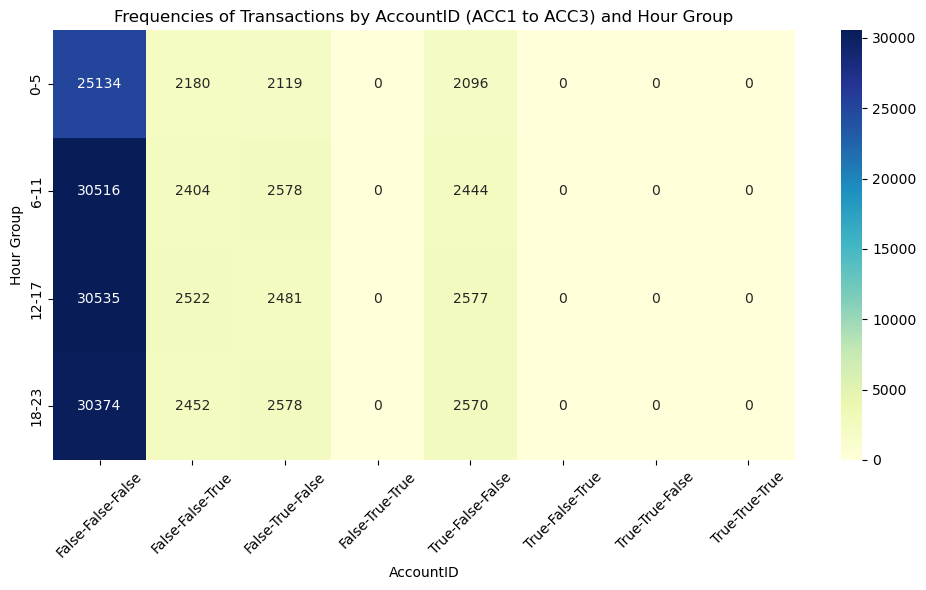

In [74]:
def plot_interaction_frequencies(df, account_columns, hour_group_column):
    
    # Create a new DataFrame to hold the frequencies of specific accounts' transactions occurring in certain hour groups
    interaction_frequencies = df.groupby(account_columns + [hour_group_column], observed=False).size().reset_index(name='Frequency')

    # Create a pivot table for better visualization
    pivot_table = interaction_frequencies.pivot(index=hour_group_column, columns=account_columns, values='Frequency').fillna(0)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f")
    plt.title('Frequencies of Transactions by AccountID (ACC1 to ACC3) and Hour Group')
    plt.xlabel('AccountID')
    plt.ylabel('Hour Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

hour_group_column = 'Hour_Group'
account_columns = [f'AccountID_ACC{i}' for i in range(1, 4)]  # Only ACC1 to ACC3 for better visualization purposes

# Call the function
plot_interaction_frequencies(train_encoded_df, account_columns, hour_group_column)

In [75]:
train_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151872 entries, 9230 to 128037
Columns: 103 entries, Timestamp to Deviation_From_Mean
dtypes: bool(51), category(1), datetime64[ns](1), float64(32), int32(3), object(15)
memory usage: 66.0+ MB


In [76]:
# Create a list of prefixes for our one-hot columns
one_hot_prefixes = ['AccountID_', 'Merchant_', 'TransactionType_', 'Location_', 'Amount_Partitions_', 'Day']

# Create a variable that stores the columns starting with the respective prefixes from our list
binary = train_encoded_df.columns.str.startswith(tuple(one_hot_prefixes))

# Convert TRUE/FALSE entries to 1/0 entries with exception handling condition
if binary.any():
    try:
        # Check data types of the selected columns
        for col in train_encoded_df.columns[binary]:
            # Get the data type of the column
            column_dtype = train_encoded_df[col].dtype
            
            if column_dtype != 'int32':
                # Convert directly to int if boolean
                if column_dtype == 'bool':
                    train_encoded_df[col] = train_encoded_df[col].astype(int)
                else:
                    # If it's not bool, you can simply ensure it's int
                    train_encoded_df[col] = train_encoded_df[col].astype('int32')
    except Exception as e:
        print(f"Potential incompatible dtype error during conversion: {e}")
else:
    print("No one-hot encoded columns found with the specified prefixes.")


In [77]:
train_encoded_df.head()

,Timestamp,Amount,Minute,Hour,Month,Date,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,...,AccountID_ACC11_std,AccountID_ACC12_mean,AccountID_ACC12_std,AccountID_ACC13_mean,AccountID_ACC13_std,AccountID_ACC14_mean,AccountID_ACC14_std,AccountID_ACC15_mean,AccountID_ACC15_std,Deviation_From_Mean
9230,2023-01-07 17:50:00,9.064231,50,17,1,2023-01-07,0,0,0,1,...,0,10,0,10,0,10,1,10,0,-1.457638
41764,2023-01-30 08:04:00,10.757187,4,8,1,2023-01-30,0,0,0,0,...,0,10,0,10,0,10,1,10,0,0.248660
136513,2023-04-06 03:13:00,10.996651,13,3,4,2023-04-06,0,0,1,0,...,0,10,0,10,0,10,1,10,0,0.498987
158548,2023-04-21 10:28:00,11.204528,28,10,4,2023-04-21,0,0,0,1,...,0,10,0,10,0,10,1,10,0,0.691171
9929,2023-01-08 05:29:00,9.295688,29,5,1,2023-01-08,1,0,0,0,...,0,10,0,10,0,10,1,10,0,-1.204878


In [78]:
# Create lists for AccountID, Merchant, TransactionType, Location, and Hour Groups
account_ids = [f'AccountID_ACC{i}' for i in range(1, 15)]  # AccountID's 1 to 15
merchants = [f'Merchant_Merchant{chr(i)}' for i in range(ord('A'), ord('J') + 1)]  # Merchants A to J
transaction_types = ['TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal']
locations = ['Location_London', 'Location_Los Angeles', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo']
hour_groups = [f'Hour_Group_{i}' for i in range(1, 15)]

def encode_columns(df, columns):
    encoder = LabelEncoder()
    encoded_columns = {}
    
    for column in columns:
        if column in df.columns:
            encoded_columns[column] = encoder.fit_transform(df[column])
        else:
            print(f"Warning: {column} not found in DataFrame.")
    return encoded_columns

# Encode each variable
encoded_account_ids = encode_columns(train_encoded_df, account_ids)
encoded_merchants = encode_columns(train_encoded_df, merchants)
encoded_transaction_types = encode_columns(train_encoded_df, transaction_types)
encoded_locations = encode_columns(train_encoded_df, locations)
encoded_hour_groups = encode_columns(train_encoded_df, hour_groups)

# Assign the encoded values back to the DataFrame
for account_id, encoded_values in encoded_account_ids.items():
    train_encoded_df[account_id] = encoded_values

for merchant, encoded_values in encoded_merchants.items():
    train_encoded_df[merchant] = encoded_values

for transaction_type, encoded_values in encoded_transaction_types.items():
    train_encoded_df[transaction_type] = encoded_values

for location, encoded_values in encoded_locations.items():
    train_encoded_df[location] = encoded_values

for hour_group, encoded_values in encoded_hour_groups.items():
    train_encoded_df[hour_group] = encoded_values

# Prepare Inputs for Embedding
numerical_input = Input(shape=(1,), name='numerical_input')
account_input = Input(shape=(1,), name='account_input')
merchant_input = Input(shape=(1,), name='merchant_input')
transaction_input = Input(shape=(1,), name='transaction_input')
location_input = Input(shape=(1,), name='location_input')
hour_group_input = Input(shape=(1,), name='hour_group_input')

# Create Embedding Layers
embedding_dim = 8
num_accounts = len(account_ids)
num_merchants = len(merchants)
num_transaction_types = len(transaction_types)
num_locations = len(locations)
num_hour_groups = len(hour_groups)

# Embeddings for each one-hot encoded category
account_embedding = Embedding(input_dim=num_accounts, output_dim=embedding_dim)(account_input)
merchant_embedding = Embedding(input_dim=num_merchants, output_dim=embedding_dim)(merchant_input)
transaction_embedding = Embedding(input_dim=num_transaction_types, output_dim=embedding_dim)(transaction_input)
location_embedding = Embedding(input_dim=num_locations, output_dim=embedding_dim)(location_input)
hour_group_embedding = Embedding(input_dim=num_hour_groups, output_dim=embedding_dim)(hour_group_input)

# Flatten the embeddings to make a one-dimensional array representation of the variables
flattened_account = Flatten()(account_embedding)
flattened_merchant = Flatten()(merchant_embedding)
flattened_transaction = Flatten()(transaction_embedding)
flattened_location = Flatten()(location_embedding)
flattened_hour_group = Flatten()(hour_group_embedding)

# Concatenate inputs to a single output
concat = Concatenate()([numerical_input, flattened_account, flattened_merchant, flattened_transaction, flattened_location, flattened_hour_group])

# Add Dense Layers to interconnect previous layers
output = Dense(1, activation='sigmoid')(concat)

# Build the Model
model = Model(inputs=[numerical_input, account_input, merchant_input, transaction_input, location_input, hour_group_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare input data for model training
X_numerical = train_encoded_df[['Amount']].values
X_accounts = train_encoded_df[account_ids].values.argmax(axis=1).reshape(-1, 1)  # Get index for account input
X_merchants = train_encoded_df[merchants].values.argmax(axis=1).reshape(-1, 1)
X_transaction_types = train_encoded_df[transaction_types].values.argmax(axis=1).reshape(-1, 1)
X_locations = train_encoded_df[locations].values.argmax(axis=1).reshape(-1, 1)
X_hour_groups = train_encoded_df[hour_groups].values.argmax(axis=1).reshape(-1, 1)

# Make sure to pass the inputs as a list
model.fit([X_numerical, X_accounts, X_merchants, X_transaction_types, X_locations, X_hour_groups], 
          np.zeros(X_numerical.shape[0]), 
          epochs=1, 
          batch_size=16)

# Create a model to get the embedding outputs
embedding_model = Model(inputs=[account_input, merchant_input, transaction_input, location_input, hour_group_input], 
                         outputs=[account_embedding, merchant_embedding, transaction_embedding, location_embedding, hour_group_embedding])

# Get the embedding outputs
embedding_output = embedding_model.predict([X_accounts, X_merchants, X_transaction_types, X_locations, X_hour_groups])

# Store the embeddings in a DataFrame
embedding_df = pd.DataFrame({
    'Account_Embeddings': list(embedding_output[0]),
    'Merchant_Embeddings': list(embedding_output[1]),
    'Transaction_Embeddings': list(embedding_output[2]),
    'Location_Embeddings': list(embedding_output[3]),
    'Hour_Group_Embeddings': list(embedding_output[4])
})

# Combine with the original DataFrame if needed
train_embeddings_df = pd.concat([train_encoded_df.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)


C:\Users\brady\OneDrive\Apps\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['numerical_input', 'account_input', 'merchant_input', 'transaction_input', 'location_input', 'hour_group_input']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


9492/9492 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0077
  85/4746 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step 

C:\Users\brady\OneDrive\Apps\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['account_input', 'merchant_input', 'transaction_input', 'location_input', 'hour_group_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


4746/4746 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [79]:
train_embeddings_df.head()

,Timestamp,Amount,Minute,Hour,Month,Date,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,...,AccountID_ACC14_mean,AccountID_ACC14_std,AccountID_ACC15_mean,AccountID_ACC15_std,Deviation_From_Mean,Account_Embeddings,Merchant_Embeddings,Transaction_Embeddings,Location_Embeddings,Hour_Group_Embeddings
0,2023-01-07 17:50:00,9.064231,50,17,1,2023-01-07,0,0,0,1,...,10,1,10,0,-1.457638,"[[-0.19626556, 0.1890982, 0.13639745, 0.199321...","[[0.15362723, -0.23974006, -0.24907297, -0.238...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
1,2023-01-30 08:04:00,10.757187,4,8,1,2023-01-30,0,0,0,0,...,10,1,10,0,0.248660,"[[-0.1922804, 0.17092733, 0.117064044, 0.19126...","[[0.1907043, -0.25553516, -0.21779259, -0.2310...","[[0.8383179, 0.47672793, -0.37692118, -0.64975...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
2,2023-04-06 03:13:00,10.996651,13,3,4,2023-04-06,0,0,1,0,...,10,1,10,0,0.498987,"[[-0.10577693, 0.14766376, 0.099778645, 0.1798...","[[0.1438827, -0.27277195, -0.24010673, -0.2256...","[[0.8383179, 0.47672793, -0.37692118, -0.64975...","[[-0.24836811, -0.29372543, -0.24122158, 0.371...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
3,2023-04-21 10:28:00,11.204528,28,10,4,2023-04-21,0,0,0,1,...,10,1,10,0,0.691171,"[[-0.19626556, 0.1890982, 0.13639745, 0.199321...","[[0.15503506, -0.2931177, -0.2394362, -0.19130...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.27678534, -0.31241056, -0.25013572, 0.338...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
4,2023-01-08 05:29:00,9.295688,29,5,1,2023-01-08,1,0,0,0,...,10,1,10,0,-1.204878,"[[-0.2237848, 0.30267632, 0.20332241, 0.333834...","[[0.20997472, -0.27440616, -0.26869896, -0.255...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.27291554, 0.18068011, -0.27787468, 0.27413..."


In [80]:
print(train_embeddings_df.columns.tolist())

['Timestamp', 'Amount', 'Minute', 'Hour', 'Month', 'Date', 'AccountID_ACC1', 'AccountID_ACC10', 'AccountID_ACC11', 'AccountID_ACC12', 'AccountID_ACC13', 'AccountID_ACC14', 'AccountID_ACC15', 'AccountID_ACC2', 'AccountID_ACC3', 'AccountID_ACC4', 'AccountID_ACC5', 'AccountID_ACC6', 'AccountID_ACC7', 'AccountID_ACC8', 'AccountID_ACC9', 'Merchant_MerchantA', 'Merchant_MerchantB', 'Merchant_MerchantC', 'Merchant_MerchantD', 'Merchant_MerchantE', 'Merchant_MerchantF', 'Merchant_MerchantG', 'Merchant_MerchantH', 'Merchant_MerchantI', 'Merchant_MerchantJ', 'TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal', 'Location_London', 'Location_Los Angeles', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo', 'Amount_Partitions_0-10000', 'Amount_Partitions_10001-20000', 'Amount_Partitions_20001-30000', 'Amount_Partitions_30001-40000', 'Amount_Partitions_40001-50000', 'Amount_Partitions_50001-60000', 'Amount_Partitions_60001-70000', 'Amount_Partitions_70001

In [81]:
# List of columns to drop (already converted to one-hot/embeddings or not relevant to problem statement resolvement)
columns_to_drop = [
    'Minute', 
    'Month',
    'Hour',
    'Hour_Group'
] + [f'AccountID_ACC{i}' for i in range(1, 16)] + \
  [f'Merchant_Merchant{chr(i)}' for i in range(ord('A'), ord('J') + 1)] + \
  ['TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal'] + \
  ['Location_London', 'Location_Los Angeles', 'Location_New York', 
   'Location_San Francisco', 'Location_Tokyo'] + \
  [f'Amount_Partitions_{i}' for i in ['0-10000', '10001-20000', '20001-30000', 
                                        '30001-40000', '40001-50000', '50001-60000', 
                                        '60001-70000', '70001-80000', '80001-90000', 
                                        '90001-100000', '100001+']] + \
  [f'AccountID_ACC{i}_mean' for i in range(1, 16)] + \
  [f'AccountID_ACC{i}_std' for i in range(1, 16)] + \
  [f'Hour_Group_{i}' for i in range(1, 15)]

# Drop the specified columns
train_embeddings_df = train_embeddings_df.drop(columns=columns_to_drop)

# Check the remaining columns
print(train_embeddings_df.columns.tolist())


['Timestamp', 'Amount', 'Date', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Deviation_From_Mean', 'Account_Embeddings', 'Merchant_Embeddings', 'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings']


In [82]:
# Repeat exact same steps for both validation and test sets

# Create a new column 'Hour_Group' that bucketizes data into four segments of the day
validation_encoded_df['Hour_Group'] = pd.cut(validation_encoded_df['Hour'], bins=bins, labels=labels, right=True)

# Assign values of Hour_Group to each AccountID
for account in range(1, 15):
    AccountID_column = f'AccountID_ACC{account}'
    if AccountID_column in validation_encoded_df.columns:
        validation_encoded_df[f'Hour_Group_{account}'] = validation_encoded_df.apply(
            lambda row: row['Hour_Group'] if row[AccountID_column] == 1 else None,
            axis=1
        )

#Repeat this action to assign values of Hour_Group to each Merchant, TransactionType, and Location
def create_hour_group_columns(validation_encoded_df, variable_info, hour_group_column='Hour_Group'):
    for prefix, count in variable_info.items():
        for i in range(1, count + 1):
            column_name = f'{prefix}{i}'
            if column_name in validation_encoded_df.columns:
                validation_encoded_df[f'{column_name}_{hour_group_column}'] = validation_encoded_df.apply(
                    lambda row: row[hour_group_col] if row[column_name] == 1 else None,
                    axis=1
                )

# Define the variable prefixes and their respective counts
variable_info = {
    'Merchant_Merchant': 10,  # Merchants A-J
    'TransactionType_': 3,     # Purchase, Transfer, Withdrawal
    'Location_': 5              # London, Los Angeles, New York, San Francisco, Tokyo
}

# Call the function to create the new columns
create_hour_group_columns(validation_encoded_df, variable_info)

# Define a function to calculate mean and standard deviation for each one-hot encoded account by iterating across each of the 15 one-hot encoded accounts
def calculate_stats(validation_encoded_df, account_prefix='AccountID_ACC', num_accounts=15):
    stats = {}
    
    for i in range(1, num_accounts + 1):
        account_columns = f'{account_prefix}{i}'
        # Only include amounts where the specific account value is true (1 as its binary representation)
        account_data = validation_encoded_df[validation_encoded_df[account_columns] == 1]['Amount']

        # Perform the mean and standard deviatoin calculations
        mean = account_data.mean()
        std = account_data.std()
        
        # Store the mean and standard deviation for each account
        stats[f'AccountID_ACC{i}'] = {'mean': mean, 'std': std}
    
    return stats

# Call the function to calculate mean and standard deviation for AccountID_ACC1 to AccountID_ACC15
account_stats = calculate_stats(validation_encoded_df)

# Add mean and standard deviation columns to validation_encoded_df
for account, values in account_stats.items():
    validation_encoded_df[f'{account}_mean'] = values['mean']
    validation_encoded_df[f'{account}_std'] = values['std']

# Create a new column for deviation from mean for each transaction
validation_encoded_df['Deviation_From_Mean'] = 0.0

# Loop through each account and calculate the deviation
for i in range(1, 15):
    account_columns = f'AccountID_ACC{i}'
    mean_columns = f'AccountID_ACC{i}_mean'
    std_columns = f'AccountID_ACC{i}_std'
    
 # Calculate the deviation only for transactions in the current account
    condition = validation_encoded_df[account_columns] == 1
    
    # Calculate number of standard deviations of a transaction's Amount value from its Account's Amount mean
    validation_encoded_df.loc[condition, 'Deviation_From_Mean'] = (
        (validation_encoded_df.loc[condition, 'Amount'] - validation_encoded_df.loc[condition, mean_columns]
    ) / validation_encoded_df.loc[condition, std_columns])

# Create a list of prefixes for our one-hot columns
one_hot_prefixes = ['AccountID_', 'Merchant_', 'TransactionType_', 'Location_', 'Amount_Partitions_', 'Day']

# Create a variable that stores the columns starting with the respective prefixes from our list
binary = validation_encoded_df.columns.str.startswith(tuple(one_hot_prefixes))

# Convert TRUE/FALSE entries to 1/0 entries with exception handling condition
if binary.any():
    try:
        # Check data types of the selected columns
        for col in validation_encoded_df.columns[binary]:
            # Get the data type of the column
            column_dtype = validation_encoded_df[col].dtype
            
            if column_dtype != 'int32':
                # Convert directly to int if boolean
                if column_dtype == 'bool':
                    validation_encoded_df[col] = validation_encoded_df[col].astype(int)
                else:
                    # If it's not bool, you can simply ensure it's int
                    validation_encoded_df[col] = validation_encoded_df[col].astype('int32')
    except Exception as e:
        print(f"Potential incompatible dtype error during conversion: {e}")
else:
    print("No one-hot encoded columns found with the specified prefixes.")

# Create lists for AccountID, Merchant, TransactionType, Location, and Hour Groups
account_ids = [f'AccountID_ACC{i}' for i in range(1, 15)]  # AccountID's 1 to 15
merchants = [f'Merchant_Merchant{chr(i)}' for i in range(ord('A'), ord('J') + 1)]  # Merchants A to J
transaction_types = ['TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal']
locations = ['Location_London', 'Location_Los Angeles', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo']
hour_groups = [f'Hour_Group_{i}' for i in range(1, 15)]

def encode_columns(df, columns):
    encoder = LabelEncoder()
    encoded_columns = {}
    
    for column in columns:
        if column in df.columns:
            encoded_columns[column] = encoder.fit_transform(df[column])
        else:
            print(f"Warning: {column} not found in DataFrame.")
    return encoded_columns

# Encode each variable
encoded_account_ids = encode_columns(validation_encoded_df, account_ids)
encoded_merchants = encode_columns(validation_encoded_df, merchants)
encoded_transaction_types = encode_columns(validation_encoded_df, transaction_types)
encoded_locations = encode_columns(validation_encoded_df, locations)
encoded_hour_groups = encode_columns(validation_encoded_df, hour_groups)

# Assign the encoded values back to the DataFrame
for account_id, encoded_values in encoded_account_ids.items():
    validation_encoded_df[account_id] = encoded_values

for merchant, encoded_values in encoded_merchants.items():
    validation_encoded_df[merchant] = encoded_values

for transaction_type, encoded_values in encoded_transaction_types.items():
    validation_encoded_df[transaction_type] = encoded_values

for location, encoded_values in encoded_locations.items():
    validation_encoded_df[location] = encoded_values

for hour_group, encoded_values in encoded_hour_groups.items():
    validation_encoded_df[hour_group] = encoded_values

# Prepare Inputs for Embedding
numerical_input = Input(shape=(1,), name='numerical_input')
account_input = Input(shape=(1,), name='account_input')
merchant_input = Input(shape=(1,), name='merchant_input')
transaction_input = Input(shape=(1,), name='transaction_input')
location_input = Input(shape=(1,), name='location_input')
hour_group_input = Input(shape=(1,), name='hour_group_input')

# Create Embedding Layers
embedding_dim = 8
num_accounts = len(account_ids)
num_merchants = len(merchants)
num_transaction_types = len(transaction_types)
num_locations = len(locations)
num_hour_groups = len(hour_groups)

# Embeddings for each one-hot encoded category
account_embedding = Embedding(input_dim=num_accounts, output_dim=embedding_dim)(account_input)
merchant_embedding = Embedding(input_dim=num_merchants, output_dim=embedding_dim)(merchant_input)
transaction_embedding = Embedding(input_dim=num_transaction_types, output_dim=embedding_dim)(transaction_input)
location_embedding = Embedding(input_dim=num_locations, output_dim=embedding_dim)(location_input)
hour_group_embedding = Embedding(input_dim=num_hour_groups, output_dim=embedding_dim)(hour_group_input)

# Flatten the embeddings to make a one-dimensional array representation of the variables
flattened_account = Flatten()(account_embedding)
flattened_merchant = Flatten()(merchant_embedding)
flattened_transaction = Flatten()(transaction_embedding)
flattened_location = Flatten()(location_embedding)
flattened_hour_group = Flatten()(hour_group_embedding)

# Concatenate inputs to a single output
concat = Concatenate()([numerical_input, flattened_account, flattened_merchant, flattened_transaction, flattened_location, flattened_hour_group])

# Add Dense Layers to interconnect previous layers
output = Dense(1, activation='sigmoid')(concat)

# Build the Model
model = Model(inputs=[numerical_input, account_input, merchant_input, transaction_input, location_input, hour_group_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare input data for model training
X_numerical = validation_encoded_df[['Amount']].values
X_accounts = validation_encoded_df[account_ids].values.argmax(axis=1).reshape(-1, 1)  # Get index for account input
X_merchants = validation_encoded_df[merchants].values.argmax(axis=1).reshape(-1, 1)
X_transaction_types = validation_encoded_df[transaction_types].values.argmax(axis=1).reshape(-1, 1)
X_locations = validation_encoded_df[locations].values.argmax(axis=1).reshape(-1, 1)
X_hour_groups = validation_encoded_df[hour_groups].values.argmax(axis=1).reshape(-1, 1)

# Make sure to pass the inputs as a list
model.fit([X_numerical, X_accounts, X_merchants, X_transaction_types, X_locations, X_hour_groups], 
          np.zeros(X_numerical.shape[0]), 
          epochs=1, 
          batch_size=16)

# Create a model to get the embedding outputs
embedding_model = Model(inputs=[account_input, merchant_input, transaction_input, location_input, hour_group_input], 
                         outputs=[account_embedding, merchant_embedding, transaction_embedding, location_embedding, hour_group_embedding])

# Get the embedding outputs
embedding_output = embedding_model.predict([X_accounts, X_merchants, X_transaction_types, X_locations, X_hour_groups])

# Store the embeddings in a DataFrame
embedding_df = pd.DataFrame({
    'Account_Embeddings': list(embedding_output[0]),
    'Merchant_Embeddings': list(embedding_output[1]),
    'Transaction_Embeddings': list(embedding_output[2]),
    'Location_Embeddings': list(embedding_output[3]),
    'Hour_Group_Embeddings': list(embedding_output[4])
})

# Combine with the original DataFrame if needed
validation_embeddings_df = pd.concat([validation_encoded_df.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)

# List of columns to drop (already converted to one-hot/embeddings or not relevant to problem statement resolvement)
columns_to_drop = [
    'Minute', 
    'Month',
    'Hour',
    'Hour_Group'
] + [f'AccountID_ACC{i}' for i in range(1, 16)] + \
  [f'Merchant_Merchant{chr(i)}' for i in range(ord('A'), ord('J') + 1)] + \
  ['TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal'] + \
  ['Location_London', 'Location_Los Angeles', 'Location_New York', 
   'Location_San Francisco', 'Location_Tokyo'] + \
  [f'Amount_Partitions_{i}' for i in ['0-10000', '10001-20000', '20001-30000', 
                                        '30001-40000', '40001-50000', '50001-60000', 
                                        '60001-70000', '70001-80000', '80001-90000', 
                                        '90001-100000', '100001+']] + \
  [f'AccountID_ACC{i}_mean' for i in range(1, 16)] + \
  [f'AccountID_ACC{i}_std' for i in range(1, 16)] + \
  [f'Hour_Group_{i}' for i in range(1, 15)]

# Drop the specified columns
validation_embeddings_df = validation_embeddings_df.drop(columns=columns_to_drop)

C:\Users\brady\OneDrive\Apps\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['numerical_input', 'account_input', 'merchant_input', 'transaction_input', 'location_input', 'hour_group_input']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


2034/2034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.2418e-04
  30/1017 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step    

C:\Users\brady\OneDrive\Apps\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['account_input', 'merchant_input', 'transaction_input', 'location_input', 'hour_group_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [83]:
# Create a new column 'Hour_Group' that bucketizes data into four segments of the day
test_encoded_df['Hour_Group'] = pd.cut(test_encoded_df['Hour'], bins=bins, labels=labels, right=True)

# Assign values of Hour_Group to each AccountID
for account in range(1, 15):
    AccountID_column = f'AccountID_ACC{account}'
    if AccountID_column in test_encoded_df.columns:
        test_encoded_df[f'Hour_Group_{account}'] = test_encoded_df.apply(
            lambda row: row['Hour_Group'] if row[AccountID_column] == 1 else None,
            axis=1
        )

#Repeat this action to assign values of Hour_Group to each Merchant, TransactionType, and Location
def create_hour_group_columns(test_encoded_df, variable_info, hour_group_column='Hour_Group'):
    for prefix, count in variable_info.items():
        for i in range(1, count + 1):
            column_name = f'{prefix}{i}'
            if column_name in test_encoded_df.columns:
                test_encoded_df[f'{column_name}_{hour_group_column}'] = test_encoded_df.apply(
                    lambda row: row[hour_group_col] if row[column_name] == 1 else None,
                    axis=1
                )

# Define the variable prefixes and their respective counts
variable_info = {
    'Merchant_Merchant': 10,  # Merchants A-J
    'TransactionType_': 3,     # Purchase, Transfer, Withdrawal
    'Location_': 5              # London, Los Angeles, New York, San Francisco, Tokyo
}

# Call the function to create the new columns
create_hour_group_columns(test_encoded_df, variable_info)

# Define a function to calculate mean and standard deviation for each one-hot encoded account by iterating across each of the 15 one-hot encoded accounts
def calculate_stats(test_encoded_df, account_prefix='AccountID_ACC', num_accounts=15):
    stats = {}
    
    for i in range(1, num_accounts + 1):
        account_columns = f'{account_prefix}{i}'
        # Only include amounts where the specific account value is true (1 as its binary representation)
        account_data = test_encoded_df[test_encoded_df[account_columns] == 1]['Amount']

        # Perform the mean and standard deviatoin calculations
        mean = account_data.mean()
        std = account_data.std()
        
        # Store the mean and standard deviation for each account
        stats[f'AccountID_ACC{i}'] = {'mean': mean, 'std': std}
    
    return stats

# Call the function to calculate mean and standard deviation for AccountID_ACC1 to AccountID_ACC15
account_stats = calculate_stats(test_encoded_df)

# Add mean and standard deviation columns to test_encoded_df
for account, values in account_stats.items():
    test_encoded_df[f'{account}_mean'] = values['mean']
    test_encoded_df[f'{account}_std'] = values['std']

# Create a new column for deviation from mean for each transaction
test_encoded_df['Deviation_From_Mean'] = 0.0

# Loop through each account and calculate the deviation
for i in range(1, 15):
    account_columns = f'AccountID_ACC{i}'
    mean_columns = f'AccountID_ACC{i}_mean'
    std_columns = f'AccountID_ACC{i}_std'
    
 # Calculate the deviation only for transactions in the current account
    condition = test_encoded_df[account_columns] == 1
    
    # Calculate number of standard deviations of a transaction's Amount value from its Account's Amount mean
    test_encoded_df.loc[condition, 'Deviation_From_Mean'] = (
        (test_encoded_df.loc[condition, 'Amount'] - test_encoded_df.loc[condition, mean_columns]
    ) / test_encoded_df.loc[condition, std_columns])

# Create a list of prefixes for our one-hot columns
one_hot_prefixes = ['AccountID_', 'Merchant_', 'TransactionType_', 'Location_', 'Amount_Partitions_', 'Day']

# Create a variable that stores the columns starting with the respective prefixes from our list
binary = test_encoded_df.columns.str.startswith(tuple(one_hot_prefixes))

# Convert TRUE/FALSE entries to 1/0 entries with exception handling condition
if binary.any():
    try:
        # Check data types of the selected columns
        for col in test_encoded_df.columns[binary]:
            # Get the data type of the column
            column_dtype = test_encoded_df[col].dtype
            
            if column_dtype != 'int32':
                # Convert directly to int if boolean
                if column_dtype == 'bool':
                    test_encoded_df[col] = test_encoded_df[col].astype(int)
                else:
                    # If it's not bool, you can simply ensure it's int
                    test_encoded_df[col] = test_encoded_df[col].astype('int32')
    except Exception as e:
        print(f"Potential incompatible dtype error during conversion: {e}")
else:
    print("No one-hot encoded columns found with the specified prefixes.")

# Create lists for AccountID, Merchant, TransactionType, Location, and Hour Groups
account_ids = [f'AccountID_ACC{i}' for i in range(1, 15)]  # AccountID's 1 to 15
merchants = [f'Merchant_Merchant{chr(i)}' for i in range(ord('A'), ord('J') + 1)]  # Merchants A to J
transaction_types = ['TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal']
locations = ['Location_London', 'Location_Los Angeles', 'Location_New York', 'Location_San Francisco', 'Location_Tokyo']
hour_groups = [f'Hour_Group_{i}' for i in range(1, 15)]

def encode_columns(df, columns):
    encoder = LabelEncoder()
    encoded_columns = {}
    
    for column in columns:
        if column in df.columns:
            encoded_columns[column] = encoder.fit_transform(df[column])
        else:
            print(f"Warning: {column} not found in DataFrame.")
    return encoded_columns

# Encode each variable
encoded_account_ids = encode_columns(test_encoded_df, account_ids)
encoded_merchants = encode_columns(test_encoded_df, merchants)
encoded_transaction_types = encode_columns(test_encoded_df, transaction_types)
encoded_locations = encode_columns(test_encoded_df, locations)
encoded_hour_groups = encode_columns(test_encoded_df, hour_groups)

# Assign the encoded values back to the DataFrame
for account_id, encoded_values in encoded_account_ids.items():
    test_encoded_df[account_id] = encoded_values

for merchant, encoded_values in encoded_merchants.items():
    test_encoded_df[merchant] = encoded_values

for transaction_type, encoded_values in encoded_transaction_types.items():
    test_encoded_df[transaction_type] = encoded_values

for location, encoded_values in encoded_locations.items():
    test_encoded_df[location] = encoded_values

for hour_group, encoded_values in encoded_hour_groups.items():
    test_encoded_df[hour_group] = encoded_values

# Prepare Inputs for Embedding
numerical_input = Input(shape=(1,), name='numerical_input')
account_input = Input(shape=(1,), name='account_input')
merchant_input = Input(shape=(1,), name='merchant_input')
transaction_input = Input(shape=(1,), name='transaction_input')
location_input = Input(shape=(1,), name='location_input')
hour_group_input = Input(shape=(1,), name='hour_group_input')

# Create Embedding Layers
embedding_dim = 8
num_accounts = len(account_ids)
num_merchants = len(merchants)
num_transaction_types = len(transaction_types)
num_locations = len(locations)
num_hour_groups = len(hour_groups)

# Embeddings for each one-hot encoded category
account_embedding = Embedding(input_dim=num_accounts, output_dim=embedding_dim)(account_input)
merchant_embedding = Embedding(input_dim=num_merchants, output_dim=embedding_dim)(merchant_input)
transaction_embedding = Embedding(input_dim=num_transaction_types, output_dim=embedding_dim)(transaction_input)
location_embedding = Embedding(input_dim=num_locations, output_dim=embedding_dim)(location_input)
hour_group_embedding = Embedding(input_dim=num_hour_groups, output_dim=embedding_dim)(hour_group_input)

# Flatten the embeddings to make a one-dimensional array representation of the variables
flattened_account = Flatten()(account_embedding)
flattened_merchant = Flatten()(merchant_embedding)
flattened_transaction = Flatten()(transaction_embedding)
flattened_location = Flatten()(location_embedding)
flattened_hour_group = Flatten()(hour_group_embedding)

# Concatenate inputs to a single output
concat = Concatenate()([numerical_input, flattened_account, flattened_merchant, flattened_transaction, flattened_location, flattened_hour_group])

# Add Dense Layers to interconnect previous layers
output = Dense(1, activation='sigmoid')(concat)

# Build the Model
model = Model(inputs=[numerical_input, account_input, merchant_input, transaction_input, location_input, hour_group_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare input data for model training
X_numerical = test_encoded_df[['Amount']].values
X_accounts = test_encoded_df[account_ids].values.argmax(axis=1).reshape(-1, 1)  # Get index for account input
X_merchants = test_encoded_df[merchants].values.argmax(axis=1).reshape(-1, 1)
X_transaction_types = test_encoded_df[transaction_types].values.argmax(axis=1).reshape(-1, 1)
X_locations = test_encoded_df[locations].values.argmax(axis=1).reshape(-1, 1)
X_hour_groups = test_encoded_df[hour_groups].values.argmax(axis=1).reshape(-1, 1)

# Make sure to pass the inputs as a list
model.fit([X_numerical, X_accounts, X_merchants, X_transaction_types, X_locations, X_hour_groups], 
          np.zeros(X_numerical.shape[0]), 
          epochs=1, 
          batch_size=16)

# Create a model to get the embedding outputs
embedding_model = Model(inputs=[account_input, merchant_input, transaction_input, location_input, hour_group_input], 
                         outputs=[account_embedding, merchant_embedding, transaction_embedding, location_embedding, hour_group_embedding])

# Get the embedding outputs
embedding_output = embedding_model.predict([X_accounts, X_merchants, X_transaction_types, X_locations, X_hour_groups])

# Store the embeddings in a DataFrame
embedding_df = pd.DataFrame({
    'Account_Embeddings': list(embedding_output[0]),
    'Merchant_Embeddings': list(embedding_output[1]),
    'Transaction_Embeddings': list(embedding_output[2]),
    'Location_Embeddings': list(embedding_output[3]),
    'Hour_Group_Embeddings': list(embedding_output[4])
})

# Combine with the original DataFrame if needed
test_embeddings_df = pd.concat([test_encoded_df.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)

# List of columns to drop (already converted to one-hot/embeddings or not relevant to problem statement resolvement)
columns_to_drop = [
    'Minute', 
    'Month',
    'Hour',
    'Hour_Group'
] + [f'AccountID_ACC{i}' for i in range(1, 16)] + \
  [f'Merchant_Merchant{chr(i)}' for i in range(ord('A'), ord('J') + 1)] + \
  ['TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal'] + \
  ['Location_London', 'Location_Los Angeles', 'Location_New York', 
   'Location_San Francisco', 'Location_Tokyo'] + \
  [f'Amount_Partitions_{i}' for i in ['0-10000', '10001-20000', '20001-30000', 
                                        '30001-40000', '40001-50000', '50001-60000', 
                                        '60001-70000', '70001-80000', '80001-90000', 
                                        '90001-100000', '100001+']] + \
  [f'AccountID_ACC{i}_mean' for i in range(1, 16)] + \
  [f'AccountID_ACC{i}_std' for i in range(1, 16)] + \
  [f'Hour_Group_{i}' for i in range(1, 15)]

# Drop the specified columns
test_embeddings_df = test_embeddings_df.drop(columns=columns_to_drop)

C:\Users\brady\OneDrive\Apps\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['numerical_input', 'account_input', 'merchant_input', 'transaction_input', 'location_input', 'hour_group_input']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


2034/2034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.7502e-04
  26/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step   

C:\Users\brady\OneDrive\Apps\Anaconda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['account_input', 'merchant_input', 'transaction_input', 'location_input', 'hour_group_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [84]:
'''
# Save the train set
train_embeddings_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_embeddings_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_embeddings_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_embeddings_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_embeddings_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_embeddings_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [85]:
#END WEEK 5

In [86]:
#WEEK 6 START

In [87]:
# Print a sample to see the current state of the DataFrame
train_embeddings_df.head()

,Timestamp,Amount,Date,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Deviation_From_Mean,Account_Embeddings,Merchant_Embeddings,Transaction_Embeddings,Location_Embeddings,Hour_Group_Embeddings
0,2023-01-07 17:50:00,9.064231,2023-01-07,0,0,0,0,0,1,0,-1.457638,"[[-0.19626556, 0.1890982, 0.13639745, 0.199321...","[[0.15362723, -0.23974006, -0.24907297, -0.238...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
1,2023-01-30 08:04:00,10.757187,2023-01-30,1,0,0,0,0,0,0,0.248660,"[[-0.1922804, 0.17092733, 0.117064044, 0.19126...","[[0.1907043, -0.25553516, -0.21779259, -0.2310...","[[0.8383179, 0.47672793, -0.37692118, -0.64975...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
2,2023-04-06 03:13:00,10.996651,2023-04-06,0,0,0,1,0,0,0,0.498987,"[[-0.10577693, 0.14766376, 0.099778645, 0.1798...","[[0.1438827, -0.27277195, -0.24010673, -0.2256...","[[0.8383179, 0.47672793, -0.37692118, -0.64975...","[[-0.24836811, -0.29372543, -0.24122158, 0.371...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
3,2023-04-21 10:28:00,11.204528,2023-04-21,0,0,0,0,1,0,0,0.691171,"[[-0.19626556, 0.1890982, 0.13639745, 0.199321...","[[0.15503506, -0.2931177, -0.2394362, -0.19130...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.27678534, -0.31241056, -0.25013572, 0.338...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
4,2023-01-08 05:29:00,9.295688,2023-01-08,0,0,0,0,0,0,1,-1.204878,"[[-0.2237848, 0.30267632, 0.20332241, 0.333834...","[[0.20997472, -0.27440616, -0.26869896, -0.255...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.27291554, 0.18068011, -0.27787468, 0.27413..."


In [88]:
# Create a features list for modeling purposes
features = [
    'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6',
    'Deviation_From_Mean', 'Account_Embeddings', 'Merchant_Embeddings',
    'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings'
]

# Save feature data in variable X
X_train = train_embeddings_df[features]

# Flatten embeddings to reduce dimensionality
for col in ['Account_Embeddings', 'Merchant_Embeddings', 'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings']:
    if isinstance(X_train[col].iloc[0], np.ndarray):  # Check if the first entry is an ndarray
        embedding_array = pd.DataFrame(X_train[col].apply(lambda x: x.flatten()).tolist())
    else:
        embedding_array = pd.DataFrame(X_train[col].tolist())
#Concatenate newly flattened columns with DataFrame and drop the older, higher dimensional columns
    embedding_array.columns = [f"{col}_{i}" for i in range(embedding_array.shape[1])]
    X_train = pd.concat([X_train, embedding_array], axis=1)
    X_train.drop(columns=[col], inplace=True)

# Ensure all data is numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [89]:
'''
# Function to calculate Dunn Index
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    intra_distances = []
    inter_distances = []

    # Calculate intra-cluster distances (furthest distance between two points within a cluster)
    for cluster in unique_clusters:
        points = X[labels == cluster]
        if len(points) > 1:
            intra_distances.append(np.max(cdist(points, points)))

    # Calculate inter-cluster distances (distance between respective clusters)
    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            points1 = X[labels == unique_clusters[i]]
            points2 = X[labels == unique_clusters[j]]
            inter_distances.append(np.min(cdist(points1, points2)))

    return min(inter_distances) / max(intra_distances) if max(intra_distances) > 0 else 0

# Best k value from previous evaluation (ideally yes, but 5 was simply chosen due to the computational inefficiencies of my dataset and my machine) 
best_k_value = 5

# Vary init and n_init
init_values = ['random']
n_init_values = [1]

train_results_variation1 = []

for init in init_values:
    for n_init in n_init_values:
        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=best_k_value, init=init, n_init=n_init, random_state=42)
        kmeans.fit(X)
        
        # Get labels and inertia
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, labels)
        
        # Calculate Dunn Index
        dunn_idx = dunn_index(X, labels)
        
        # Store results
        train_results_variation1.append({
            'Init': init,
            'n_init': n_init,
            'Silhouette Score': silhouette_avg,
            'Dunn Index': dunn_idx,
            'Inertia': inertia
        })

# Convert results to DataFrame for better readability
train_results_variation1_df = pd.DataFrame(train_results_variation1)

print(train_results_variation1_df)
'''

"\n# Function to calculate Dunn Index\ndef dunn_index(X, labels):\n    unique_clusters = np.unique(labels)\n    intra_distances = []\n    inter_distances = []\n\n    # Calculate intra-cluster distances (furthest distance between two points within a cluster)\n    for cluster in unique_clusters:\n        points = X[labels == cluster]\n        if len(points) > 1:\n            intra_distances.append(np.max(cdist(points, points)))\n\n    # Calculate inter-cluster distances (distance between respective clusters)\n    for i in range(len(unique_clusters)):\n        for j in range(i + 1, len(unique_clusters)):\n            points1 = X[labels == unique_clusters[i]]\n            points2 = X[labels == unique_clusters[j]]\n            inter_distances.append(np.min(cdist(points1, points2)))\n\n    return min(inter_distances) / max(intra_distances) if max(intra_distances) > 0 else 0\n\n# Best k value from previous evaluation (ideally yes, but 5 was simply chosen due to the computational inefficiencie

In [90]:
'''
# Best variation found in the previous step
best_init = 'k-means++'
best_n_init = 1
best_k_value = 5

# Vary max_iter and tol
max_iter_values = [100]
tol_values = [1e-2]

train_results_variation2 = []

for max_iter in max_iter_values:
    for tol in tol_values:
        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,
                        max_iter=max_iter, tol=tol, random_state=42)
        kmeans.fit(X)
        
        # Get labels and inertia
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, labels)
        
        # Calculate Dunn Index
        distances = cdist(X, kmeans.cluster_centers_)
        intra_cluster_distances = np.min(distances, axis=1)
        inter_cluster_distances = np.max(distances)
        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distances
        
        # Store results
        train_results_variation2.append({
            'max_iter': max_iter,
            'tol': tol,
            'Silhouette Score': silhouette_avg,
            'Dunn Index': dunn_index,
            'Inertia': inertia
        })

# Convert results to DataFrame for better readability
train_results_variation2_df = pd.DataFrame(train_results_variation2)

print(train_results_variation2_df)

# Print train variation 2 results
train_results_variation2 = train_results_variation2_df.loc[train_results_variation2_df['Silhouette Score'].idxmax()]
print(train_results_variation2)
'''

"\n# Best variation found in the previous step\nbest_init = 'k-means++'\nbest_n_init = 1\nbest_k_value = 5\n\n# Vary max_iter and tol\nmax_iter_values = [100]\ntol_values = [1e-2]\n\ntrain_results_variation2 = []\n\nfor max_iter in max_iter_values:\n    for tol in tol_values:\n        # Create and fit the KMeans model\n        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,\n                        max_iter=max_iter, tol=tol, random_state=42)\n        kmeans.fit(X)\n        \n        # Get labels and inertia\n        labels = kmeans.labels_\n        inertia = kmeans.inertia_\n        \n        # Calculate Silhouette Score\n        silhouette_avg = silhouette_score(X, labels)\n        \n        # Calculate Dunn Index\n        distances = cdist(X, kmeans.cluster_centers_)\n        intra_cluster_distances = np.min(distances, axis=1)\n        inter_cluster_distances = np.max(distances)\n        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distan

In [91]:
'''
# Best variation found in the previous step
best_init = 'k-means++'
best_n_init = 1
best_k_value = 10

# Vary max_iter and tol
max_iter_values = [200]
tol_values = [1e-3]

train_results_variation3 = []

for max_iter in max_iter_values:
    for tol in tol_values:
        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,
                        max_iter=max_iter, tol=tol, random_state=42)
        kmeans.fit(X)
        
        # Get labels and inertia
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, labels)
        
        # Calculate Dunn Index
        distances = cdist(X, kmeans.cluster_centers_)
        intra_cluster_distances = np.min(distances, axis=1)
        inter_cluster_distances = np.max(distances)
        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distances
        
        # Store results
        train_results_variation3.append({
            'max_iter': max_iter,
            'tol': tol,
            'Silhouette Score': silhouette_avg,
            'Dunn Index': dunn_index,
            'Inertia': inertia
        })

# Convert results to DataFrame for better readability
train_results_variation3_df = pd.DataFrame(train_results_variation3)

print(train_results_variation3_df)

# Identify the best performing final variation
train_results_variation3 = train_results_variation3_df.loc[train_results_variation3_df['Silhouette Score'].idxmax()]
print(train_results_variation3)
'''

"\n# Best variation found in the previous step\nbest_init = 'k-means++'\nbest_n_init = 1\nbest_k_value = 10\n\n# Vary max_iter and tol\nmax_iter_values = [200]\ntol_values = [1e-3]\n\ntrain_results_variation3 = []\n\nfor max_iter in max_iter_values:\n    for tol in tol_values:\n        # Create and fit the KMeans model\n        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,\n                        max_iter=max_iter, tol=tol, random_state=42)\n        kmeans.fit(X)\n        \n        # Get labels and inertia\n        labels = kmeans.labels_\n        inertia = kmeans.inertia_\n        \n        # Calculate Silhouette Score\n        silhouette_avg = silhouette_score(X, labels)\n        \n        # Calculate Dunn Index\n        distances = cdist(X, kmeans.cluster_centers_)\n        intra_cluster_distances = np.min(distances, axis=1)\n        inter_cluster_distances = np.max(distances)\n        dunn_index = np.min(intra_cluster_distances) / inter_cluster_dista

In [92]:
#Perform model on validation set
features = [
    'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6',
    'Deviation_From_Mean', 'Account_Embeddings', 'Merchant_Embeddings',
    'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings'
]

# Prepare the feature data
X_val = validation_embeddings_df[features]

# Flatten embeddings
for col in ['Account_Embeddings', 'Merchant_Embeddings', 'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings']:
    if isinstance(X_val[col].iloc[0], np.ndarray):  # Check if the first entry is an ndarray
        embedding_array = pd.DataFrame(X_val[col].apply(lambda x: x.flatten()).tolist())
    else:
        embedding_array = pd.DataFrame(X_val[col].tolist())
    
    embedding_array.columns = [f"{col}_{i}" for i in range(embedding_array.shape[1])]
    X_val = pd.concat([X_val, embedding_array], axis=1)
    X_val.drop(columns=[col], inplace=True)

# Ensure all data is numeric
X_val = X_val.apply(pd.to_numeric, errors='coerce')

In [93]:
'''
# Function to calculate Dunn Index
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    intra_distances = []
    inter_distances = []

    # Calculate intra-cluster distances
    for cluster in unique_clusters:
        points = X[labels == cluster]
        if len(points) > 1:
            intra_distances.append(np.max(cdist(points, points)))

    # Calculate inter-cluster distances
    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            points1 = X[labels == unique_clusters[i]]
            points2 = X[labels == unique_clusters[j]]
            inter_distances.append(np.min(cdist(points1, points2)))

    return min(inter_distances) / max(intra_distances) if max(intra_distances) > 0 else 0

# Best k value from previous evaluation
best_k_value = 5

# Vary init and n_init
init_values = ['random']
n_init_values = [1]

val_results_variation1 = []

for init in init_values:
    for n_init in n_init_values:
        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=best_k_value, init=init, n_init=n_init, random_state=42)
        kmeans.fit(X)
        
        # Get labels and inertia
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, labels)
        
        # Calculate Dunn Index
        dunn_idx = dunn_index(X, labels)
        
        # Store results
        val_results_variation1.append({
            'Init': init,
            'n_init': n_init,
            'Silhouette Score': silhouette_avg,
            'Dunn Index': dunn_idx,
            'Inertia': inertia
        })

# Convert results to DataFrame for better readability
val_results_variation1_df = pd.DataFrame(val_results_variation1)

print(val_results_variation1_df)
'''

"\n# Function to calculate Dunn Index\ndef dunn_index(X, labels):\n    unique_clusters = np.unique(labels)\n    intra_distances = []\n    inter_distances = []\n\n    # Calculate intra-cluster distances\n    for cluster in unique_clusters:\n        points = X[labels == cluster]\n        if len(points) > 1:\n            intra_distances.append(np.max(cdist(points, points)))\n\n    # Calculate inter-cluster distances\n    for i in range(len(unique_clusters)):\n        for j in range(i + 1, len(unique_clusters)):\n            points1 = X[labels == unique_clusters[i]]\n            points2 = X[labels == unique_clusters[j]]\n            inter_distances.append(np.min(cdist(points1, points2)))\n\n    return min(inter_distances) / max(intra_distances) if max(intra_distances) > 0 else 0\n\n# Best k value from previous evaluation\nbest_k_value = 5\n\n# Vary init and n_init\ninit_values = ['random']\nn_init_values = [1]\n\nval_results_variation1 = []\n\nfor init in init_values:\n    for n_init in n_

In [94]:
'''
# Best variation found in the previous step
best_init = 'k-means++'
best_n_init = 1
best_k_value = 5

# Vary max_iter and tol
max_iter_values = [100]
tol_values = [1e-2]

val_results_variation2 = []

for max_iter in max_iter_values:
    for tol in tol_values:
        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,
                        max_iter=max_iter, tol=tol, random_state=42)
        kmeans.fit(X)
        
        # Get labels and inertia
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, labels)
        
        # Calculate Dunn Index
        distances = cdist(X, kmeans.cluster_centers_)
        intra_cluster_distances = np.min(distances, axis=1)
        inter_cluster_distances = np.max(distances)
        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distances
        
        # Store results
        val_results_variation2.append({
            'max_iter': max_iter,
            'tol': tol,
            'Silhouette Score': silhouette_avg,
            'Dunn Index': dunn_index,
            'Inertia': inertia
        })

# Convert results to DataFrame for better readability
val_results_variation2_df = pd.DataFrame(val_results_variation2)

print(val_results_variation2_df)

# Identify the best performing final variation
val_results_variation2 = val_results_variation2_df.loc[val_results_variation2_df['Silhouette Score'].idxmax()]
print(val_results_variation2)
'''

"\n# Best variation found in the previous step\nbest_init = 'k-means++'\nbest_n_init = 1\nbest_k_value = 5\n\n# Vary max_iter and tol\nmax_iter_values = [100]\ntol_values = [1e-2]\n\nval_results_variation2 = []\n\nfor max_iter in max_iter_values:\n    for tol in tol_values:\n        # Create and fit the KMeans model\n        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,\n                        max_iter=max_iter, tol=tol, random_state=42)\n        kmeans.fit(X)\n        \n        # Get labels and inertia\n        labels = kmeans.labels_\n        inertia = kmeans.inertia_\n        \n        # Calculate Silhouette Score\n        silhouette_avg = silhouette_score(X, labels)\n        \n        # Calculate Dunn Index\n        distances = cdist(X, kmeans.cluster_centers_)\n        intra_cluster_distances = np.min(distances, axis=1)\n        inter_cluster_distances = np.max(distances)\n        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distance

In [95]:
'''
# Best variation found in the previous step
best_init = 'k-means++'
best_n_init = 1
best_k_value = 10

# Vary max_iter and tol
max_iter_values = [200]
tol_values = [1e-3]

val_results_variation3 = []

for max_iter in max_iter_values:
    for tol in tol_values:
        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,
                        max_iter=max_iter, tol=tol, random_state=42)
        kmeans.fit(X)
        
        # Get labels and inertia
        labels = kmeans.labels_
        inertia = kmeans.inertia_
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, labels)
        
        # Calculate Dunn Index
        distances = cdist(X, kmeans.cluster_centers_)
        intra_cluster_distances = np.min(distances, axis=1)
        inter_cluster_distances = np.max(distances)
        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distances
        
        # Store results
        val_results_variation3.append({
            'max_iter': max_iter,
            'tol': tol,
            'Silhouette Score': silhouette_avg,
            'Dunn Index': dunn_index,
            'Inertia': inertia
        })

# Convert results to DataFrame for better readability
val_results_variation3_df = pd.DataFrame(val_results_variation3)

print(val_results_variation3_df)

# Identify the best performing final variation
val_results_variation3 = val_results_variation3_df.loc[val_results_variation3_df['Silhouette Score'].idxmax()]
print(val_results_variation3)
'''

"\n# Best variation found in the previous step\nbest_init = 'k-means++'\nbest_n_init = 1\nbest_k_value = 10\n\n# Vary max_iter and tol\nmax_iter_values = [200]\ntol_values = [1e-3]\n\nval_results_variation3 = []\n\nfor max_iter in max_iter_values:\n    for tol in tol_values:\n        # Create and fit the KMeans model\n        kmeans = KMeans(n_clusters=best_k_value, init=best_init, n_init=best_n_init,\n                        max_iter=max_iter, tol=tol, random_state=42)\n        kmeans.fit(X)\n        \n        # Get labels and inertia\n        labels = kmeans.labels_\n        inertia = kmeans.inertia_\n        \n        # Calculate Silhouette Score\n        silhouette_avg = silhouette_score(X, labels)\n        \n        # Calculate Dunn Index\n        distances = cdist(X, kmeans.cluster_centers_)\n        intra_cluster_distances = np.min(distances, axis=1)\n        inter_cluster_distances = np.max(distances)\n        dunn_index = np.min(intra_cluster_distances) / inter_cluster_distanc

In [96]:
train_inertia_1 = 147040.18201/151872
train_inertia_2 = 143682.817524/151872
train_inertia_3 = 69707.25485/151872
print(train_inertia_1, train_inertia_2, train_inertia_3)

0.9681849321138853 0.9460783918299621 0.4589868761193637


In [97]:
val_inertia_1 = 31632.758442/32544
val_inertia_2 = 31714.576743/32544
val_inertia_3 = 16051.701494/32544
print(val_inertia_1, val_inertia_2, val_inertia_3)

0.9719997063053097 0.9745137888089971 0.4932307489552606


In [98]:
'''
import pandas as pd
from tabulate import tabulate

# Sample data
data1 = {
    'Variation 1 Silhouette': [0.1814,  0.2434],
    'Variation 1 Dunn Index': [0.0007, 0.0023],
    'Variation 1 Inertia': [0.9682, 0.9720]
}

data2 = {
    'Variation 2 Silhouette': [0.2420,  0.2438],
    'Variation 2 Dunn Index': [0.01740, 0.0190],
    'Variation 2 Inertia': [0.9461, 0.9745]
}

data3 = {
    'Variation 3 Silhouette': [0.4815,  0.4629],
    'Variation 3 Dunn Index': [0.0176, 0.0177],
    'Variation 3 Inertia': [0.4590, 0.4932]
}
# Create a DataFrame
results1_df = pd.DataFrame(data1, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results1_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results2_df = pd.DataFrame(data2, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results2_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results3_df = pd.DataFrame(data3, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results3_df, headers='keys', tablefmt='pretty'))
'''

"\nimport pandas as pd\nfrom tabulate import tabulate\n\n# Sample data\ndata1 = {\n    'Variation 1 Silhouette': [0.1814,  0.2434],\n    'Variation 1 Dunn Index': [0.0007, 0.0023],\n    'Variation 1 Inertia': [0.9682, 0.9720]\n}\n\ndata2 = {\n    'Variation 2 Silhouette': [0.2420,  0.2438],\n    'Variation 2 Dunn Index': [0.01740, 0.0190],\n    'Variation 2 Inertia': [0.9461, 0.9745]\n}\n\ndata3 = {\n    'Variation 3 Silhouette': [0.4815,  0.4629],\n    'Variation 3 Dunn Index': [0.0176, 0.0177],\n    'Variation 3 Inertia': [0.4590, 0.4932]\n}\n# Create a DataFrame\nresults1_df = pd.DataFrame(data1, index=['Training', 'Validation'])\n\n# Print the DataFrame using tabulate for better formatting\nprint(tabulate(results1_df, headers='keys', tablefmt='pretty'))\n\n# Create a DataFrame\nresults2_df = pd.DataFrame(data2, index=['Training', 'Validation'])\n\n# Print the DataFrame using tabulate for better formatting\nprint(tabulate(results2_df, headers='keys', tablefmt='pretty'))\n\n# Create 

In [99]:
'''
# Save the train set
train_embeddings_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_embeddings_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_embeddings_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_embeddings_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_embeddings_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_embeddings_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [100]:
#END WEEK 6

In [101]:
#BEGIN WEEK 7

In [102]:
'''
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import LocalOutlierFactor

# Initialize the LOF model
n_neighbors = 2
lof = LocalOutlierFactor(n_neighbors=n_neighbors)

# Fit the model and get the labels for training data
train_labels = lof.fit_predict(X_train)
# LOF returns -1 for outliers and 1 for inliers
train_labels[train_labels == 1] = 0  # Convert inliers to 0
train_labels[train_labels == -1] = 1  # Convert outliers to 1

# Fit the model and get the labels for validation data
val_labels = lof.fit_predict(X_val)
val_labels[val_labels == 1] = 0
val_labels[val_labels == -1] = 1

# Calculate metrics for training data
silhouette_train = silhouette_score(X_train, train_labels)
calinski_train = calinski_harabasz_score(X_train, train_labels)
davies_train = davies_bouldin_score(X_train, train_labels)

# Calculate metrics for validation data
silhouette_val = silhouette_score(X_val, val_labels)
calinski_val = calinski_harabasz_score(X_val, val_labels)
davies_val = davies_bouldin_score(X_val, val_labels)

# Print results
print("Training Data Metrics:")
print(f"Silhouette Score: {silhouette_train:.4f}")
print(f"Calinski-Harabasz Index: {calinski_train:.4f}")
print(f"Davies-Bouldin Index: {davies_train:.4f}")

print("\nValidation Data Metrics:")
print(f"Silhouette Score: {silhouette_val:.4f}")
print(f"Calinski-Harabasz Index: {calinski_val:.4f}")
print(f"Davies-Bouldin Index: {davies_val:.4f}")
'''

'\nfrom sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score\nfrom sklearn.neighbors import LocalOutlierFactor\n\n# Initialize the LOF model\nn_neighbors = 2\nlof = LocalOutlierFactor(n_neighbors=n_neighbors)\n\n# Fit the model and get the labels for training data\ntrain_labels = lof.fit_predict(X_train)\n# LOF returns -1 for outliers and 1 for inliers\ntrain_labels[train_labels == 1] = 0  # Convert inliers to 0\ntrain_labels[train_labels == -1] = 1  # Convert outliers to 1\n\n# Fit the model and get the labels for validation data\nval_labels = lof.fit_predict(X_val)\nval_labels[val_labels == 1] = 0\nval_labels[val_labels == -1] = 1\n\n# Calculate metrics for training data\nsilhouette_train = silhouette_score(X_train, train_labels)\ncalinski_train = calinski_harabasz_score(X_train, train_labels)\ndavies_train = davies_bouldin_score(X_train, train_labels)\n\n# Calculate metrics for validation data\nsilhouette_val = silhouette_score(X_val, val_labels)\nc

In [103]:
'''
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import LocalOutlierFactor

# Define hyperparameters
# n_neighbors for varying method of evaluating local density (5 nearest points vs 10 nearest points vs 15 nearest points)
n_neighbors_list = [5, 10, 15]  # Different values for n_neighbors
# leaf_size varies search speed (30 is default, 50 is faster)
leaf_size_list = [30, 50]  # Different leaf sizes
# metric considers different scoring methods that yield results tailored towards certain statistics
metric_list = ['euclidean', 'manhattan']

# Store results
results = []

for n_neighbors in n_neighbors_list:
        for leaf_size in leaf_size_list:
            for metric in metric_list:
                # Initialize the LOF model
                lof = LocalOutlierFactor(n_neighbors=n_neighbors, 
                                         leaf_size=leaf_size,
                                        metric=metric)

                # Fit the model and get the labels for training data
                train_labels = lof.fit_predict(X_train)
                train_labels[train_labels == 1] = 0  # Convert inliers to 0
                train_labels[train_labels == -1] = 1  # Convert outliers to 1

                # Fit the model and get the labels for validation data
                val_labels = lof.fit_predict(X_val)
                val_labels[val_labels == 1] = 0
                val_labels[val_labels == -1] = 1

                # Calculate metrics for training data
                silhouette_train = silhouette_score(X_train, train_labels)
                calinski_train = calinski_harabasz_score(X_train, train_labels)
                davies_train = davies_bouldin_score(X_train, train_labels)

                # Calculate metrics for validation data
                silhouette_val = silhouette_score(X_val, val_labels)
                calinski_val = calinski_harabasz_score(X_val, val_labels)
                davies_val = davies_bouldin_score(X_val, val_labels)

                # Store results
                results.append({
                    'n_neighbors': n_neighbors,
                    'leaf_size': leaf_size,
                    'metric': ['euclidean', 'manhattan'],
                    'Silhouette Score (Train)': silhouette_train,
                    'Calinski-Harabasz Index (Train)': calinski_train,
                    'Davies-Bouldin Index (Train)': davies_train,
                    'Silhouette Score (Val)': silhouette_val,
                    'Calinski-Harabasz Index (Val)': calinski_val,
                    'Davies-Bouldin Index (Val)': davies_val
                })

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)

# Print results
print(results_df)
'''

"\nfrom sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score\nfrom sklearn.neighbors import LocalOutlierFactor\n\n# Define hyperparameters\n# n_neighbors for varying method of evaluating local density (5 nearest points vs 10 nearest points vs 15 nearest points)\nn_neighbors_list = [5, 10, 15]  # Different values for n_neighbors\n# leaf_size varies search speed (30 is default, 50 is faster)\nleaf_size_list = [30, 50]  # Different leaf sizes\n# metric considers different scoring methods that yield results tailored towards certain statistics\nmetric_list = ['euclidean', 'manhattan']\n\n# Store results\nresults = []\n\nfor n_neighbors in n_neighbors_list:\n        for leaf_size in leaf_size_list:\n            for metric in metric_list:\n                # Initialize the LOF model\n                lof = LocalOutlierFactor(n_neighbors=n_neighbors, \n                                         leaf_size=leaf_size,\n                                        metric=m

In [104]:
'''
from tabulate import tabulate

# n_neighbors=5; euclidean
data1 = {
    'Variation 1.1 Silhouette': [0.0996,  0.2972],
    'Variation 1.1 Calinski-Harabasz Index': [88.1241, 64.4077],
    'Variation 1.1 Davies-Bouldin Index': [4.7576, 3.6680]
}
# n_neighbors=10; euclidean
data2 = {
    'Variation 2.1 Silhouette': [-0.0267,  0.4804],
    'Variation 2.1 Calinski-Harabasz Index': [198.7778, 143.9189],
    'Variation 2.1 Davies-Bouldin Index': [5.5308, 2.0772]
}
# n_neighbors=15; euclidean
data3 = {
    'Variation 3.1 Silhouette': [0.0713,  0.5046],
    'Variation 3.1 Calinski-Harabasz Index': [ 162.3979, 194.8525],
    'Variation 3.1 Davies-Bouldin Index': [4.5217, 1.6319]
}
# n_neighbors=5; manhattan
data4 = {
    'Variation 1.2 Silhouette': [-0.0140,  0.0949],
    'Variation 1.2 Calinski-Harabasz Index': [30.7389, 5.5474],
    'Variation 1.2 Davies-Bouldin Index': [9.3945, 10.6232]
}
# n_neighbors=10; manhattan
data5 = {
    'Variation 2.2 Silhouette': [-0.0595,  0.3006],
    'Variation 2.2 Calinski-Harabasz Index': [182.6127, 21.2976],
    'Variation 2.2 Davies-Bouldin Index': [5.6467, 5.0632]
}
# n_neighbors=15; manhattan
data6 = {
    'Variation 3.2 Silhouette': [0.0234,  0.3937],
    'Variation 3.2 Calinski-Harabasz Index': [113.4173,  51.1523],
    'Variation 3.2 Davies-Bouldin Index': [5.4388, 3.4516]
}
# Create a DataFrame
results1_df = pd.DataFrame(data1, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results1_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results2_df = pd.DataFrame(data2, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results2_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results3_df = pd.DataFrame(data3, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results3_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results4_df = pd.DataFrame(data4, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results4_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results5_df = pd.DataFrame(data5, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results5_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results6_df = pd.DataFrame(data6, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results6_df, headers='keys', tablefmt='pretty'))
'''

"\nfrom tabulate import tabulate\n\n# n_neighbors=5; euclidean\ndata1 = {\n    'Variation 1.1 Silhouette': [0.0996,  0.2972],\n    'Variation 1.1 Calinski-Harabasz Index': [88.1241, 64.4077],\n    'Variation 1.1 Davies-Bouldin Index': [4.7576, 3.6680]\n}\n# n_neighbors=10; euclidean\ndata2 = {\n    'Variation 2.1 Silhouette': [-0.0267,  0.4804],\n    'Variation 2.1 Calinski-Harabasz Index': [198.7778, 143.9189],\n    'Variation 2.1 Davies-Bouldin Index': [5.5308, 2.0772]\n}\n# n_neighbors=15; euclidean\ndata3 = {\n    'Variation 3.1 Silhouette': [0.0713,  0.5046],\n    'Variation 3.1 Calinski-Harabasz Index': [ 162.3979, 194.8525],\n    'Variation 3.1 Davies-Bouldin Index': [4.5217, 1.6319]\n}\n# n_neighbors=5; manhattan\ndata4 = {\n    'Variation 1.2 Silhouette': [-0.0140,  0.0949],\n    'Variation 1.2 Calinski-Harabasz Index': [30.7389, 5.5474],\n    'Variation 1.2 Davies-Bouldin Index': [9.3945, 10.6232]\n}\n# n_neighbors=10; manhattan\ndata5 = {\n    'Variation 2.2 Silhouette': [-0

In [105]:
train_embeddings_df.head()

,Timestamp,Amount,Date,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Deviation_From_Mean,Account_Embeddings,Merchant_Embeddings,Transaction_Embeddings,Location_Embeddings,Hour_Group_Embeddings
0,2023-01-07 17:50:00,9.064231,2023-01-07,0,0,0,0,0,1,0,-1.457638,"[[-0.19626556, 0.1890982, 0.13639745, 0.199321...","[[0.15362723, -0.23974006, -0.24907297, -0.238...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
1,2023-01-30 08:04:00,10.757187,2023-01-30,1,0,0,0,0,0,0,0.248660,"[[-0.1922804, 0.17092733, 0.117064044, 0.19126...","[[0.1907043, -0.25553516, -0.21779259, -0.2310...","[[0.8383179, 0.47672793, -0.37692118, -0.64975...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
2,2023-04-06 03:13:00,10.996651,2023-04-06,0,0,0,1,0,0,0,0.498987,"[[-0.10577693, 0.14766376, 0.099778645, 0.1798...","[[0.1438827, -0.27277195, -0.24010673, -0.2256...","[[0.8383179, 0.47672793, -0.37692118, -0.64975...","[[-0.24836811, -0.29372543, -0.24122158, 0.371...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
3,2023-04-21 10:28:00,11.204528,2023-04-21,0,0,0,0,1,0,0,0.691171,"[[-0.19626556, 0.1890982, 0.13639745, 0.199321...","[[0.15503506, -0.2931177, -0.2394362, -0.19130...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.27678534, -0.31241056, -0.25013572, 0.338...","[[0.4550959, 0.44632307, -0.43188882, 0.485917..."
4,2023-01-08 05:29:00,9.295688,2023-01-08,0,0,0,0,0,0,1,-1.204878,"[[-0.2237848, 0.30267632, 0.20332241, 0.333834...","[[0.20997472, -0.27440616, -0.26869896, -0.255...","[[0.8031572, 0.480307, -0.4048633, -0.678562, ...","[[-0.2860562, -0.30898938, -0.2702913, 0.34700...","[[0.27291554, 0.18068011, -0.27787468, 0.27413..."


In [106]:
'''
# Save the train set
train_embeddings_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_embeddings_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_embeddings_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_embeddings_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_embeddings_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_embeddings_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [107]:
#END WEEK 7

In [108]:
#BEGIN WEEK 8

In [109]:
# Import necessary packages for Density-Based Spatial Clustering of Applications with Noise
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN

In [110]:
'''
# Define hyperparameters for DBSCAN
eps_list = [0.3, 0.5, 0.7]  # Radius of neighborhood - determines maximum distance allowed between points for them to be considered
#as part of the same neighborhood
min_samples_list = [3, 5, 10]  # Minimum number of samples in a neighborhood to consider a point as a core point - higher values imply more rigid classification decisions
'''

'\n# Define hyperparameters for DBSCAN\neps_list = [0.3, 0.5, 0.7]  # Radius of neighborhood - determines maximum distance allowed between points for them to be considered\n#as part of the same neighborhood\nmin_samples_list = [3, 5, 10]  # Minimum number of samples in a neighborhood to consider a point as a core point - higher values imply more rigid classification decisions\n'

In [111]:
# Store results
# results = []

In [112]:
'''
# Create for loops to iterate through hyperparameter tuning combinations
for eps in eps_list:
    for min_samples in min_samples_list:
        # Initialize the DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit the model and get the labels for training data - determines anomaly/normal classification based on epsilon distance and min_samples
        train_labels = dbscan.fit_predict(X_train)
        # Convert core points and noise points
        train_labels[train_labels == -1] = 1  # Convert noise to 1 (anomalies)
        train_labels[train_labels != 1] = 0  # Convert core points to 0 (normal)

        # Fit the model and get the labels for validation data - determines anomaly/normal classification based on epsilon distance and min_samples
        val_labels = dbscan.fit_predict(X_val)
        val_labels[val_labels == -1] = 1  # Convert noise to 1 (anomalies)
        val_labels[val_labels != 1] = 0  # Convert core points to 0 (normal)

        # Calculate metrics for training data (higher silhouette score = better clustering = better anomaly detection;
        # higher calinski-harabasz score = better clustering = better anomaly detection;
        # lower davies-bouldin score = better clustering = better anomaly detection)
        
        silhouette_train = silhouette_score(X_train, train_labels)
        calinski_train = calinski_harabasz_score(X_train, train_labels)
        davies_train = davies_bouldin_score(X_train, train_labels)

        # Calculate metrics for validation data
        silhouette_val = silhouette_score(X_val, val_labels)
        calinski_val = calinski_harabasz_score(X_val, val_labels)
        davies_val = davies_bouldin_score(X_val, val_labels)

        # Store results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'Silhouette Score (Train)': silhouette_train,
            'Calinski-Harabasz Index (Train)': calinski_train,
            'Davies-Bouldin Index (Train)': davies_train,
            'Silhouette Score (Val)': silhouette_val,
            'Calinski-Harabasz Index (Val)': calinski_val,
            'Davies-Bouldin Index (Val)': davies_val
        })
        '''

"\n# Create for loops to iterate through hyperparameter tuning combinations\nfor eps in eps_list:\n    for min_samples in min_samples_list:\n        # Initialize the DBSCAN model\n        dbscan = DBSCAN(eps=eps, min_samples=min_samples)\n\n        # Fit the model and get the labels for training data - determines anomaly/normal classification based on epsilon distance and min_samples\n        train_labels = dbscan.fit_predict(X_train)\n        # Convert core points and noise points\n        train_labels[train_labels == -1] = 1  # Convert noise to 1 (anomalies)\n        train_labels[train_labels != 1] = 0  # Convert core points to 0 (normal)\n\n        # Fit the model and get the labels for validation data - determines anomaly/normal classification based on epsilon distance and min_samples\n        val_labels = dbscan.fit_predict(X_val)\n        val_labels[val_labels == -1] = 1  # Convert noise to 1 (anomalies)\n        val_labels[val_labels != 1] = 0  # Convert core points to 0 (normal

In [113]:
'''
# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)

# Print results
print(results_df)
'''

'\n# Convert results to DataFrame for better readability\nresults_df = pd.DataFrame(results)\n\n# Print results\nprint(results_df)\n'

In [114]:
from tabulate import tabulate

# eps=0.3; min_samples=3
data1 = {
    'Variation 1.1 Silhouette': [0.1194,  0.1283],
    'Variation 1.1 Calinski-Harabasz Index': [10971.9597, 2266.2809],
    'Variation 1.1 Davies-Bouldin Index': [1.9702, 2.0129]
}
# eps=0.3; min_samples=5
data2 = {
    'Variation 1.2 Silhouette': [0.1319,  0.1464],
    'Variation 1.2 Calinski-Harabasz Index': [10957.8269, 2253.4459],
    'Variation 1.2 Davies-Bouldin Index': [2.0250, 2.1316]
}
# eps=0.3; min_samples=10
data3 = {
    'Variation 1.3 Silhouette': [0.1484,  0.1604],
    'Variation 1.3 Calinski-Harabasz Index': [10993.0411, 2254.2103],
    'Variation 1.3 Davies-Bouldin Index': [2.1291, 2.2791]
}
# eps=0.5; min_samples=3
data4 = {
    'Variation 2.1 Silhouette': [0.1111,  0.1190],
    'Variation 2.1 Calinski-Harabasz Index': [11105.0407, 2304.5240],
    'Variation 2.1 Davies-Bouldin Index': [1.9193, 1.9360]
}
# eps=0.5; min_samples=5
data5 = {
    'Variation 2.2 Silhouette': [0.1137,  0.1284],
    'Variation 2.2 Calinski-Harabasz Index': [11098.1885, 2298.5742],
    'Variation 2.2 Davies-Bouldin Index': [1.9289, 1.9756]
}
# eps=0.5; min_samples=10
data6 = {
    'Variation 2.3 Silhouette': [0.1170,  0.1438],
    'Variation 2.3 Calinski-Harabasz Index': [11080.3622,  2285.6402],
    'Variation 2.3 Davies-Bouldin Index': [1.9422, 2.0631]
}
# eps=0.7; min_samples=3
data7 = {
    'Variation 3.1 Silhouette': [0.1250,  0.1138],
    'Variation 3.1 Calinski-Harabasz Index': [12604.1641, 2310.2167],
    'Variation 3.1 Davies-Bouldin Index': [1.9145, 1.9141]
}
# eps=0.7; min_samples=5
data8 = {
    'Variation 3.2 Silhouette': [0.1257,  0.1208],
    'Variation 3.2 Calinski-Harabasz Index': [12600.0272, 2303.5582],
    'Variation 3.2 Davies-Bouldin Index': [1.9170, 1.9419]
}
# eps=0.7; min_samples=10
data9 = {
    'Variation 3.3 Silhouette': [0.1270,  0.1295],
    'Variation 3.3 Calinski-Harabasz Index': [12592.7226,  2299.7924],
    'Variation 3.3 Davies-Bouldin Index': [1.9216, 1.9782]
}
# Create a DataFrame
results1_df = pd.DataFrame(data1, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results1_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results2_df = pd.DataFrame(data2, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results2_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results3_df = pd.DataFrame(data3, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results3_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results4_df = pd.DataFrame(data4, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results4_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results5_df = pd.DataFrame(data5, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results5_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results6_df = pd.DataFrame(data6, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results6_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results7_df = pd.DataFrame(data7, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results7_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results8_df = pd.DataFrame(data8, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results8_df, headers='keys', tablefmt='pretty'))

# Create a DataFrame
results9_df = pd.DataFrame(data9, index=['Training', 'Validation'])

# Print the DataFrame using tabulate for better formatting
print(tabulate(results9_df, headers='keys', tablefmt='pretty'))

+------------+--------------------------+---------------------------------------+------------------------------------+
|            | Variation 1.1 Silhouette | Variation 1.1 Calinski-Harabasz Index | Variation 1.1 Davies-Bouldin Index |
+------------+--------------------------+---------------------------------------+------------------------------------+
|  Training  |          0.1194          |              10971.9597               |               1.9702               |
| Validation |          0.1283          |               2266.2809               |               2.0129               |
+------------+--------------------------+---------------------------------------+------------------------------------+
+------------+--------------------------+---------------------------------------+------------------------------------+
|            | Variation 1.2 Silhouette | Variation 1.2 Calinski-Harabasz Index | Variation 1.2 Davies-Bouldin Index |
+------------+--------------------------+-------

In [115]:
'''
# Save the train set
train_embeddings_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_embeddings_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_embeddings_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_embeddings_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_embeddings_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_embeddings_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [116]:
#END WEEK 8

In [117]:
#BEGIN WEEK 9

In [118]:
# Deploy all 9 models (the top 3 performing variations from each of week 6, 7, and 8) on the validation set
# K-Means Models on Validation Set

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize results storage
km_val_results = []

# Variation km_v1: k=5, init='random', n_init=1
k_value_v1 = 5
init_v1 = 'random'
n_init_v1 = 1

# Fit the model for Variation km_v1 using validation data
kmeans_v1 = KMeans(n_clusters=k_value_v1, init=init_v1, n_init=n_init_v1, random_state=42)
kmeans_v1.fit(X_val)
labels_v1 = kmeans_v1.labels_
silhouette_avg_v1 = silhouette_score(X_val, labels_v1)
km_val_results.append({'Variation': 'km_v1', 'Init': init_v1, 'n_init': n_init_v1, 'k': k_value_v1, 'Silhouette Score': silhouette_avg_v1})

# Variation km_v2: k=5, init='k-means++', n_init=1, max_iter=100, tol=1e-2
k_value_v2 = 5
init_v2 = 'k-means++'
n_init_v2 = 1
max_iter_v2 = 100
tol_v2 = 1e-2

# Fit the model for Variation km_v2 using validation data
kmeans_v2 = KMeans(n_clusters=k_value_v2, init=init_v2, n_init=n_init_v2, max_iter=max_iter_v2, tol=tol_v2, random_state=42)
kmeans_v2.fit(X_val)
labels_v2 = kmeans_v2.labels_
silhouette_avg_v2 = silhouette_score(X_val, labels_v2)
km_val_results.append({'Variation': 'km_v2', 'Init': init_v2, 'n_init': n_init_v2, 'k': k_value_v2, 'max_iter': max_iter_v2, 'tol': tol_v2, 'Silhouette Score': silhouette_avg_v2})

# Variation km_v3: k=10, init='k-means++', n_init=1, max_iter=200, tol=1e-3 (Ultimately the winning model with highest silhouette score/ best clustering)
k_value_v3 = 10
init_v3 = 'k-means++'
n_init_v3 = 1
max_iter_v3 = 200
tol_v3 = 1e-3

# Fit the model for Variation km_v3 using validation data
kmeans_v3 = KMeans(n_clusters=k_value_v3, init=init_v3, n_init=n_init_v3, max_iter=max_iter_v3, tol=tol_v3, random_state=42)
kmeans_v3.fit(X_val)
labels_v3 = kmeans_v3.labels_
silhouette_avg_v3 = silhouette_score(X_val, labels_v3)
km_val_results.append({'Variation': 'km_v3', 'Init': init_v3, 'n_init': n_init_v3, 'k': k_value_v3, 'max_iter': max_iter_v3, 'tol': tol_v3, 'Silhouette Score': silhouette_avg_v3})

# Convert results to DataFrame for better readability
km_val_results_df = pd.DataFrame(km_val_results)

# Print results
print(km_val_results_df)


  Variation       Init  n_init   k  Silhouette Score  max_iter    tol
0     km_v1     random       1   5          0.244375       NaN    NaN
1     km_v2  k-means++       1   5          0.244305     100.0  0.010
2     km_v3  k-means++       1  10          0.472995     200.0  0.001


In [119]:
# Local Outlier Factor Models on Validation Set

from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor

# Initialize results storage
lof_val_results = []

# Variation lof_v1: n_neighbors=15, metric='euclidean'
n_neighbors_v1 = 15
metric_v1 = 'euclidean'

# Fit the model for Variation lof_v1 using validation data
lof_v1 = LocalOutlierFactor(n_neighbors=n_neighbors_v1, metric=metric_v1)
val_labels_v1 = lof_v1.fit_predict(X_val)

silhouette_val_v1 = silhouette_score(X_val, val_labels_v1)
lof_val_results.append({'Variation': 'lof_v1', 'n_neighbors': n_neighbors_v1, 'metric': metric_v1, 'Silhouette Score (Val)': silhouette_val_v1})

# Variation lof_v2: n_neighbors=10, metric='euclidean'
n_neighbors_v2 = 10
metric_v2 = 'euclidean'

# Fit the model for Variation lof_v2 using validation data
lof_v2 = LocalOutlierFactor(n_neighbors=n_neighbors_v2, metric=metric_v2)
val_labels_v2 = lof_v2.fit_predict(X_val)

silhouette_val_v2 = silhouette_score(X_val, val_labels_v2)
lof_val_results.append({'Variation': 'lof_v2', 'n_neighbors': n_neighbors_v2, 'metric': metric_v2, 'Silhouette Score (Val)': silhouette_val_v2})

# Variation lof_v3: n_neighbors=15, metric='manhattan'
n_neighbors_v3 = 15
metric_v3 = 'manhattan'

# Fit the model for Variation lof_v3 using validation data
lof_v3 = LocalOutlierFactor(n_neighbors=n_neighbors_v3, metric=metric_v3)
val_labels_v3 = lof_v3.fit_predict(X_val)

silhouette_val_v3 = silhouette_score(X_val, val_labels_v3)
lof_val_results.append({'Variation': 'lof_v3', 'n_neighbors': n_neighbors_v3, 'metric': metric_v3, 'Silhouette Score (Val)': silhouette_val_v3})

# Convert results to DataFrame for better readability
lof_val_results_df = pd.DataFrame(lof_val_results)

# Print results
print(lof_val_results_df)


  Variation  n_neighbors     metric  Silhouette Score (Val)
0    lof_v1           15  euclidean                0.278504
1    lof_v2           10  euclidean                0.318406
2    lof_v3           15  manhattan                0.254177


In [120]:
# Density-Based Spatial Clustering of Applications with Noise Models on Validation Set

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Initialize results storage
dbscan_val_results = []

# Variation db_v1: eps=0.7, min_samples=3
eps_v1 = 0.7
min_samples_v1 = 3

# Fit the model for Variation db_v1 using validation data
dbscan_v1 = DBSCAN(eps=eps_v1, min_samples=min_samples_v1)
val_labels_v1 = dbscan_v1.fit_predict(X_val)
val_labels_v1[val_labels_v1 == -1] = 1  # Convert noise to 1 (anomalies)
val_labels_v1[val_labels_v1 != 1] = 0   # Convert core points to 0 (normal)

# Calculate silhouette score for validation data
silhouette_val_v1 = silhouette_score(X_val, val_labels_v1)
dbscan_val_results.append({'Variation': 'db_v1', 'eps': eps_v1, 'min_samples': min_samples_v1, 'Silhouette Score (Val)': silhouette_val_v1})

# Variation db_v2: eps=0.3, min_samples=10
eps_v2 = 0.3
min_samples_v2 = 10

# Fit the model for Variation db_v2 using validation data
dbscan_v2 = DBSCAN(eps=eps_v2, min_samples=min_samples_v2)
val_labels_v2 = dbscan_v2.fit_predict(X_val)

# Calculate silhouette score for validation data
silhouette_val_v2 = silhouette_score(X_val, val_labels_v2)
dbscan_val_results.append({'Variation': 'db_v2', 'eps': eps_v2, 'min_samples': min_samples_v2, 'Silhouette Score (Val)': silhouette_val_v2})

# Variation db_v3: eps=0.3, min_samples=5
eps_v3 = 0.3
min_samples_v3 = 5

# Fit the model for Variation db_v3 using validation data
dbscan_v3 = DBSCAN(eps=eps_v3, min_samples=min_samples_v3)
val_labels_v3 = dbscan_v3.fit_predict(X_val)
val_labels_v3[val_labels_v3 == -1] = 1  # Convert noise to 1 (anomalies)
val_labels_v3[val_labels_v3 != 1] = 0   # Convert core points to 0 (normal)

# Calculate silhouette score for validation data
silhouette_val_v3 = silhouette_score(X_val, val_labels_v3)
dbscan_val_results.append({'Variation': 'db_v3', 'eps': eps_v3, 'min_samples': min_samples_v3, 'Silhouette Score (Val)': silhouette_val_v3})

# Convert results to DataFrame for better readability
dbscan_val_results_df = pd.DataFrame(dbscan_val_results)

# Print results
print(dbscan_val_results_df)


  Variation  eps  min_samples  Silhouette Score (Val)
0     db_v1  0.7            3                0.129129
1     db_v2  0.3           10               -0.066935
2     db_v3  0.3            5                0.160441


In [121]:
#Perform winning model on test set
features = [
    'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6',
    'Deviation_From_Mean', 'Account_Embeddings', 'Merchant_Embeddings',
    'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings'
]

# Prepare the feature data
X_test = test_embeddings_df[features]

# Flatten embeddings
for col in ['Account_Embeddings', 'Merchant_Embeddings', 'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings']:
    if isinstance(X_test[col].iloc[0], np.ndarray):  # Check if the first entry is an ndarray
        embedding_array = pd.DataFrame(X_test[col].apply(lambda x: x.flatten()).tolist())
    else:
        embedding_array = pd.DataFrame(X_test[col].tolist())
    
    embedding_array.columns = [f"{col}_{i}" for i in range(embedding_array.shape[1])]
    X_test = pd.concat([X_test, embedding_array], axis=1)
    X_test.drop(columns=[col], inplace=True)

# Ensure all data is numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [122]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Variation km_v3: k=10, init='k-means++', n_init=1, max_iter=200, tol=1e-3
k_value_v3 = 10
init_v3 = 'k-means++'
n_init_v3 = 1
max_iter_v3 = 200
tol_v3 = 1e-3

# Fit the model for Variation km_v3 using test data
kmeans_v3 = KMeans(n_clusters=k_value_v3, init=init_v3, n_init=n_init_v3, max_iter=max_iter_v3, tol=tol_v3, random_state=42)
kmeans_v3.fit(X_test)
labels_v3 = kmeans_v3.labels_
silhouette_avg_v3 = silhouette_score(X_test, labels_v3)

# Store results
km_v3_test_results = {
    'Variation': 'km_v3',
    'Init': init_v3,
    'n_init': n_init_v3,
    'k': k_value_v3,
    'max_iter': max_iter_v3,
    'tol': tol_v3,
    'Silhouette Score': silhouette_avg_v3
}

# Print results
print(km_v3_test_results)


{'Variation': 'km_v3', 'Init': 'k-means++', 'n_init': 1, 'k': 10, 'max_iter': 200, 'tol': 0.001, 'Silhouette Score': 0.4691364773318757}


In [123]:
# Winning Model Train Performance
# Variation km_v3: k=10, init='k-means++', n_init=1, max_iter=200, tol=1e-3
k_value_v3 = 10
init_v3 = 'k-means++'
n_init_v3 = 1
max_iter_v3 = 200
tol_v3 = 1e-3

# Fit the model for Variation km_v3 using validation data
kmeans_v3 = KMeans(n_clusters=k_value_v3, init=init_v3, n_init=n_init_v3, max_iter=max_iter_v3, tol=tol_v3, random_state=42)
kmeans_v3.fit(X_train)
labels_v3 = kmeans_v3.labels_
silhouette_avg_v3 = silhouette_score(X_train, labels_v3)

# Store results
km_v3_train_results = {
    'Variation': 'km_v3',
    'Init': init_v3,
    'n_init': n_init_v3,
    'k': k_value_v3,
    'max_iter': max_iter_v3,
    'tol': tol_v3,
    'Silhouette Score': silhouette_avg_v3
}

# Print results
print(km_v3_train_results)


{'Variation': 'km_v3', 'Init': 'k-means++', 'n_init': 1, 'k': 10, 'max_iter': 200, 'tol': 0.001, 'Silhouette Score': 0.49550755742650765}


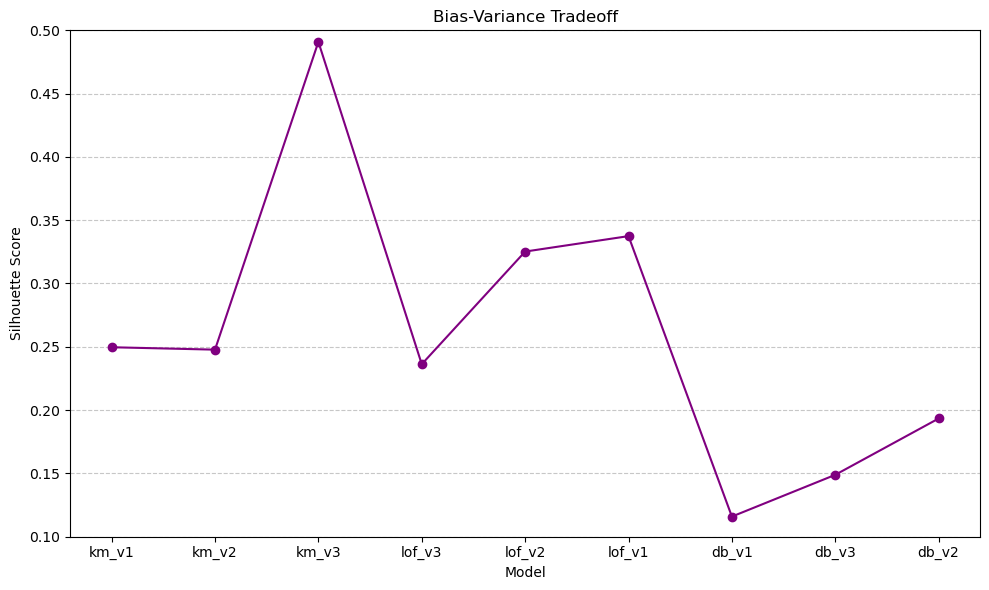

In [124]:
# Bias Variance Tradeoff Plot
import matplotlib.pyplot as plt

# 9 model variations to plot (High Variance, Low Bias: K-Means; Middle Variance, Middle Bias: LOF; Low Variance, High Bias: DBSCAN)
models = ['km_v1', 'km_v2', 'km_v3', 'lof_v3', 'lof_v2', 'lof_v1', 'db_v1', 'db_v3', 'db_v2']
# corresponding silhouette scores to analyze bias-variance tradeoff for unsupervised learning task
silhouette_scores = [0.2496, 0.2477, 0.4909, 0.2362, 0.3252, 0.3374, 0.1158, 0.1488, 0.1933]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(models, silhouette_scores, marker='o', color='purple', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Silhouette Score')
plt.title('Bias-Variance Tradeoff')
plt.ylim(0.1, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [125]:
from tabulate import tabulate

# Create a dictionary with the performance metrics
kmeans_v3_scores = {
    "Model Stage": ["Train", "Validation", "Test"],
    "Silhouette Score": [0.4638, 0.4909, 0.4865]
}

# Create a DataFrame
performance_metrics = pd.DataFrame(kmeans_v3_scores)

# Print the title and the table using tabulate
table_title = "Winning Model Performance Metrics by Stage"
print(table_title)
print(tabulate(performance_metrics, headers='keys', tablefmt='pretty'))

Winning Model Performance Metrics by Stage
+---+-------------+------------------+
|   | Model Stage | Silhouette Score |
+---+-------------+------------------+
| 0 |    Train    |      0.4638      |
| 1 | Validation  |      0.4909      |
| 2 |    Test     |      0.4865      |
+---+-------------+------------------+


In [126]:
'''
# Save the train set
train_embeddings_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_embeddings_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_embeddings_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\ntrain_embeddings_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nvalidation_embeddings_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\ntest_embeddings_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [127]:
# END WEEK 9

In [128]:
# BEGIN WEEK 10

In [129]:
'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Identify small clusters as anomalies based on k-means clustering of winning model from Week 9
# This will be used to create labeled data, which enables SMOTE to be used
def get_anomaly_clusters(X, n_clusters=10, percentile_threshold=10):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, max_iter=200, tol=1e-3, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    
    # Calculate the size of each cluster
    cluster_sizes = np.bincount(kmeans_labels)
    
    # Define threshold size based on the given percentile
    threshold_size = np.percentile(cluster_sizes, percentile_threshold)
    
    # Identify small clusters based on the threshold
    small_clusters = np.where(cluster_sizes <= threshold_size)[0]
    
    return small_clusters, kmeans_labels
    '''

"\nfrom sklearn.decomposition import PCA\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.preprocessing import StandardScaler\n\n# Identify small clusters as anomalies based on k-means clustering of winning model from Week 9\n# This will be used to create labeled data, which enables SMOTE to be used\ndef get_anomaly_clusters(X, n_clusters=10, percentile_threshold=10):\n    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, max_iter=200, tol=1e-3, random_state=42)\n    kmeans_labels = kmeans.fit_predict(X)\n    \n    # Calculate the size of each cluster\n    cluster_sizes = np.bincount(kmeans_labels)\n    \n    # Define threshold size based on the given percentile\n    threshold_size = np.percentile(cluster_sizes, percentile_threshold)\n    \n    # Identify small clusters based on the threshold\n    small_clusters = np.where(cluster_sizes <= threshold_size)[0]\n    \n    return small

In [130]:
'''
# Data-Centric AI 1: Apply SMOTE to the train data only (on small clusters (smallest 10th percentile of clusters))
def apply_smote(X_train, kmeans_labels, small_clusters):
    smote = SMOTE(random_state=42)
    X_train_resampled = X_train.copy()
    
    # Create a new DataFrame for the small clusters
    X_small_clusters = pd.DataFrame()
    y_small_clusters = []

    # Labels array: `0` for small clusters and `1` for normal clusters
    y_train_labels = np.ones(X_train.shape[0])  # Default to normal (1) for all points
    for cluster in small_clusters:
        # Get the indices of the points in the small cluster
        cluster_indices = np.where(kmeans_labels == cluster)[0]
        
        # Assign label `0` to points in small clusters
        y_train_labels[cluster_indices] = 0
        
        # Extract the points in that small cluster
        X_cluster = X_train.iloc[cluster_indices]
        
        # Only apply SMOTE if the cluster has more than 1 sample
        if X_cluster.shape[0] > 1:
            # Create pseudo-labels for SMOTE: assign a unique label for each small cluster
            y_cluster = np.full(X_cluster.shape[0], cluster)  # Each small cluster gets a unique label
            
            # Append to the small clusters dataset
            X_small_clusters = pd.concat([X_small_clusters, X_cluster], ignore_index=True)
            y_small_clusters.extend(y_cluster)

    # Apply SMOTE on the combined small clusters with labels
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train_labels)

    return X_resampled
    '''

'\n# Data-Centric AI 1: Apply SMOTE to the train data only (on small clusters (smallest 10th percentile of clusters))\ndef apply_smote(X_train, kmeans_labels, small_clusters):\n    smote = SMOTE(random_state=42)\n    X_train_resampled = X_train.copy()\n    \n    # Create a new DataFrame for the small clusters\n    X_small_clusters = pd.DataFrame()\n    y_small_clusters = []\n\n    # Labels array: `0` for small clusters and `1` for normal clusters\n    y_train_labels = np.ones(X_train.shape[0])  # Default to normal (1) for all points\n    for cluster in small_clusters:\n        # Get the indices of the points in the small cluster\n        cluster_indices = np.where(kmeans_labels == cluster)[0]\n        \n        # Assign label `0` to points in small clusters\n        y_train_labels[cluster_indices] = 0\n        \n        # Extract the points in that small cluster\n        X_cluster = X_train.iloc[cluster_indices]\n        \n        # Only apply SMOTE if the cluster has more than 1 sampl

In [131]:
'''
# Data-Centric AI 2: Apply PCA to reduce dimensionality while retaining 95% of the dataset's variance (train, validation, test)
def apply_pca(X_train, X_val, X_test, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    return X_train_pca, X_val_pca, X_test_pca
    '''

"\n# Data-Centric AI 2: Apply PCA to reduce dimensionality while retaining 95% of the dataset's variance (train, validation, test)\ndef apply_pca(X_train, X_val, X_test, n_components=0.95):\n    pca = PCA(n_components=n_components)\n    X_train_pca = pca.fit_transform(X_train)\n    X_val_pca = pca.transform(X_val)\n    X_test_pca = pca.transform(X_test)\n    \n    return X_train_pca, X_val_pca, X_test_pca\n    "

In [132]:
'''
# Data-Centric AI 3: Inject Gaussian noise into the data (train, validation, test)
def inject_noise(X_train, X_val, X_test, noise_factor=0.1):
    noise_train = np.random.normal(loc=0, scale=noise_factor, size=X_train.shape)
    noise_val = np.random.normal(loc=0, scale=noise_factor, size=X_val.shape)
    noise_test = np.random.normal(loc=0, scale=noise_factor, size=X_test.shape)
    
    X_train_noisy = X_train + noise_train
    X_val_noisy = X_val + noise_val
    X_test_noisy = X_test + noise_test
    
    return X_train_noisy, X_val_noisy, X_test_noisy
    '''

'\n# Data-Centric AI 3: Inject Gaussian noise into the data (train, validation, test)\ndef inject_noise(X_train, X_val, X_test, noise_factor=0.1):\n    noise_train = np.random.normal(loc=0, scale=noise_factor, size=X_train.shape)\n    noise_val = np.random.normal(loc=0, scale=noise_factor, size=X_val.shape)\n    noise_test = np.random.normal(loc=0, scale=noise_factor, size=X_test.shape)\n    \n    X_train_noisy = X_train + noise_train\n    X_val_noisy = X_val + noise_val\n    X_test_noisy = X_test + noise_test\n    \n    return X_train_noisy, X_val_noisy, X_test_noisy\n    '

In [133]:
'''
# Function to apply all Data-Centric AI Techniques
def apply_data_centric_ai(X_train, X_val, X_test, n_clusters=10, percentile_threshold=10, noise_factor=0.1, pca_n_components=0.95):
    # Identify small clusters using k-means
    small_clusters, kmeans_labels = get_anomaly_clusters(X_train, n_clusters=n_clusters, percentile_threshold=percentile_threshold)
    
    # Apply SMOTE to the train set based on small clusters
    X_train_smote = apply_smote(X_train, kmeans_labels, small_clusters)
    
    # Apply PCA to reduce dimensionality for train, validation, and test sets
    X_train_pca, X_val_pca, X_test_pca = apply_pca(X_train_smote, X_val, X_test, n_components=pca_n_components)
    
    # Inject Gaussian noise to the data
    X_train_noisy, X_val_noisy, X_test_noisy = inject_noise(X_train_pca, X_val_pca, X_test_pca, noise_factor=noise_factor)
    
    return X_train_noisy, X_val_noisy, X_test_noisy, small_clusters, kmeans_labels
    '''

'\n# Function to apply all Data-Centric AI Techniques\ndef apply_data_centric_ai(X_train, X_val, X_test, n_clusters=10, percentile_threshold=10, noise_factor=0.1, pca_n_components=0.95):\n    # Identify small clusters using k-means\n    small_clusters, kmeans_labels = get_anomaly_clusters(X_train, n_clusters=n_clusters, percentile_threshold=percentile_threshold)\n    \n    # Apply SMOTE to the train set based on small clusters\n    X_train_smote = apply_smote(X_train, kmeans_labels, small_clusters)\n    \n    # Apply PCA to reduce dimensionality for train, validation, and test sets\n    X_train_pca, X_val_pca, X_test_pca = apply_pca(X_train_smote, X_val, X_test, n_components=pca_n_components)\n    \n    # Inject Gaussian noise to the data\n    X_train_noisy, X_val_noisy, X_test_noisy = inject_noise(X_train_pca, X_val_pca, X_test_pca, noise_factor=noise_factor)\n    \n    return X_train_noisy, X_val_noisy, X_test_noisy, small_clusters, kmeans_labels\n    '

In [134]:
'''
# Apply the data-centric AI techniques (SMOTE, PCA, Noise Injection)
X_train_final, X_val_final, X_test_final, small_clusters, kmeans_labels = apply_data_centric_ai(
    X_train, X_val, X_test, n_clusters=10, percentile_threshold=10, noise_factor=0.1, pca_n_components=0.95)
    '''

'\n# Apply the data-centric AI techniques (SMOTE, PCA, Noise Injection)\nX_train_final, X_val_final, X_test_final, small_clusters, kmeans_labels = apply_data_centric_ai(\n    X_train, X_val, X_test, n_clusters=10, percentile_threshold=10, noise_factor=0.1, pca_n_components=0.95)\n    '

In [135]:
'''
# Fit the k-means model again on the final data
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=1, max_iter=200, tol=1e-3, random_state=42)
kmeans.fit(X_train_final)  # Fit on the final transformed train data
labels_train_final = kmeans.labels_
silhouette_avg_train = silhouette_score(X_train_final, labels_train_final)

labels_val_final = kmeans.predict(X_val_final)  # Predict the labels for the validation set
silhouette_avg_val = silhouette_score(X_val_final, labels_val_final)  # Compute silhouette score for validation

labels_test_final = kmeans.predict(X_test_final)  # Predict the labels for the test set
silhouette_avg_test = silhouette_score(X_test_final, labels_test_final)  # Compute silhouette score for test
'''

"\n# Fit the k-means model again on the final data\nkmeans = KMeans(n_clusters=10, init='k-means++', n_init=1, max_iter=200, tol=1e-3, random_state=42)\nkmeans.fit(X_train_final)  # Fit on the final transformed train data\nlabels_train_final = kmeans.labels_\nsilhouette_avg_train = silhouette_score(X_train_final, labels_train_final)\n\nlabels_val_final = kmeans.predict(X_val_final)  # Predict the labels for the validation set\nsilhouette_avg_val = silhouette_score(X_val_final, labels_val_final)  # Compute silhouette score for validation\n\nlabels_test_final = kmeans.predict(X_test_final)  # Predict the labels for the test set\nsilhouette_avg_test = silhouette_score(X_test_final, labels_test_final)  # Compute silhouette score for test\n"

In [136]:
'''
# Print results of model on data-centric AI-transformed datasets
print(f"Final Silhouette Score on Transformed Train Data: {silhouette_avg_train}")
print(f"Final Silhouette Score on Transformed Validation Data: {silhouette_avg_val}")
print(f"Final Silhouette Score on Transformed Test Data: {silhouette_avg_test}")
'''

'\n# Print results of model on data-centric AI-transformed datasets\nprint(f"Final Silhouette Score on Transformed Train Data: {silhouette_avg_train}")\nprint(f"Final Silhouette Score on Transformed Validation Data: {silhouette_avg_val}")\nprint(f"Final Silhouette Score on Transformed Test Data: {silhouette_avg_test}")\n'

In [137]:
'''
from tabulate import tabulate

# Create a dictionary with the performance metrics
data_centric_ai_kmeans_scores = {
    "Model Stage": ["Train", "Validation", "Test"],
    "Silhouette Score": [0.2975, 0.3100, 0.3083]
}

# Create a DataFrame
performance_metrics = pd.DataFrame(data_centric_ai_kmeans_scores)

# Print the title and the table using tabulate
table_title = "Winning Model Performance Metrics by Stage on Data-Centric AI-Transformed Data"
print(table_title)
print(tabulate(performance_metrics, headers='keys', tablefmt='pretty'))
'''

'\nfrom tabulate import tabulate\n\n# Create a dictionary with the performance metrics\ndata_centric_ai_kmeans_scores = {\n    "Model Stage": ["Train", "Validation", "Test"],\n    "Silhouette Score": [0.2975, 0.3100, 0.3083]\n}\n\n# Create a DataFrame\nperformance_metrics = pd.DataFrame(data_centric_ai_kmeans_scores)\n\n# Print the title and the table using tabulate\ntable_title = "Winning Model Performance Metrics by Stage on Data-Centric AI-Transformed Data"\nprint(table_title)\nprint(tabulate(performance_metrics, headers=\'keys\', tablefmt=\'pretty\'))\n'

In [138]:
'''
# Save the train set
X_train_final_df = pd.DataFrame(X_train_final)
X_train_final_df.to_csv('train_data.csv', index=False)

# Save the validation set
X_val_final_df = pd.DataFrame(X_val_final)
X_val_final_df.to_csv('validation_data.csv', index=False)

# Save the test set
X_test_final_df = pd.DataFrame(X_test_final)
X_test_final_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")
'''

'\n# Save the train set\nX_train_final_df = pd.DataFrame(X_train_final)\nX_train_final_df.to_csv(\'train_data.csv\', index=False)\n\n# Save the validation set\nX_val_final_df = pd.DataFrame(X_val_final)\nX_val_final_df.to_csv(\'validation_data.csv\', index=False)\n\n# Save the test set\nX_test_final_df = pd.DataFrame(X_test_final)\nX_test_final_df.to_csv(\'test_data.csv\', index=False)\n\nprint("DataFrames have been saved as CSV files.")\n'

In [139]:
# END WEEK 10

In [140]:
# BEGIN WEEK 11

In [142]:
# We will use the Week 9 dataset and model for this section as this model performed
# better than the Week 10 model.

# Ensure that embeddings are flattened
embedding_columns = ['Account_Embeddings', 'Merchant_Embeddings', 'Transaction_Embeddings', 'Location_Embeddings', 'Hour_Group_Embeddings']

for col in embedding_columns:
    # Check if the column contains lists or arrays and flatten them
    if isinstance(X_train[col].iloc[0], (list, np.ndarray)):  # Check if the first entry is a sequence
        embedding_array = pd.DataFrame(X_train[col].apply(lambda x: np.array(x).flatten()).tolist())
        embedding_array.columns = [f"{col}_{i}" for i in range(embedding_array.shape[1])]
        X_train = pd.concat([X_train, embedding_array], axis=1)
        X_train.drop(columns=[col], inplace=True)  # Drop the original embedding column
    else:
        # If already flattened, ensure it's a numeric type
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

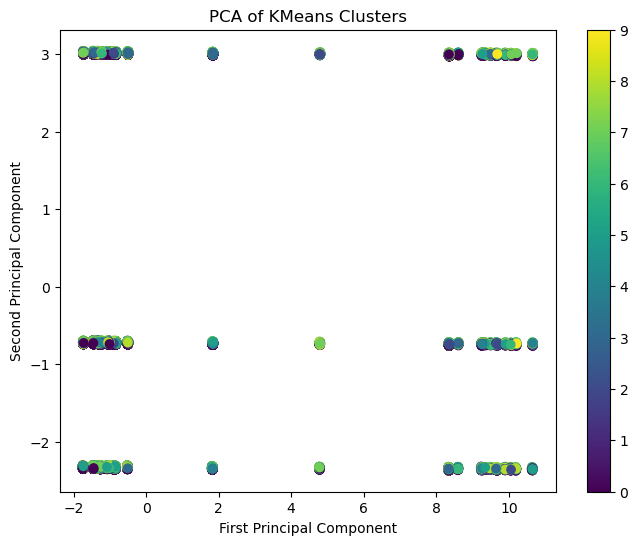

Explained variance ratio by component: [0.19020647 0.10468724 0.08504371 0.07977474]
        Day_0     Day_1     Day_2     Day_3     Day_4     Day_5     Day_6  \
PC1  0.000575  0.000389 -0.000180  0.000472 -0.000474 -0.000569 -0.000226   
PC2  0.000439 -0.000143 -0.001818 -0.000041 -0.003743  0.003181  0.002124   
PC3 -0.000265  0.000363  0.000695  0.001840 -0.002963 -0.001518  0.001801   
PC4  0.000878 -0.002022  0.000025  0.001042 -0.002720  0.001845  0.000962   

     Deviation_From_Mean  Account_Embeddings_0  Account_Embeddings_1  ...  \
PC1             0.001187             -0.150118              0.194155  ...   
PC2            -0.000670              0.000155             -0.000670  ...   
PC3            -0.000117              0.018243             -0.020908  ...   
PC4            -0.001908             -0.298962              0.344653  ...   

     Location_Embeddings_6  Location_Embeddings_7  Hour_Group_Embeddings_0  \
PC1              -0.001343               0.000792                

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to aid in identifying most relevant predictors in the dataset
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_train_scaled)

# Plot the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_v3.labels_, cmap='viridis')
plt.colorbar()
plt.title('PCA of KMeans Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Explained variance ratio tells us how much of the variance is captured by each component
print("Explained variance ratio by component:", pca.explained_variance_ratio_)

# You can also examine which features contribute most to the first principal component
features_pca = pd.DataFrame(pca.components_, columns=X_train.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])
print(features_pca)


In [152]:
# Store the original feature names before scaling
original_feature_names = X_train.columns  # This stores the original feature names

# Fit model with scaled data
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=1, max_iter=200, tol=1e-3, random_state=42)
kmeans.fit(X_train_scaled)

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Assign clusters to each data point
assigned_centroids = kmeans.predict(X_train_scaled)

# Identify random points farthest from their centroids (anomalies)
# Calculate distances from each point to its assigned centroid
distances = np.linalg.norm(X_train_scaled - centroids[assigned_centroids], axis=1)

# Sort the indices of the points based on the distance to centroid (farthest first)
farthest_indices = np.argsort(distances)[::-1]

# Select 5 random points from those farthest from the centroid
random_furthest_points = farthest_indices[:5]

# Calculate the feature-wise contribution to the distance from the centroid for each point
feature_contributions = []

for idx in random_furthest_points:
    point = X_train_scaled[idx]  # Use array indexing to select the point
    assigned_cluster = assigned_centroids[idx]
    centroid = centroids[assigned_cluster]
    
    # Calculate the squared difference for each feature (contribution to distance)
    feature_contrib = (point - centroid) ** 2
    feature_contributions.append(feature_contrib)

# Manually generate column names based on the original dataset columns
# Since X_train_scaled is a NumPy array, we need to manually use the feature names from the original dataset
columns = original_feature_names

# Convert the contributions to a DataFrame for better readability
# Manually create a DataFrame and match it with the original feature names
feature_contributions_df = pd.DataFrame(feature_contributions, columns=columns)
print("Feature-wise contributions to distance from centroid for selected points:")
print(feature_contributions_df)

# Simulate adjusting the features of a randomly selected point to move 10% closer to its centroid
adjusted_points = []

for idx in random_furthest_points:
    point = X_train_scaled[idx]  # Use array indexing to select the point
    assigned_cluster = assigned_centroids[idx]
    centroid = centroids[assigned_cluster]
    
    # Calculate the difference for each feature
    feature_differences = point - centroid
    
    # Calculate how much to adjust each feature (reduce by 10% of the difference)
    adjustment = 0.1 * feature_differences  # 10% adjustment
    
    # Apply the adjustment to the features
    new_point = point - adjustment  # Move the point closer to the centroid
    adjusted_points.append(new_point)

# Convert the adjusted points into a DataFrame for better readability
# Again, manually assigning feature names
adjusted_points_df = pd.DataFrame(adjusted_points, columns=columns)
print("\nAdjusted feature values for points moved closer to centroids (10% adjustment):")
print(adjusted_points_df)

# Calculate the new distance after the adjustment to see how much the point moved
new_distances = np.linalg.norm(np.array(adjusted_points_df) - centroids[assigned_centroids[random_furthest_points]], axis=1)
print("\nNew distances to centroid after adjustment:")
print(new_distances)

Feature-wise contributions to distance from centroid for selected points:
      Day_0     Day_1     Day_2     Day_3     Day_4     Day_5     Day_6  \
0  0.172981  0.172447  0.173179  0.163272  0.162168  6.234886  0.167943   
1  0.170637  0.164565  0.172248  6.156493  0.172364  0.162026  0.161660   
2  0.174762  0.179575  5.821240  0.159325  0.170867  0.152382  0.154537   
3  5.865028  0.174708  0.163556  0.161403  0.154641  0.173756  0.168029   
4  0.174762  0.179575  0.176124  6.182390  0.170867  0.152382  0.154537   

   Deviation_From_Mean  Account_Embeddings_0  Account_Embeddings_1  ...  \
0            70.459024              2.339557              0.381855  ...   
1            68.323767              1.139947              0.060031  ...   
2            32.048874              0.000049              0.001941  ...   
3            68.550852              0.518583              0.383460  ...   
4            55.089934              0.721595              1.055179  ...   

   Location_Embeddings_6


Top features per PC based on their contribution to variance:
PC1: ['Hour_Group_Embeddings_5', 'Hour_Group_Embeddings_6', 'Hour_Group_Embeddings_1']
PC2: ['Transaction_Embeddings_4', 'Transaction_Embeddings_6', 'Transaction_Embeddings_7']
PC3: ['Location_Embeddings_6', 'Location_Embeddings_4', 'Location_Embeddings_3']
PC4: ['Account_Embeddings_3', 'Account_Embeddings_5', 'Account_Embeddings_4']


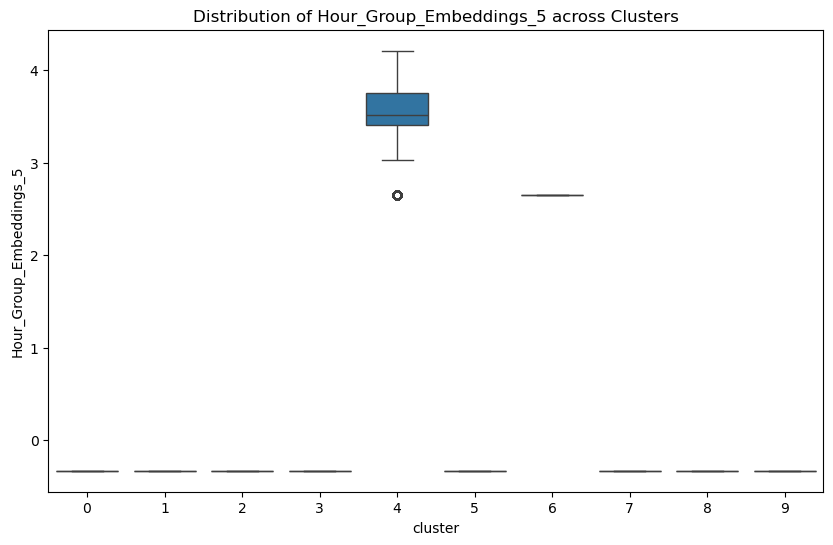

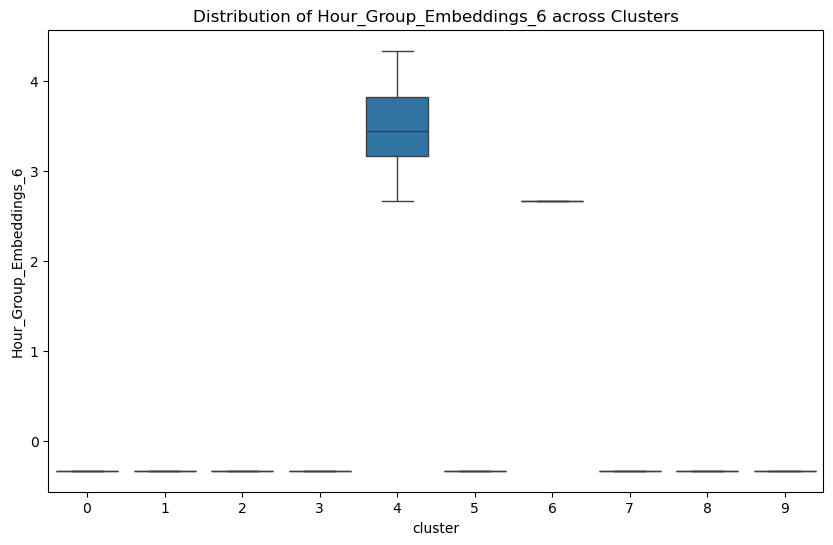

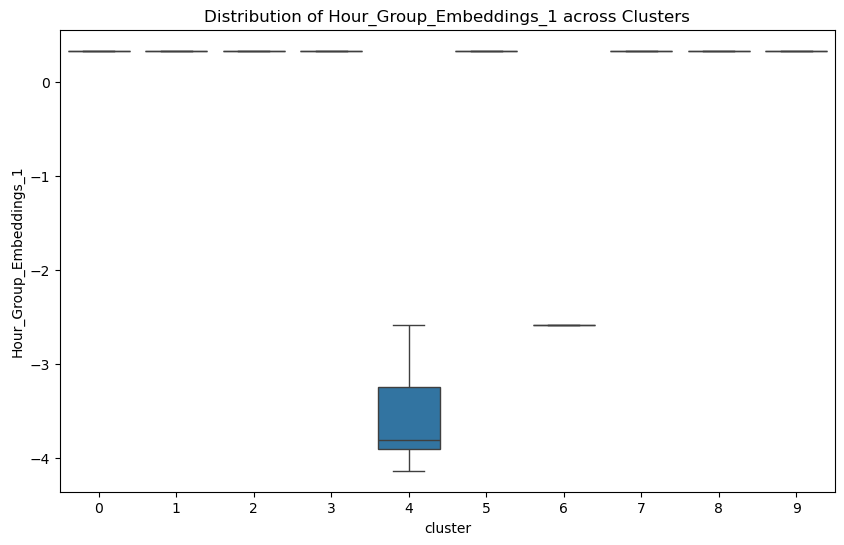

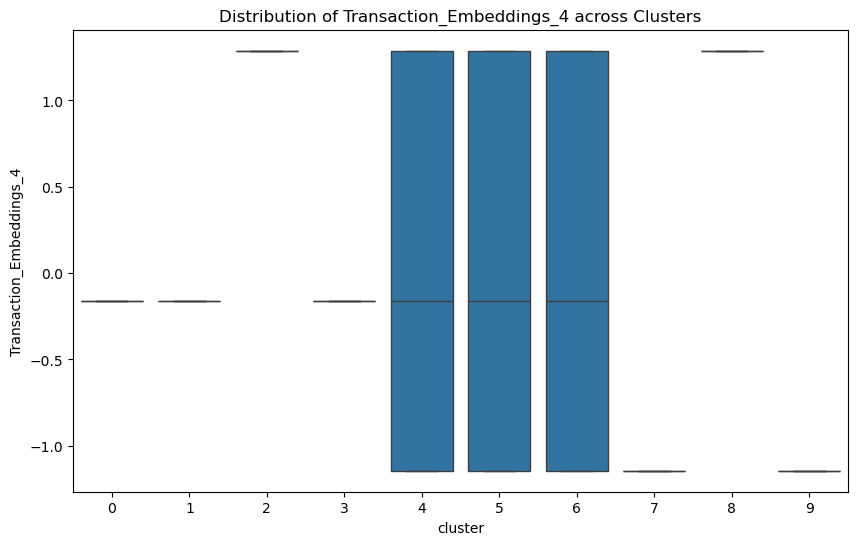

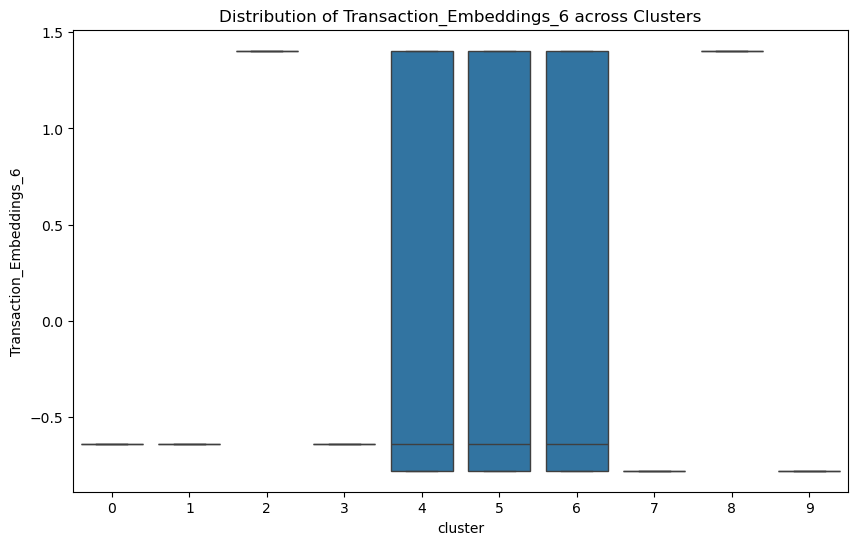

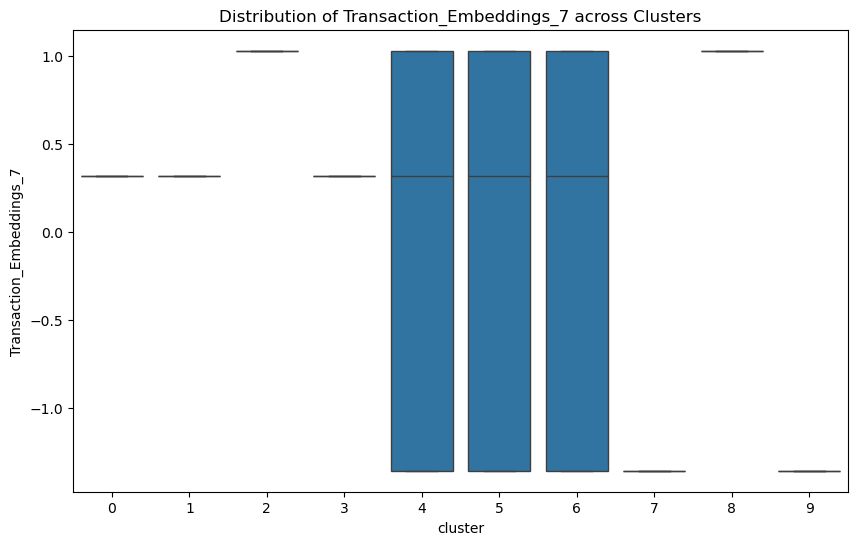

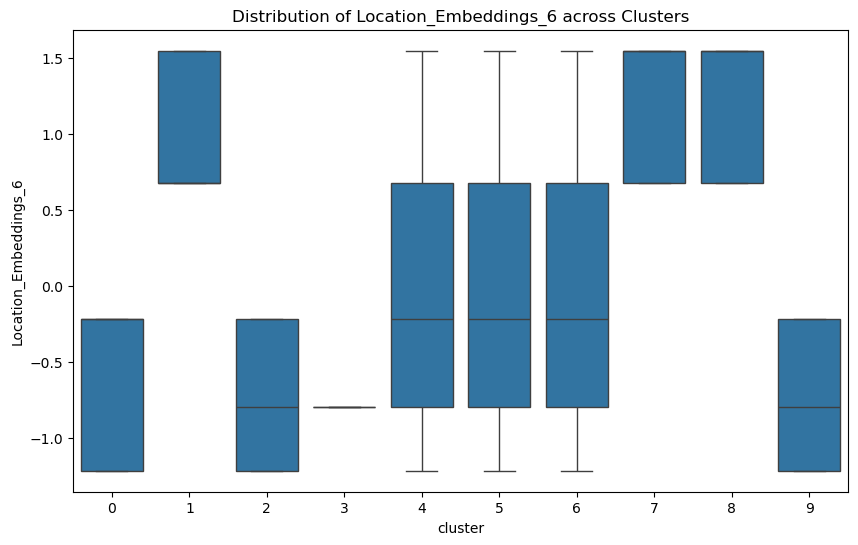

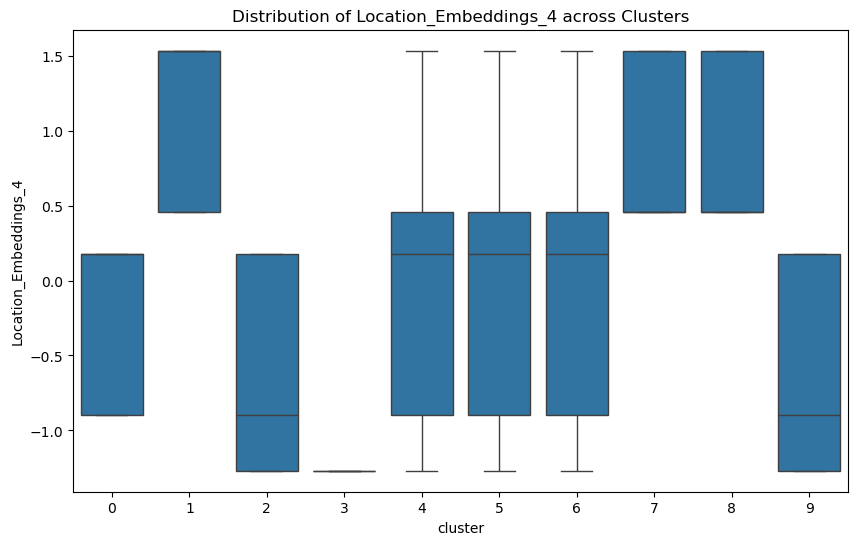

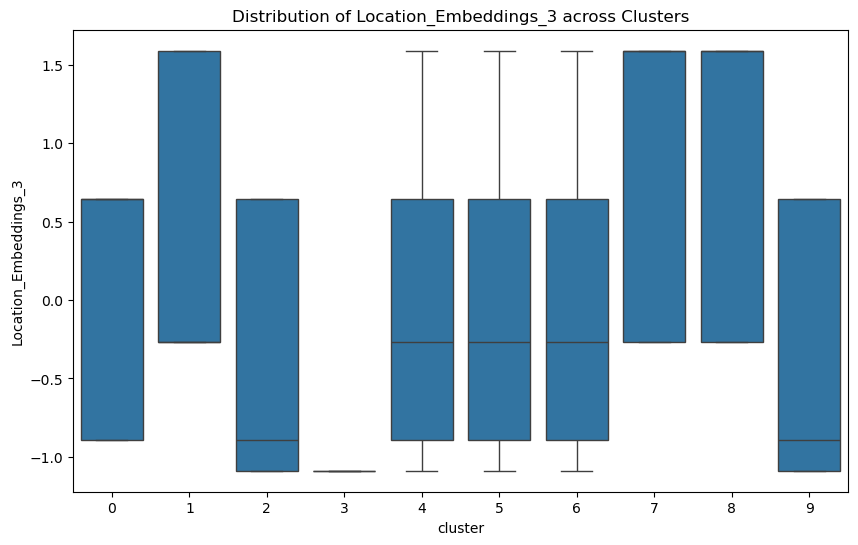

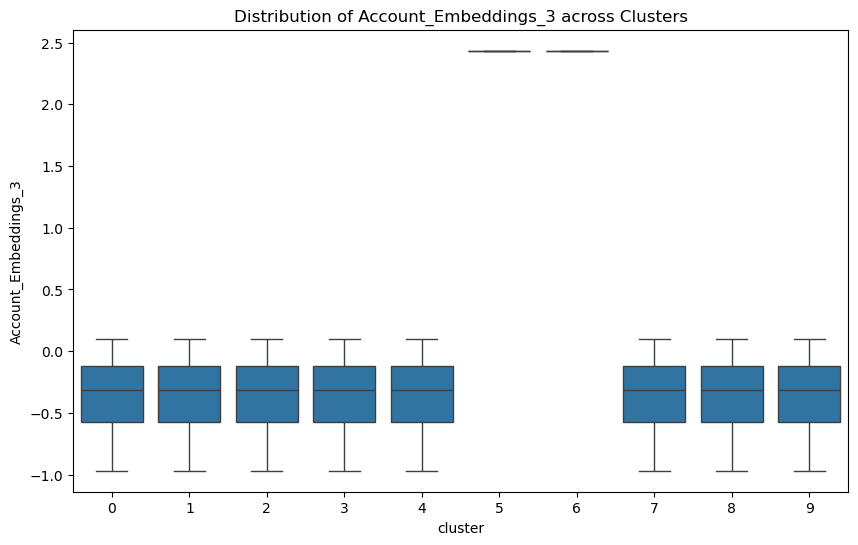

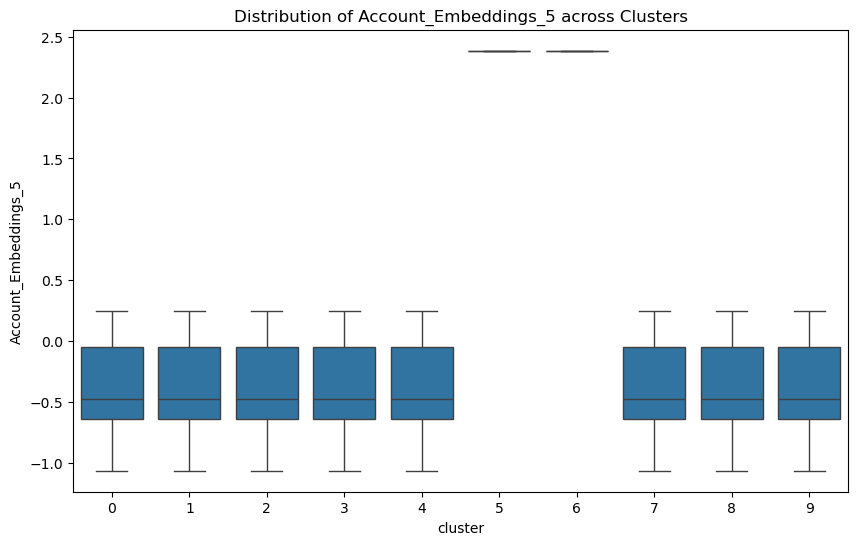

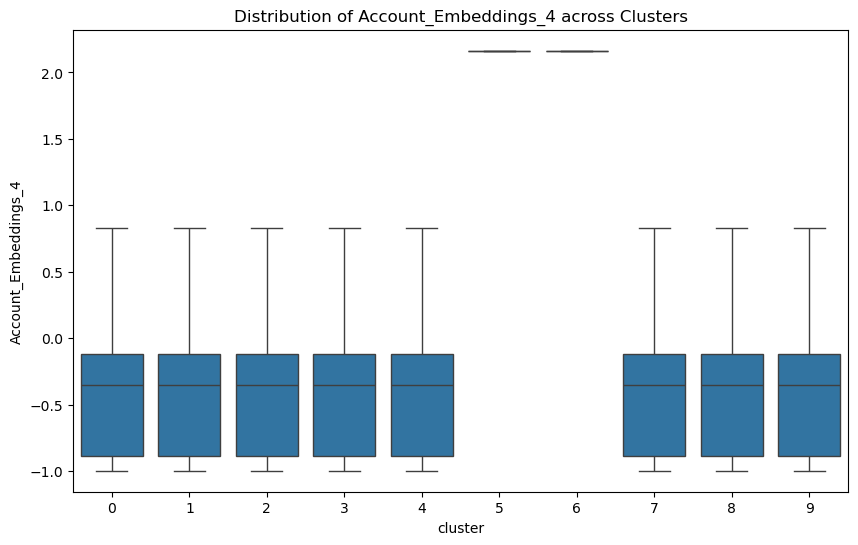

In [154]:
# To quantify bias, we will extract the most important contributing features to classification and manually
# determine the likelihood that these features contain inherent bias due to their correlations to 
# protected classes that are not explicitly present in our data or model.

# Find the features with the largest loadings (absolute values) for each principal component
top_features_per_pc = {}

for pc in features_pca.index:
    sorted_features = features_pca.loc[pc].abs().sort_values(ascending=False)
    top_features_per_pc[pc] = sorted_features.head(3)  # Top 3 features for each PC

# Display the most important features for each principal component
print("\nTop features per PC based on their contribution to variance:")
for pc, features in top_features_per_pc.items():
    print(f"{pc}: {features.index.tolist()}")

# Add your clustering results to the dataset from K-Means model for visualization
X_train_scaled_with_clusters = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_with_clusters['cluster'] = kmeans.labels_

# Visualize how the identified features vary across clusters (for bias detection)
for pc, features in top_features_per_pc.items():
    for feature in features.index:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cluster', y=feature, data=X_train_scaled_with_clusters)
        plt.title(f'Distribution of {feature} across Clusters')
        plt.show()

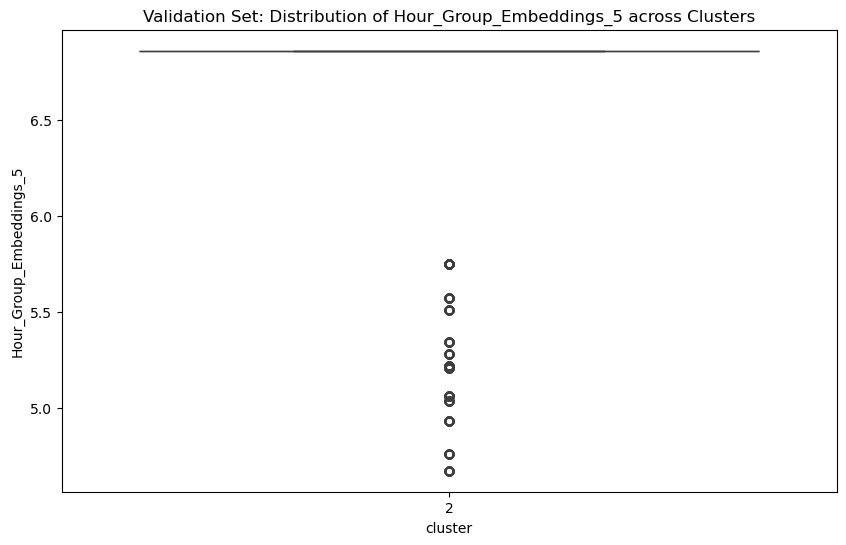

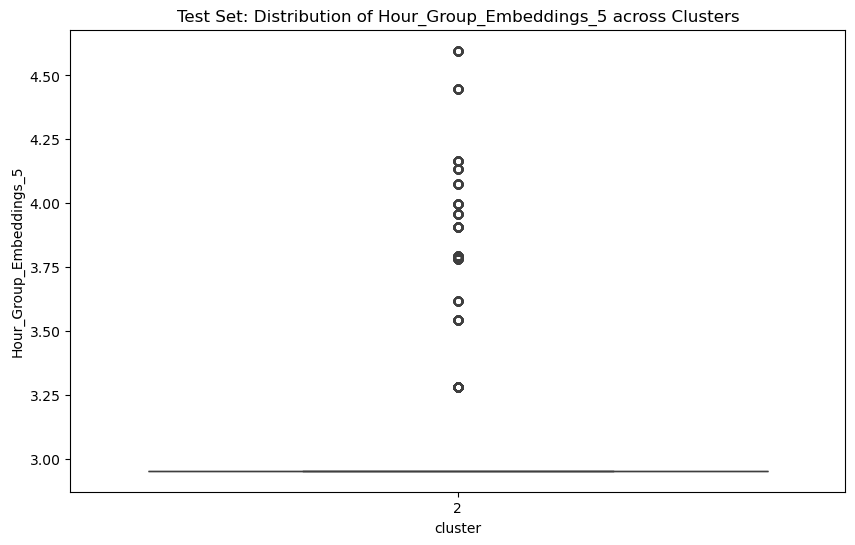

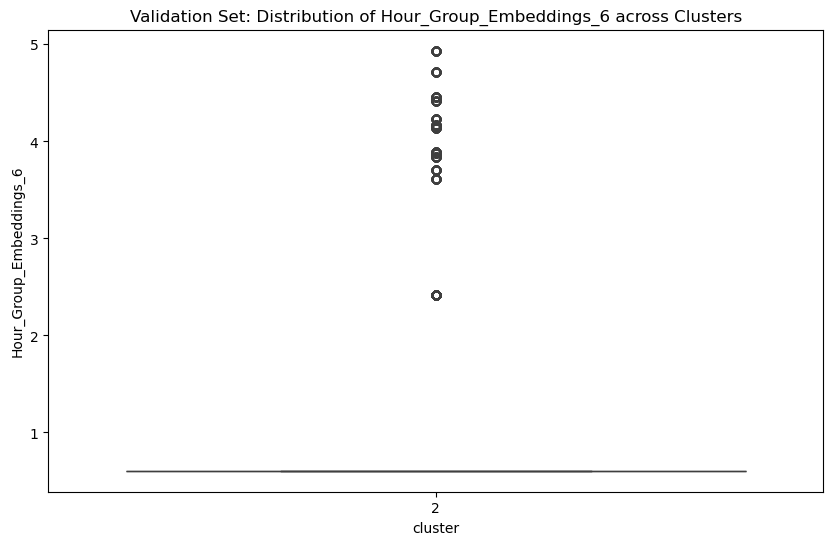

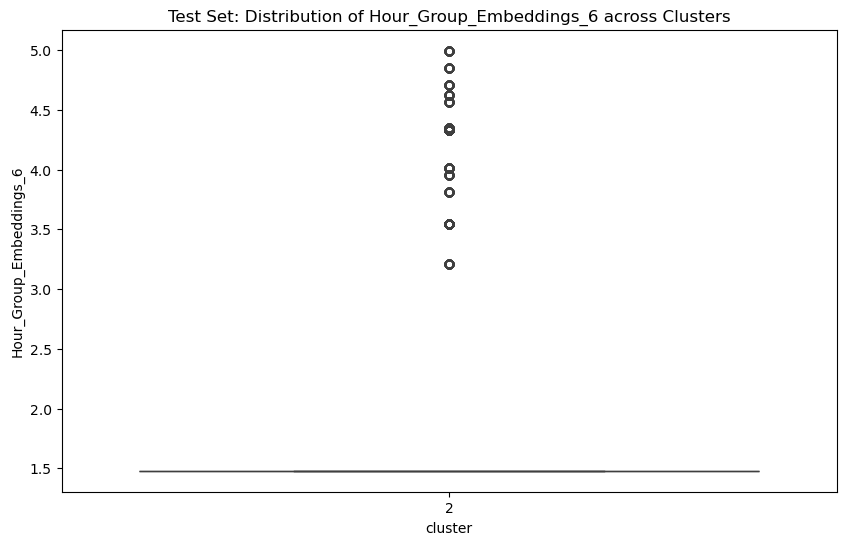

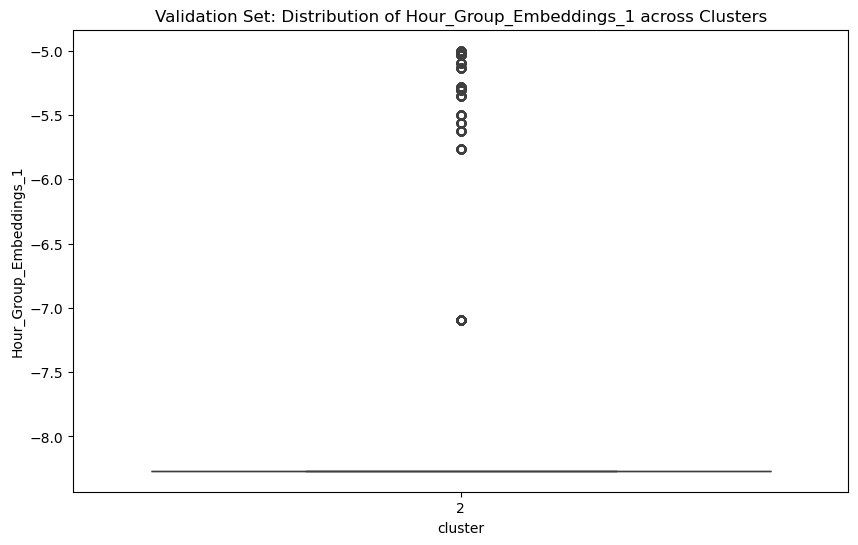

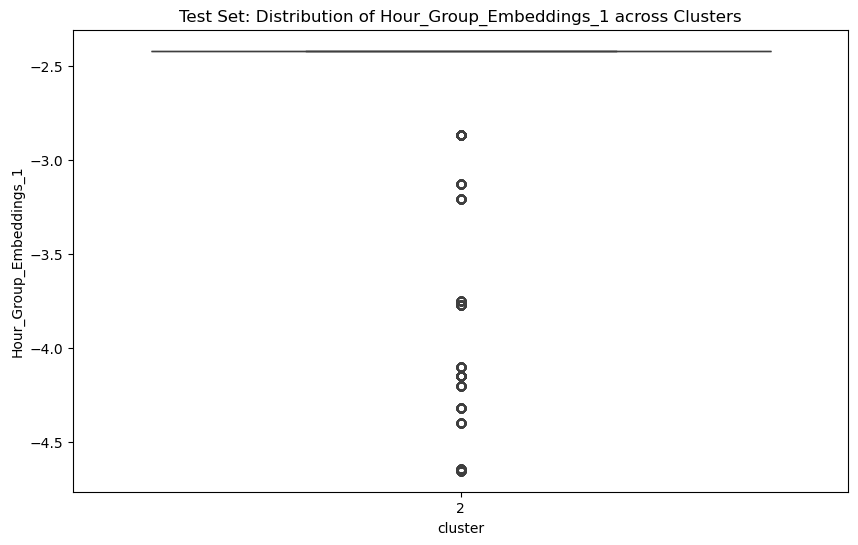

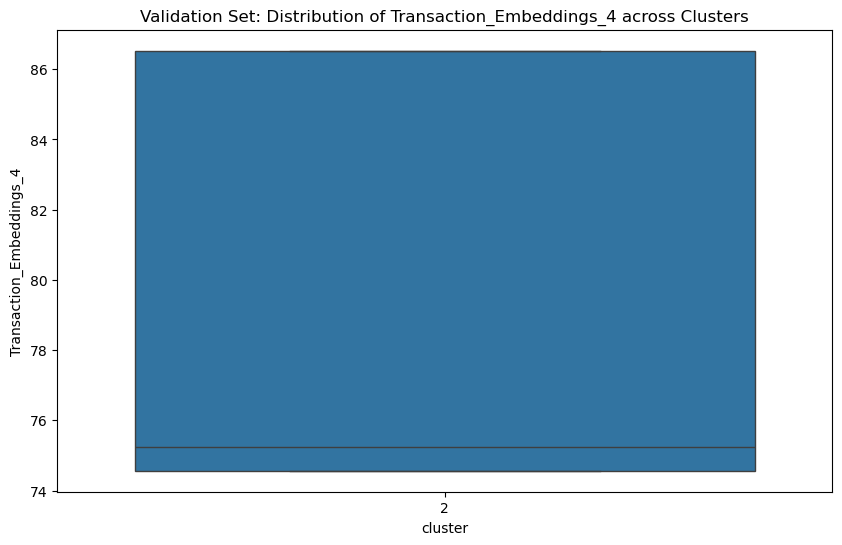

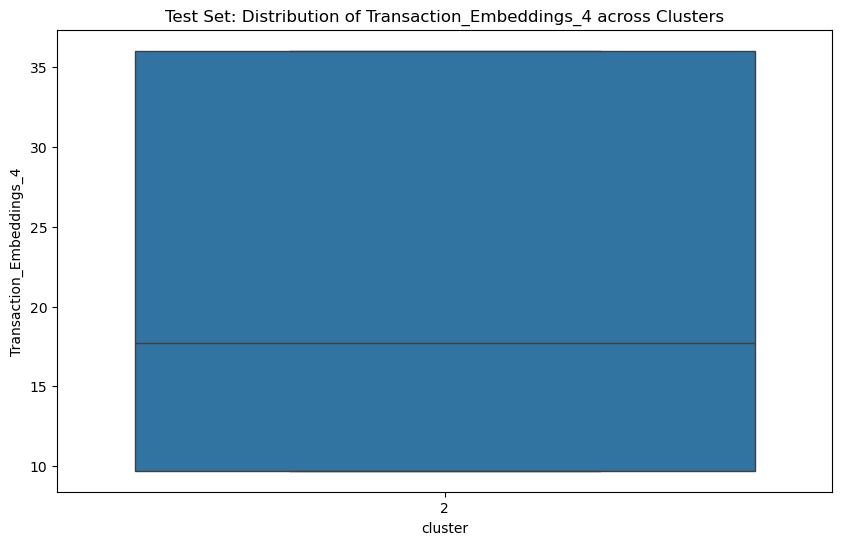

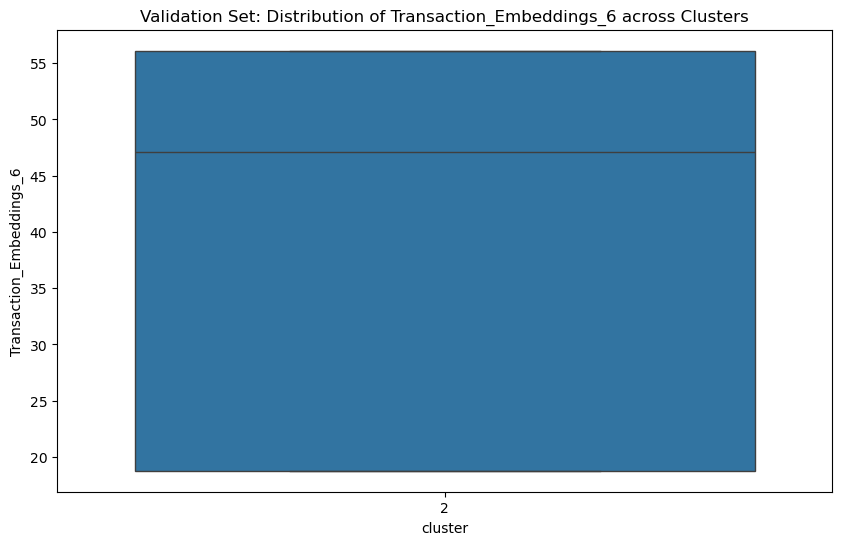

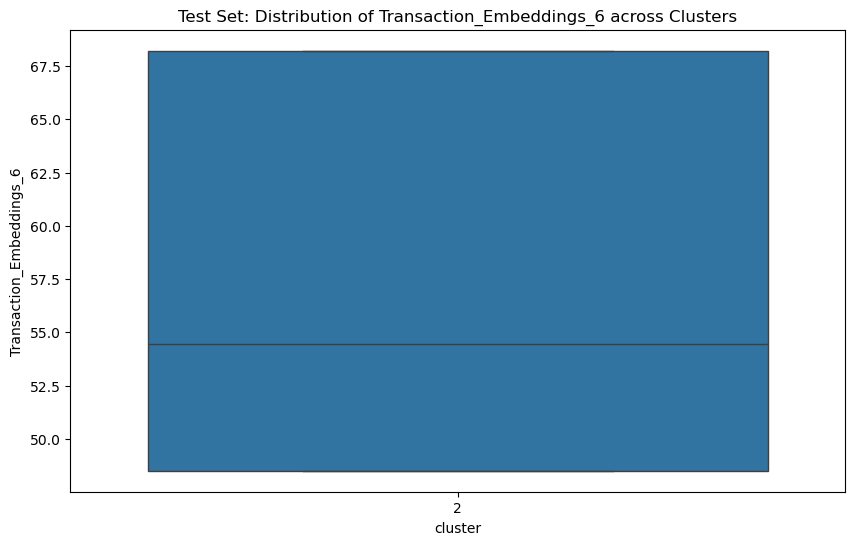

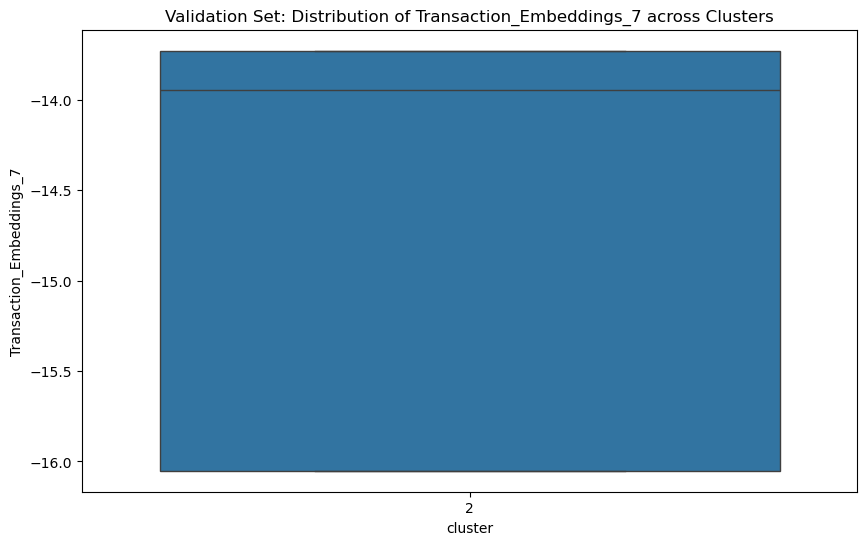

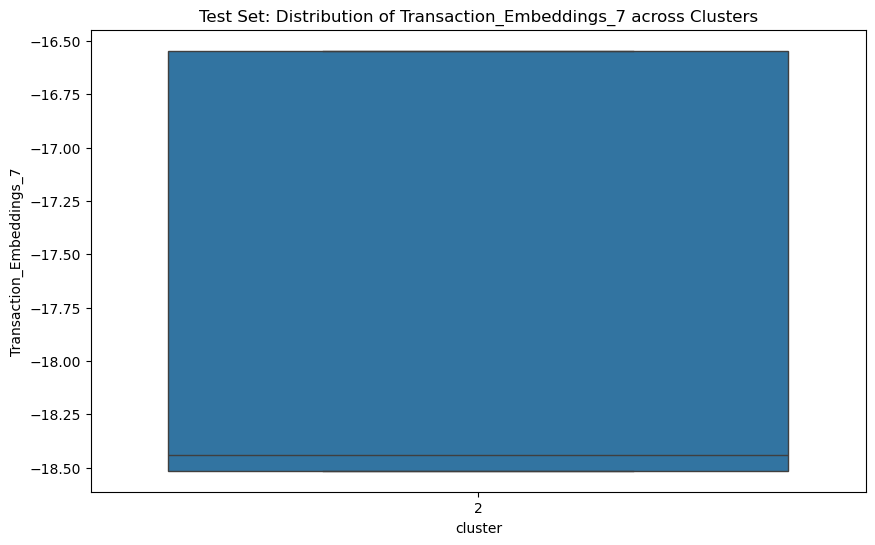

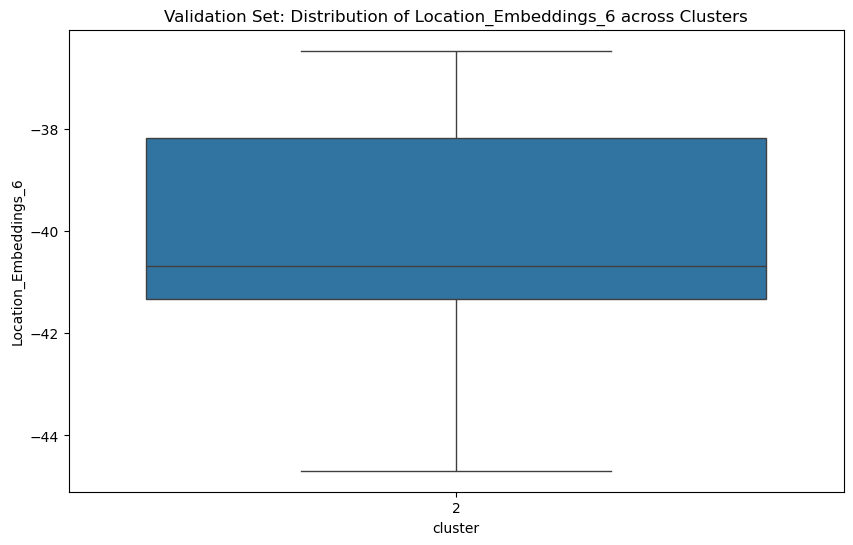

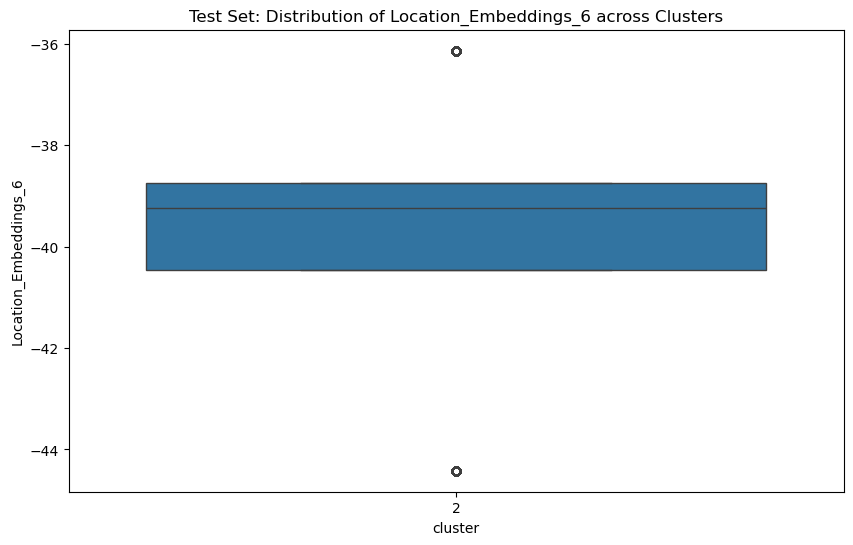

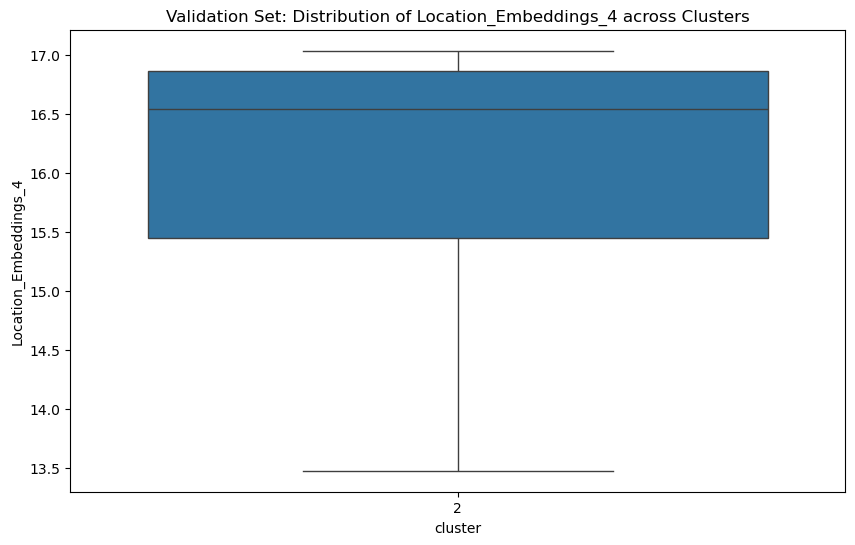

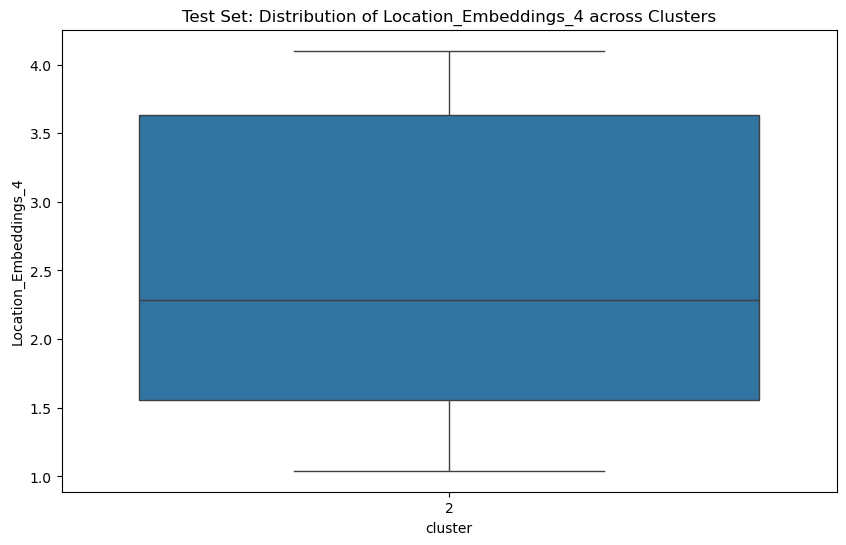

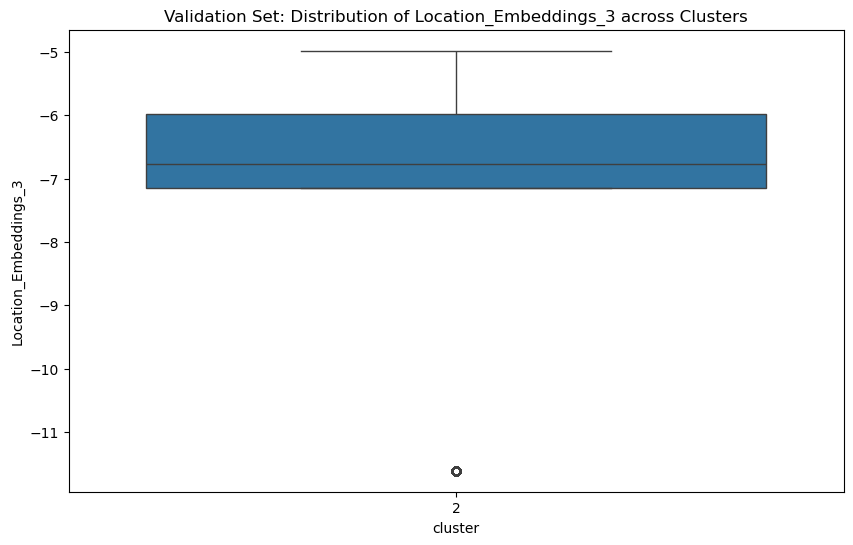

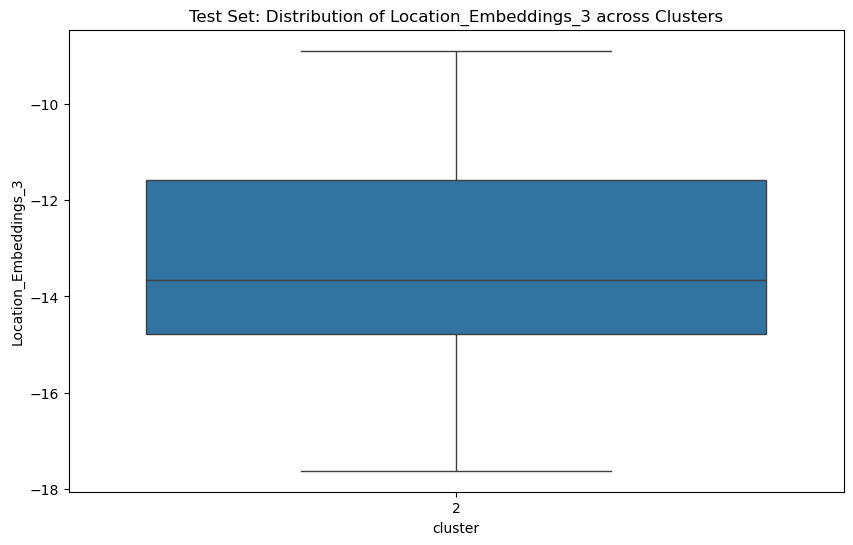

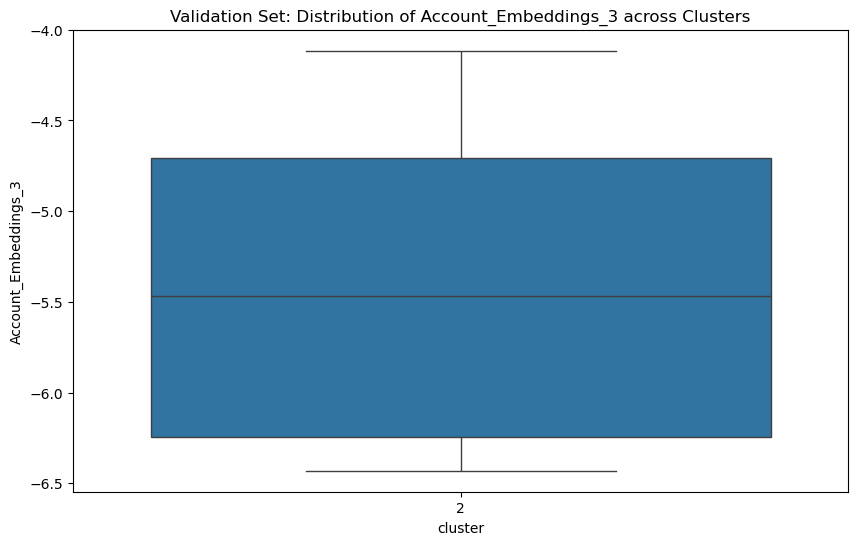

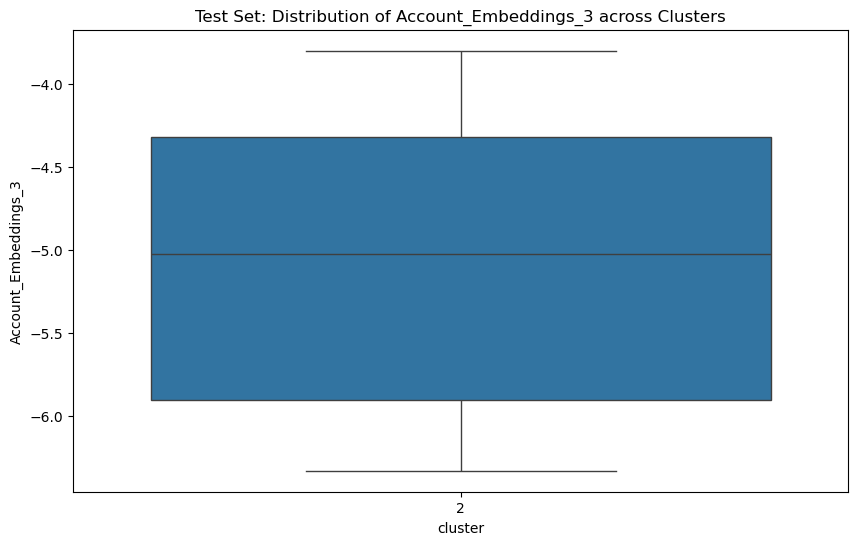

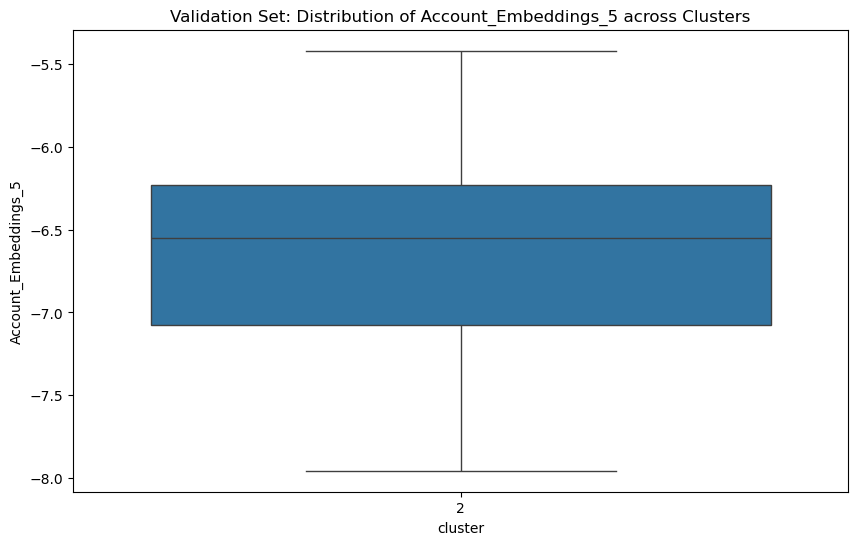

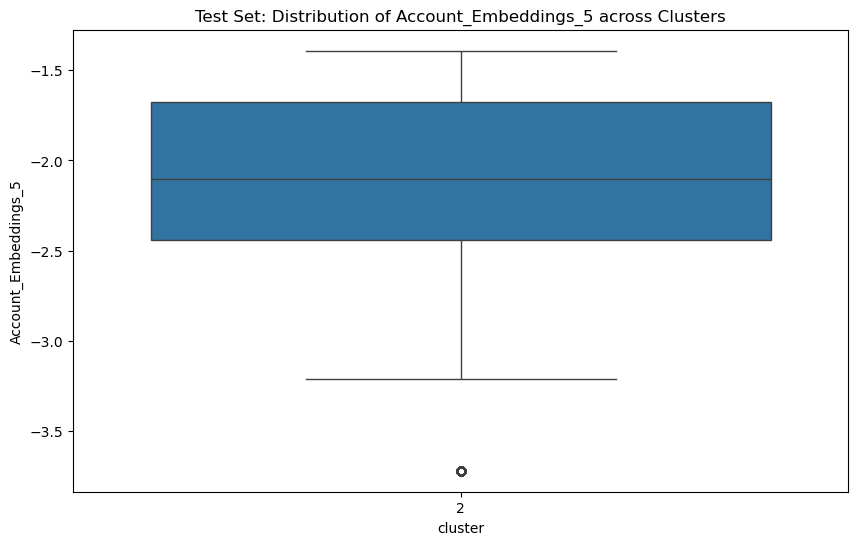

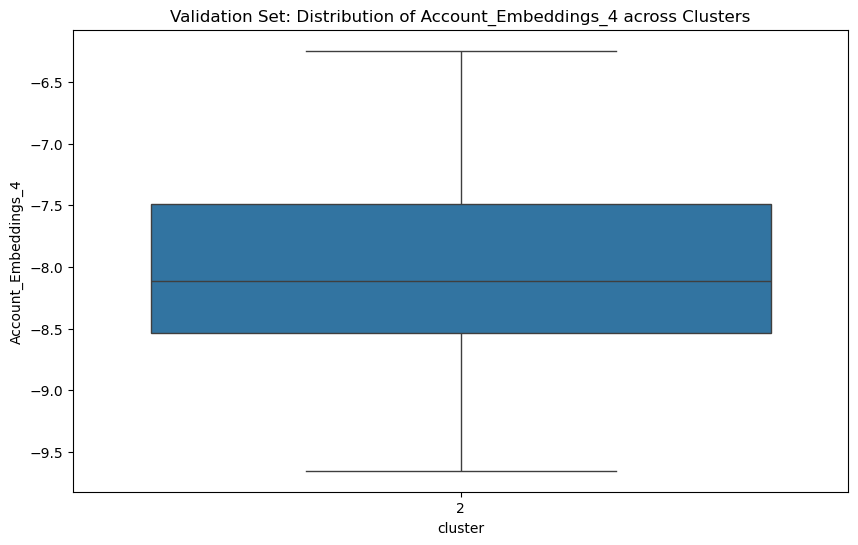

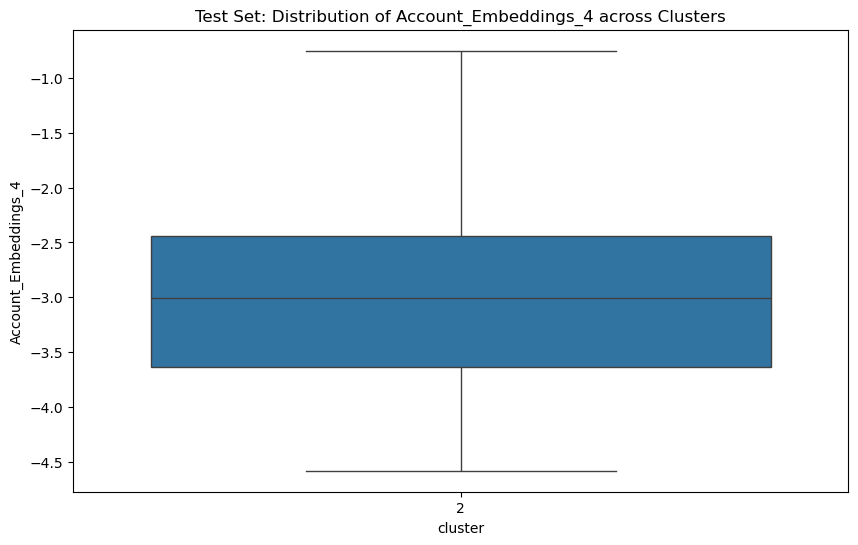

In [156]:
# Perform same process on validation and test datasets to analyze
# bias across these datasets as well

# Apply the same scaler used for the training set
X_val_scaled = scaler.transform(X_val)  # Use the same scaler for validation
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test

# Apply PCA transformation to the validation and test sets
X_val_pca = pca.transform(X_val_scaled)  # Apply PCA to the validation set
X_test_pca = pca.transform(X_test_scaled)  # Apply PCA to the test set

# Predict cluster labels for validation and test sets
val_clusters = kmeans.predict(X_val_scaled)  # Predict clusters for validation
test_clusters = kmeans.predict(X_test_scaled)  # Predict clusters for test

# Step 4: Visualize bias in features based on PCA loadings
# Add clusters to the validation and test sets for visualization
X_val_scaled_with_clusters = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_val_scaled_with_clusters['cluster'] = val_clusters

X_test_scaled_with_clusters = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled_with_clusters['cluster'] = test_clusters

# Bias Analysis: Visualize key features across clusters
for pc, features in top_features_per_pc.items():
    for feature in features.index:
        # Validation Set visualization
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cluster', y=feature, data=X_val_scaled_with_clusters)
        plt.title(f'Validation Set: Distribution of {feature} across Clusters')
        plt.show()

        # Test Set visualization
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cluster', y=feature, data=X_test_scaled_with_clusters)
        plt.title(f'Test Set: Distribution of {feature} across Clusters')
        plt.show()

In [157]:
# Save the train set
train_embeddings_df.to_csv('train_data.csv', index=False)

# Save the validation set
validation_embeddings_df.to_csv('validation_data.csv', index=False)

# Save the test set
test_embeddings_df.to_csv('test_data.csv', index=False)

print("DataFrames have been saved as CSV files.")

DataFrames have been saved as CSV files.


In [158]:
# END WEEK 11